In [20]:
# cleaned up and generalized version of "5_identify_regions_activation.ipynb"
# for each task + main condition, looks at main ROIs suggested by neurosynth 
# and how within and between subj spatial correlations change across encounters

# also saves these correlations into a json of task:contrast and then {brain_roi: [list of area names]} and {corrs: [corresponding list of correlations]} 
# (for fixed the corr is between subjects and for indiv its within subjects)
# save one for the fixed and one for the individual contrasts

# imports and general helper functions

In [2]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict

In [30]:
# general helper functions:
def build_contrast_map_path(base_dir, level, subject, session, task, contrast_name):
    """Build the file path for a contrast map."""
    filename = f'{subject}_{session}_task-{task}_contrast-{contrast_name}_rtmodel-rt_centered_stat-effect-size.nii.gz'
    
    # NOTE: as of 7/6/25 for sub 10 in flanker the format is different: sub-s10_ses-01_run-1_task-flanker_contrast-incongruent-congruent_rtmodel-rt_centered_stat-effect-size.nii.gz
    if (subject == 'sub-s10' and task == 'flanker'):
        filename = f'{subject}_{session}_run-1_task-{task}_contrast-{contrast_name}_rtmodel-rt_centered_stat-effect-size.nii.gz'
        
    return os.path.join(base_dir, level, subject, task, 'indiv_contrasts', filename)

def is_valid_contrast_map(img_path):
    """Check if a contrast map has sufficient variance and no NaN values."""
    try:
        img = nib.load(img_path)
        data = img.get_fdata()
        return np.std(data) > 1e-10 and not np.isnan(data).any()
    except Exception as e:
        print(f"Error validating {img_path}: {e}")
        return False
        
def clean_z_map_data(z_map, task, contrast_name, encounter):
    """Clean z-map data by handling NaN and infinity values."""
    data = z_map.get_fdata()
    if np.isnan(data).any() or np.isinf(data).any():
        data = np.nan_to_num(data)
        z_map = nib.Nifti1Image(data, z_map.affine, z_map.header)
        print(f"Warning: Fixed NaN/Inf values in {task}:{contrast_name}:encounter-{encounter+1}")
    return z_map

def save_rsm(rsm_results, filename):
    """
    Simple save function
    
    Parameters:
        rsm_results: RSM results dictionary
        filename: filename to save (will add .pkl automatically)
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    with open(filename, 'wb') as f:
        pickle.dump(rsm_results, f)
    
    file_size = os.path.getsize(filename) / (1024 * 1024)
    print(f"Saved to {filename} ({file_size:.1f} MB)")

def load_rsm(filename):
    """
    Simple load function
    
    Parameters:
        filename: filename to load
    
    Returns:
        rsm_results: Loaded RSM dictionary
    """
    if not filename.endswith('.pkl'):
        filename += '.pkl'
    
    with open(filename, 'rb') as f:
        rsm_results = pickle.load(f)
    
    print(f"Loaded from {filename}")
    return rsm_results

def cleanup_memory():
    """
    Clean up memory between batches
    """
    # Force garbage collection
    gc.collect()
    
    # Get memory info
    memory = psutil.virtual_memory()
    print(f"Memory after cleanup: {memory.percent:.1f}% used ({memory.available/(1024**3):.1f}GB available)")
def convert_to_regular_dict(d):
    if isinstance(d, defaultdict):
        return {k: convert_to_regular_dict(v) for k, v in d.items()}
    elif isinstance(d, list):
        return [convert_to_regular_dict(i) for i in d]
    else:
        return d

# constants, filenames, and roi labels

In [4]:
# all tasks and contrasts
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]

# main conditions and contrasts that we're interested in looking at
requested_task_contrasts = defaultdict(lambda: defaultdict(list))
requested_task_contrasts['nBack'] = ["twoBack-oneBack", 'task-baseline']
requested_task_contrasts['flanker'] = ["incongruent-congruent",'task-baseline']
requested_task_contrasts['directedForgetting'] = ["neg-con",'task-baseline']
requested_task_contrasts['goNogo'] = ["nogo_success-go",'task-baseline']
requested_task_contrasts['shapeMatching'] = ["main_vars",'task-baseline']
requested_task_contrasts['stopSignal'] = ["stop_failure-go",'task-baseline']
requested_task_contrasts['cuedTS'] = ["task_switch_cost",'task-baseline']
requested_task_contrasts['spatialTS'] = ["task_switch_cost",'task-baseline']

# main ROI short-names and the corresponding filenames / loaded maps
requested_ROI_files = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
requested_ROI_files["response-inhibition"] = {'filename': './neurosynth_rois/response_inhibition_association-test_z_FDR_0.01.nii'}
requested_ROI_files['inhibitory-control'] = {'filename': './neurosynth_rois/inhibitory_control_association-test_z_FDR_0.01.nii'}
requested_ROI_files['working-memory'] = {'filename': './neurosynth_rois/working_memory_association-test_z_FDR_0.01.nii'}
requested_ROI_files['attentional-control'] = {'filename': './neurosynth_rois/attentional_control_association-test_z_FDR_0.01.nii'}
requested_ROI_files['dlpfc'] = {'filename': './neurosynth_rois/dlpfc_association-test_z_FDR_0.01.nii'}
requested_ROI_files['ips'] = {'filename': './neurosynth_rois/ips_association-test_z_FDR_0.01.nii'}
requested_ROI_files['acc'] = {'filename': './neurosynth_rois/acc_association-test_z_FDR_0.01.nii'}
requested_ROI_files['whole-brain'] = {'filename': './neurosynth_rois/tpl-MNI152NLin2009cAsym_res-02_T1w.nii'}

# requested_ROI_files['rifg'] = {} # loaded later from response inhibition
# requested_ROI_files['pre-sma'] = {} # loaded later from response inhibition

# main ROIs per task that we're interested in looking at
requested_task_rois = defaultdict(lambda: defaultdict(list))
requested_task_rois['nBack'] = ["whole-brain", "working-memory", "attentional-control", "dlpfc","ips"]
requested_task_rois['flanker'] = ["whole-brain","inhibitory-control", "dlpfc","acc","ips"]
requested_task_rois['directedForgetting'] = ["whole-brain","response-inhibition","working-memory",  "attentional-control", "dlpfc","acc"]
requested_task_rois['goNogo'] = ["whole-brain","response-inhibition", "rifg", "pre-sma"]
requested_task_rois['shapeMatching'] = ["whole-brain","working-memory","attentional-control","inhibitory-control", "dlpfc","ips","acc"]
requested_task_rois['stopSignal'] = ["whole-brain","response-inhibition", "attentional-control","rifg", "pre-sma"]
requested_task_rois['cuedTS'] = ["whole-brain","inhibitory-control","working-memory", "attentional-control", "dlpfc","ips"]
requested_task_rois['spatialTS'] = ["whole-brain","attentional-control", "working-memory", "inhibitory-control", "dlpfc","ips"]

# load subject files per session

In [5]:
# load files per subject per session

# where the first level contrast maps are stored
BASE_DIR = '/oak/stanford/groups/russpold/data/network_grant/discovery_BIDS_20250402/derivatives/'
LEVEL = 'output_lev1_mni'
# subjects in the discovery sample
SUBJECTS = ['sub-s03', 'sub-s10', 'sub-s19', 'sub-s29', 'sub-s43']
SESSIONS = ['ses-01', 'ses-02', 'ses-03', 'ses-04', 'ses-05', 'ses-06', 'ses-07', 'ses-08', 'ses-09','ses-10']

# number of encounters each subject has with a task
max_num_encounters = 5

In [6]:
# arrange each subjects maps by which encounter num it is
all_contrast_maps = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
encounter_maps = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for task in TASKS:
    for contrast_name in CONTRASTS[task]:
        for subject in SUBJECTS:
            overall_encounter_count = 0
            
            for session in SESSIONS:
                contrast_map_path = build_contrast_map_path(BASE_DIR, LEVEL, subject, session, task, contrast_name)
                
                if os.path.exists(contrast_map_path):
                    all_contrast_maps[task][contrast_name][subject].append(contrast_map_path)
                    encounter_maps[task][contrast_name][subject][overall_encounter_count] = contrast_map_path
                    overall_encounter_count += 1

first_level_session_maps = all_contrast_maps
first_level_encounter_maps = encounter_maps

In [7]:
# load fixed effects here
fe_all_contrast_maps = defaultdict(lambda: defaultdict(list))

for task in TASKS:
    for contrast_name in CONTRASTS[task]:
        for subject in SUBJECTS:
            filename = f'{subject}_task-{task}_contrast-{contrast_name}_rtmodel-rt_centered_stat-fixed-effects.nii.gz'
            contrast_map_path = os.path.join(BASE_DIR, LEVEL, subject, task,'fixed_effects',filename)

            if os.path.exists(contrast_map_path):
                fe_all_contrast_maps[task][contrast_name].append(contrast_map_path)
            else:
                print(f"{contrast_map_path} does not exist.")

fe_session_maps = fe_all_contrast_maps

# general loading and plotting functions that can apply across all tasks

In [8]:
# relevant loading functions taken from 3_create_RSMs_first_level
# function to gather maps of a certain task/contrast from first_level_encounter_maps
def gather_tc_maps(req_tasks,req_contrasts,all_maps=first_level_encounter_maps,req_encounters=[0,1,2,3,4], req_subjects = SUBJECTS):
    '''
    Get a list of loaded niftis for specific task/contrast/encounter combinations of first level maps 
    
    Parameters
        req_tasks: list of tasks as strings (all tasks have to be from the TASKS dict)
        req_contrasts: list of contrasts as strings (all tasks have to be from the CONTRASTS dict)
        all_maps: [task][contrast_name][subject][overall_encounter_count] -> one map each (here it is in a filepath format)
        req_encounters: list of encounter numbers that are requested (default is all 5)
        req_subjects: list of subject id strings that are requested (default is all in SUBJECTS)
    Return
        specified_maps: list of loaded nifti files that fit the requested task, contrast, and encounter (this returns this for all subjects)
        specified_descriptors: list of descriptions of each file (i.e. titles)
        data_title: informative title for the RSM that will later be created
    
    '''
    specified_maps = []
    specified_descriptors = []
    max_num_encounters = 5

    if (len(req_tasks) == 0) or (len(req_contrasts) == 0):
        return [], [], ''

    for task in req_tasks:
        if task not in TASKS:
            print(f"task {task} not in task masterlist")
            continue
    
        for contrast in req_contrasts:
            if contrast not in CONTRASTS[task]: # make sure this contrast exists in the given task
                print(f"skipped for contrast {contrast} and task {task}")
                continue
                
            for subject in req_subjects:
                if subject not in SUBJECTS:
                    print(f"subject: {subject} is not in this dataset, so skipped")
                    continue
                    
                for encounter in req_encounters:
                    if encounter < 0 or encounter >= max_num_encounters:
                        continue

                    descriptor_name = f"{subject}:encounter-0{encounter + 1}"
                            
                    if task in all_maps.keys():
                        if contrast in all_maps[task].keys():
                            if subject in all_maps[task][contrast].keys():
                                if encounter in all_maps[task][contrast][subject].keys():

                                    map_data = all_maps[task][contrast][subject][encounter]
                                    
                                    # Check if file is already loaded
                                    if isinstance(map_data, str):
                                        # map_data is a file path, need to load it
                                        try:
                                            if os.path.exists(map_data):
                                                loaded_map = nib.load(map_data)
                                                specified_maps.append(loaded_map)
                                                specified_descriptors.append(descriptor_name)
                                            else:
                                                print(f"File not found: {map_data}")
                                                failed_loads.append((descriptor_name, "File not found"))
                                        except Exception as e:
                                            print(f"Error loading {map_data}: {str(e)}")
                                    else:
                                        print(f"Unexpected data type for {descriptor_name}: {type(map_data)}")
                                        
                                else:
                                    print(f"{task}|{contrast}|{subject}: {encounter}")
                                    continue
                            else:
                                print(f"{task}|{contrast} subject {subject}")
                                continue
                        else:
                            print(f"{task}:{contrast}")
                            continue
                    else:
                        print(f"{task}")
                        continue
    # create RSM title
    data_title = ''
    if (len(req_tasks) == 1):
        data_title += f'Task:{req_tasks[0]}|'
    else:  # more than 1 task
        data_title += 'Task:'
        for i, task in enumerate(req_tasks):
            if (i != len(req_tasks) - 1):
                data_title += f"{task},"
            else:
                data_title += f"{task}"
        data_title += '|'

    if (len(req_contrasts) == 1):
        data_title += f'Contrast:{req_contrasts[0]}'
    else:
        data_title += 'Contrast:'
        for i, contrast in enumerate(req_contrasts):
            if (i != (len(req_contrasts) - 1)):
                data_title += f"{contrast},"
            else:
                data_title += f"{contrast}"
    
    return specified_maps, specified_descriptors, data_title

In [9]:
def gather_tc_maps_full_task(req_tasks_contrasts = requested_task_contrasts, curr_task = None, req_contrasts = None, create_subset=False):
    '''
    Get a dict of loaded niftis for every contrast of a requested task (uses gather_tc_maps and puts it into a dict organized
    by task/contrast). If curr_task or req_contrasts is not None, then just do this for one task (not all task/contrasts in 
    req_tasks_contrasts)
    
    Parameters
        req_tasks_contrasts = dict of all tasks that we are organizing
        curr_task: specific task to load (if create_subset = True) instead of doing it for all task/contrasts
        req_contrasts: specific contrasts to load (if create_subset=True and curr_task != None). 
        create_subset: default False (if true, then don't organize the dict for all task/contrasts, but only for the requested current task and its contrasts).
    Return
        task_contrast_all_maps[task][contrast] = ["maps_list","descriptors_list", "data_title"]
    '''
    task_contrast_all_maps = {}

    # if it was just a subset
    if ((create_subset) and (curr_task != None)):
        if req_contrasts == None:
            req_contrasts = req_tasks_contrasts[curr_task]

        print(f"creating a subset dict for {curr_task} and contrasts {req_contrasts.items()}")

        print("MISSING:")
        task_contrast_all_maps[curr_task] = {}
        for contrast in req_contrasts:
            task_contrast_all_maps[curr_task][contrast] = {}
            task_contrast_all_maps[curr_task][contrast]["maps_list"] = []
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"] = []
            task_contrast_all_maps[curr_task][contrast]["data_title"] = ""
        
            req_tasks_tc = [curr_task]
            req_contrasts_tc = [contrast]
        
            task_contrast_all_maps[curr_task][contrast]["maps_list"],task_contrast_all_maps[curr_task][contrast]["descriptors_list"],task_contrast_all_maps[curr_task][contrast]["data_title"] = gather_tc_maps(req_tasks_tc,req_contrasts_tc,all_maps=first_level_encounter_maps,req_encounters=[0,1,2,3,4], req_subjects = SUBJECTS)

        return task_contrast_all_maps

    # if it was for loading all of the task/contrast combos
    for curr_task in req_tasks_contrasts:
        task_contrast_all_maps[curr_task] = {}

        print(f"MISSING for {curr_task}:")
        for contrast in req_tasks_contrasts[curr_task]:
            task_contrast_all_maps[curr_task][contrast] = {}
            task_contrast_all_maps[curr_task][contrast]["maps_list"] = []
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"] = []
            task_contrast_all_maps[curr_task][contrast]["data_title"] = ""
        
            req_tasks_tc = [curr_task]
            req_contrasts_tc = [contrast]
        
            task_contrast_all_maps[curr_task][contrast]["maps_list"],task_contrast_all_maps[curr_task][contrast]["descriptors_list"],task_contrast_all_maps[curr_task][contrast]["data_title"] = gather_tc_maps(req_tasks_tc,req_contrasts_tc,all_maps=first_level_encounter_maps,req_encounters=[0,1,2,3,4], req_subjects = SUBJECTS)
            
    return task_contrast_all_maps

In [10]:
def standardize_mask(mask_img, dtype=bool):
    """Ensure mask has consistent data type and format"""
    mask_data = mask_img.get_fdata()
    # Convert to binary and specified dtype
    binary_data = (mask_data > 0).astype(dtype)
    return image.new_img_like(mask_img, binary_data)

# given a task name, load all relevant ROIs that can be found with filenames
def load_neurosynth_rois(curr_task, task_map_dict, threshold = 3):
    '''
    Returns loaded neurosynth rois resampled for a task (all from requested_task_rois), 
    as long as they have a file associated with them in requested_ROI_files. It is resampled
    based on the maps in task_map_dict. Also plots them.
    
    Parameters
        curr_task: task whose rois we're looking to load
        task_map_dict: dict of maps of the task that we can use to resample from (basically task_contrast_all_maps)
        
    Return
        resampled_neurosynth_rois: [task][roi_name] = resampled for that task
        rois_not_found = [] (list of roi names that didn't have filenames)
    '''
    rois_not_found = []
    resampled_neurosynth_rois = {}
    resampled_neurosynth_rois[curr_task] = {}
    
    requested_rois = requested_task_rois[curr_task]
    
    for roi_name in requested_rois:
        
        if (roi_name in requested_ROI_files):
            print(f"loading and binarizing {roi_name}...")

            # check to see if it's already been binarized and saved
            if "binary" in requested_ROI_files[roi_name] and "mask" in requested_ROI_files[roi_name]:
                neurosynth_binary = requested_ROI_files[roi_name]["binary"]
                neurosynth_mask = requested_ROI_files[roi_name]["mask"]
            else:
                neurosynth_map = nib.load(requested_ROI_files[roi_name]['filename'])
                data = neurosynth_map.get_fdata()
                print(f"Data range for {roi_name}: {data.min():.2f} to {data.max():.2f}")
                print(f"Non-zero values range for {roi_name}: {data[data>0].min():.2f} to {data[data>0].max():.2f}")

                # create the mask + binarize it
                neurosynth_mask = image.threshold_img(neurosynth_map, threshold=threshold)
                neurosynth_binary = image.binarize_img(neurosynth_mask)

                # save the binarized map since it isnt saved yet
                requested_ROI_files[roi_name]["binary"] = neurosynth_binary
                requested_ROI_files[roi_name]["mask"] = neurosynth_mask

            # visualize
            print(f"visualizing {roi_name}")
            plotting.plot_stat_map(neurosynth_mask, 
                                  title=f'{roi_name} Mask (z > {threshold})')
            plotting.show()

            # resample the maps for the given task and save
            print(f"resampling for {roi_name}")
            for contrast in task_map_dict[curr_task]:
                # get the data for the contrasts
                maps = task_map_dict[curr_task][contrast]["maps_list"]
                sample_map = maps[0] # pick a map; they will all be same size
            
                # resample neurosynth map so it's same size
                print("Neurosynth binary shape:", neurosynth_binary.shape)
                print("Data shape:", sample_map.shape)
                neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
                print("Resampled neurosynth binary shape:", neurosynth_resampled.shape)
    
                # save it
                print(f"saving resampled {roi_name} binary for {curr_task}")
                resampled_neurosynth_rois[curr_task][roi_name] = neurosynth_resampled

                break #only neeed one resampled since all the same size
        
        else:
            rois_not_found.append(roi_name)

    for roi_name in resampled_neurosynth_rois[curr_task]:
        resampled_neurosynth_rois[curr_task][roi_name] = standardize_mask(
            resampled_neurosynth_rois[curr_task][roi_name], dtype=bool
        )
    
    if (len(rois_not_found) > 0):
        print("ROIs not found are:")
        
        for roi in rois_not_found:
            print(roi)
                
    return resampled_neurosynth_rois, rois_not_found

In [11]:
def add_custom_rois(curr_task, prev_resampled_rois, missing_rois):
    '''
    Returns loaded neurosynth rois resampled for a task (all from requested_task_rois), 
    including the ones that were previously missing. Includes custom code for each of the
    previously missing ROIs (since some of them are sub-parts of other ones).
    
    Parameters
        curr_task: name of current task
        prev_resampled_rois: the dict of resampled rois for the given task (other than the missing ones)
        missing_rois: list of missing rois that couldn't be loaded from neurosynth files
        
    Return
        resampled_neurosynth_rois: [task][roi_name] = resampled for that task (now includes some of the missing ones)
        rois_not_found = [] (list of roi names that still were not found)
    '''
    # always together so far
    if "rifg" in missing_rois and "pre-sma" in missing_rois and "response-inhibition" in prev_resampled_rois[curr_task]:
        # Get the affine and shape from the resampled response inhibition neurosynth map
        neurosynth_resampled = prev_resampled_rois[curr_task]["response-inhibition"]
        affine = neurosynth_resampled.affine
        shape = neurosynth_resampled.shape

        # Create coordinate grids
        coords = np.array(np.meshgrid(
            np.arange(shape[0]),
            np.arange(shape[1]), 
            np.arange(shape[2]),
            indexing='ij'))
        
        # Convert voxel coordinates to MNI coordinates
        coords_flat = coords.reshape(3, -1)
        mni_coords = nib.affines.apply_affine(affine, coords_flat.T).T
        x_mni = mni_coords[0].reshape(shape)
        y_mni = mni_coords[1].reshape(shape) 
        z_mni = mni_coords[2].reshape(shape)
        
        # Get neurosynth mask data
        mask_data = neurosynth_resampled.get_fdata()

        # Create rIFG mask (right hemisphere, lateral)
        rifg_data = (mask_data > 0) & (x_mni > 20) & (y_mni > 0) & (z_mni < 30)
        rifg_mask = image.new_img_like(neurosynth_resampled, rifg_data.astype(bool))
        
        # Create pre-SMA mask (medial, superior)  
        presma_data = (mask_data > 0) & (x_mni > -10) & (x_mni < 10) & (z_mni > 40)
        presma_mask = image.new_img_like(neurosynth_resampled, presma_data.astype(bool))
        
        # Check how many voxels are in each mask
        print(f"rIFG mask: {np.sum(rifg_data)} voxels")
        print(f"pre-SMA mask: {np.sum(presma_data)} voxels")
        
        # save to resampled_neurosynth_rois
        prev_resampled_rois[curr_task]["rifg"] = rifg_mask
        prev_resampled_rois[curr_task]["pre-sma"] = presma_mask

        # remove from missing list
        missing_rois.remove("rifg")
        missing_rois.remove("pre-sma")

    # add any other custom ones here

    for roi_name in prev_resampled_rois[curr_task]:
        prev_resampled_rois[curr_task][roi_name] = standardize_mask(
            prev_resampled_rois[curr_task][roi_name], dtype=bool
        )
    
    # print out if there are any still missing
    if (len(missing_rois) > 0):
        print("rois still missing are: ")
        for roi in missing_rois:
            print(roi)

    # return updated resampled_neurosynth_rois and missing list
    return prev_resampled_rois, missing_rois

In [12]:
def compute_rsms(specified_maps, specified_descriptors, data_title, correlation_metric='pearson'):
    '''
    RSM computation using full voxel patterns for given masked data
    
    Parameters:
        specified_maps: list of loaded nifti files or arrays
        specified_descriptors: list of descriptions for each map 
        data_title: title for the RSM
        correlation_metric: 'pearson', 'spearman', or 'cosine'
    '''
    if len(specified_maps) == 0:
        print("No maps provided for RSM computation")
        return {}, [], []
    
    n_maps = len(specified_maps)
    print(f"Computing RSM for {n_maps} maps using {correlation_metric} correlation")
    
    # Extract data arrays from maps
    map_data = []
    for map_obj in specified_maps:
        if hasattr(map_obj, 'get_fdata'):  # NIfTI object
            data = map_obj.get_fdata()
        else:  # Already an array
            data = map_obj
        map_data.append(data.flatten())  # Flatten to 1D
    
    # Compute RSM
    rsm_matrix = np.zeros((n_maps, n_maps))
    
    for i in range(n_maps):
        for j in range(n_maps):
            if i <= j:  # Only compute upper triangle (symmetric matrix)
                if correlation_metric == 'pearson':
                    corr, _ = pearsonr(map_data[i], map_data[j])
                elif correlation_metric == 'spearman':
                    corr, _ = spearmanr(map_data[i], map_data[j])
                elif correlation_metric == 'cosine':
                    dot_product = np.dot(map_data[i], map_data[j])
                    norm_i = np.linalg.norm(map_data[i])
                    norm_j = np.linalg.norm(map_data[j])
                    corr = dot_product / (norm_i * norm_j) if (norm_i * norm_j) > 0 else 0
                
                rsm_matrix[i, j] = corr
                rsm_matrix[j, i] = corr  # Fill symmetric element
    
    # Handle NaNs
    rsm_matrix = np.nan_to_num(rsm_matrix, nan=0.0)
    
    rsm_results = {
        data_title: {
            'rsm': rsm_matrix,
            'analysis_type': 'pattern',
            'full_title': data_title,
            'descriptors': specified_descriptors
        }
    }
    
    print(f"Successfully computed pattern-based RSMs for {data_title}")
    return rsm_results, specified_descriptors

In [13]:
def calculate_within_subject_similarity(rsm_data, descriptors):
    """
    Calculate mean within-subject similarity from an RSM using descriptors
    
    Parameters:
        rsm_data: 2D numpy array (RSM matrix)
        descriptors: list of descriptors (e.g., [f"{subject}:encounter-0{encounter + 1}"])
        
    Returns:
        within_subject_similarities: dict with subject as key and mean similarity as value
        overall_mean_within_subject_similarities: overall mean within-subject similarity
    """
    # Extract subject ids for each description
    subjects_from_descriptors = []
    for desc in descriptors:
        subject = desc.split(':')[0]  # Gets 'sub-s03'
        subjects_from_descriptors.append(subject)
    
    # Get all subjects (this should be same as SUBJECTS but is more thorough for future use)
    unique_subjects = []
    for subj in subjects_from_descriptors:
        if subj not in unique_subjects:
            unique_subjects.append(subj)
    
    mean_within_subject_similarities = {}
    all_within_similarities = []
    
    # For each subject, find their desc indices and calc similarities
    for subject in unique_subjects:
        # Find this subject's descriptor indices
        subject_indices = [i for i, desc in enumerate(subjects_from_descriptors) if desc == subject]
        
        # Extract within-subject correlations (excluding diagonal)
        subject_similarities = []
        for i in range(len(subject_indices)):
            for j in range(i+1, len(subject_indices)):
                idx1, idx2 = subject_indices[i], subject_indices[j]
                subject_similarities.append(rsm_data[idx1, idx2])
        
        # Calculate mean
        if subject_similarities:
            mean_similarity = np.mean(subject_similarities)
            mean_within_subject_similarities[subject] = mean_similarity
            all_within_similarities.extend(subject_similarities)
    
    # Calculate overall within-subject mean across all values
    overall_mean = np.mean(all_within_similarities) if all_within_similarities else 0
    
    return mean_within_subject_similarities, overall_mean

In [14]:
def calculate_fe_between_subject_similarity(rsm_data, descriptors):
    """
    Calculate mean between-subject similarity from an RSM of fixed effects using descriptors
    
    Parameters:
        rsm_data: 2D numpy array (RSM matrix)
        descriptors: list of descriptors (e.g., [f"{subj}:fixed_effect:{task}|{contrast}"])
        
    Returns:
        overall_mean_between_subject_similarities: overall mean between-subject similarity
    """
    # Extract subjects from descriptors
    subject_map = {}
    for i, desc in enumerate(descriptors):
        subject_id = desc.split(':')[0]  # Extract subject 
        if subject_id not in subject_map:
            subject_map[subject_id] = []
        subject_map[subject_id].append(i)
    
    subjects = list(subject_map.keys())
    n_subjects = len(subjects)
    
    if n_subjects < 2:
        return 0
    
    all_between_similarities = []
    
    # Compare each pair of subjects
    for i in range(n_subjects):
        for j in range(i + 1, n_subjects):
            subj1_indices = subject_map[subjects[i]]
            subj2_indices = subject_map[subjects[j]]
            
            # Get all pairwise similarities between maps from different subjects
            subject_pair_similarities = []
            for idx1 in subj1_indices:
                for idx2 in subj2_indices:
                    subject_pair_similarities.append(rsm_data[idx1, idx2])
            
            # Add mean similarity for this subject pair
            if subject_pair_similarities:
                all_between_similarities.extend(subject_pair_similarities)
    
    # Calculate overall mean between-subject similarity
    overall_between_mean = np.mean(all_between_similarities) if all_between_similarities else 0
    
    return overall_between_mean

In [15]:
def plot_rsm_heatmaps(rsm_results, curr_task, contrast, roi_names, subjects, task_contrast_all_maps, FIGSIZE = (40, 40), fixed_effects = False):
    """
    Plot RSM heatmaps for multiple ROIs in a single figure
    
    Parameters:
        rsm_results: dict containing RSM results [task][contrast][roi_name]
        curr_task: current task name
        contrast: contrast name to plot
        roi_names: list of ROI names to plot
        subjects: list of subjects for drawing boundaries
        task_contrast_all_maps: dict of loaded maps with their descriptors and rsm vals
        fixed_effects: default = FALSE (whether you're plotting fixed effects or the session-specific maps)
    """
    n_rois = len(roi_names)
    fig, axes = plt.subplots(n_rois, 1, figsize=FIGSIZE)

    # Handle case where there's only one ROI
    if n_rois == 1:
        axes = [axes]

    # Get descriptors for labels
    descriptors = task_contrast_all_maps[curr_task][contrast]["descriptors_list"]
            
    if (fixed_effects):
        for i, roi_name in enumerate(roi_names):
            # Get RSM data
            rsm_result_tuple = rsm_results[curr_task][contrast][roi_name]
            rsm_dict = rsm_result_tuple[0]
            
            # Get the title key
            full_title = list(rsm_dict.keys())[0]
            rsm_data = rsm_dict[full_title]['rsm']
    
            # get the mean within subject similarity values
            overall_mean_sim = calculate_fe_between_subject_similarity(rsm_data, descriptors)
            
            # Create heatmap
            sns.heatmap(rsm_data, ax=axes[i], annot=True, fmt='.2f',cmap='RdBu_r', center=0, square=True,
                       xticklabels=descriptors, yticklabels=descriptors,
                       vmin=-1, vmax=1)
            
            # Set title
            title = f'{curr_task} {contrast} {roi_name} Fixed Effects Pattern Similarity \nMean Between-Subject Similarity: {overall_mean_sim:.3f}'
            axes[i].set_title(title)
            
    else:
        for i, roi_name in enumerate(roi_names):
            # Get RSM data
            rsm_result_tuple = rsm_results[curr_task][contrast][roi_name]
            rsm_dict = rsm_result_tuple[0]
            
            # Get the title key
            full_title = list(rsm_dict.keys())[0]
            rsm_data = rsm_dict[full_title]['rsm']
    
            # get the mean within subject similarity values
            mean_within_subj_dict, overall_mean_sim = calculate_within_subject_similarity(rsm_data, descriptors)
            
            # Create heatmap
            sns.heatmap(rsm_data, ax=axes[i], annot=True, fmt='.2f',cmap='RdBu_r', center=0, square=True,
                       xticklabels=descriptors, yticklabels=descriptors,
                       vmin=-1, vmax=1)
            
            # Set title
            title = f'{curr_task} {contrast} {roi_name} Pattern Similarity \nMean Within-Subject Similarity: {overall_mean_sim:.3f}'
            axes[i].set_title(title)
            
            # Add subject boundary lines
            _add_subject_boundaries(axes[i], subjects, curr_task)
    
            print(f'for {roi_name} in {curr_task} and {contrast} each subjects mean within-subject similarity is:')
            for subject, similarity in mean_within_subj_dict.items():
                print(f'  {subject}: {similarity:.3f}')
            
    plt.tight_layout()
    plt.show()

def _add_subject_boundaries(ax, subjects, curr_task):
    """Helper function to add subject boundary lines to heatmap"""
    encounters_per_subject = 5
    n_subjects = len(subjects)
    
    for i in range(1, n_subjects):
        if i > 2 and curr_task == "goNogo":
            encounters_per_subject = 4
            line_pos = 2 * 5 + (i-2) * encounters_per_subject
        elif i == 4 and curr_task == "cuedTS":
            encounters_per_subject = 4
            line_pos = 3 * 5 + (i-3) * encounters_per_subject
        else:
            line_pos = i * encounters_per_subject
            
        ax.axhline(line_pos, color='black', linewidth=1)
        ax.axvline(line_pos, color='black', linewidth=1)

# fixed effects analysis

In [16]:
# relevant loading functions taken from 3_create_RSMs_first_level
# function to gather maps of a certain task/contrast from first_level_encounter_maps
def fixed_effects_gather_tc_maps(req_tasks, req_contrasts, fixed_maps=fe_session_maps):
    '''
    Get a list of loaded niftis for all task/contrast/subject combinations of fixed effects maps 
    
    Parameters
        req_tasks: list of tasks as strings (all tasks have to be from the TASKS dict)
        req_contrasts: list of contrasts as strings (all tasks have to be from the CONTRASTS dict)
        fixed_maps: [task][contrast_name] -> one map per subject (here it is in a filepath format)
    Return
        specified_maps: list of loaded nifti files that fit the requested task, contrast, and encounter (this returns this for all subjects)
        specified_descriptors: list of descriptions of each file (i.e. titles)
        data_title: informative title for the RSM that will later be created
    
    '''
    specified_maps = []
    specified_descriptors = []

    if (len(req_tasks) == 0) or (len(req_contrasts) == 0):
        return [], [], ''

    for task in req_tasks:
        if task not in TASKS:
            print(f"task {task} not in task masterlist")
            continue
    
        for contrast in req_contrasts:
            if contrast not in CONTRASTS[task]: # make sure this contrast exists in the given task
                print(f"skipped for contrast {contrast} and task {task}")
                continue

            for map in fixed_maps[task][contrast]:
                subj_id = map.split("mni/sub-")[1]
                subj = subj_id.split("/")[0]

                descriptor_name = f"{subj}:fixed_effect:{task}|{contrast}"

                if isinstance(map, str):
                    # map_data is a file path, need to load it
                    try:
                        if os.path.exists(map):
                            loaded_map = nib.load(map)
                            specified_maps.append(loaded_map)
                            specified_descriptors.append(descriptor_name)
                        else:
                            print(f"File not found: {map}")
                            failed_loads.append((descriptor_name, "File not found"))
                    except Exception as e:
                        print(f"Error loading {map}: {str(e)}")
                else:
                    print(f"Unexpected data type for {descriptor_name}: {type(map)}")
                    
    # create RSM title
    data_title = ''
    if (len(req_tasks) == 1):
        data_title += f'Task:{req_tasks[0]}|'
    else:  # more than 1 task
        data_title += 'Task:'
        for i, task in enumerate(req_tasks):
            if (i != len(req_tasks) - 1):
                data_title += f"{task},"
            else:
                data_title += f"{task}"
        data_title += '|'

    if (len(req_contrasts) == 1):
        data_title += f'Contrast:{req_contrasts[0]}'
    else:
        data_title += 'Contrast:'
        for i, contrast in enumerate(req_contrasts):
            if (i != (len(req_contrasts) - 1)):
                data_title += f"{contrast},"
            else:
                data_title += f"{contrast}"

    return specified_maps, specified_descriptors, data_title

In [17]:
fe_task_contrast_all_maps = {}

for curr_task in requested_task_contrasts:
    fe_task_contrast_all_maps[curr_task] = {}
    
    print(f"MISSING for {curr_task}:")
    for contrast in requested_task_contrasts[curr_task]:
        fe_task_contrast_all_maps[curr_task][contrast] = {}
        fe_task_contrast_all_maps[curr_task][contrast]["maps_list"] = []
        fe_task_contrast_all_maps[curr_task][contrast]["descriptors_list"] = []
        fe_task_contrast_all_maps[curr_task][contrast]["data_title"] = ""
    
        req_tasks_tc = [curr_task]
        req_contrasts_tc = [contrast]
    
        fe_task_contrast_all_maps[curr_task][contrast]["maps_list"],fe_task_contrast_all_maps[curr_task][contrast]["descriptors_list"],fe_task_contrast_all_maps[curr_task][contrast]["data_title"] = fixed_effects_gather_tc_maps(req_tasks_tc,req_contrasts_tc)

MISSING for nBack:
MISSING for flanker:
MISSING for directedForgetting:
MISSING for goNogo:
MISSING for shapeMatching:
MISSING for stopSignal:
MISSING for cuedTS:
MISSING for spatialTS:


In [22]:
# create a dict to save all of the between subject correlations in the fixed effects:
# format:  task:contrast and then {brain_roi: [list of area names]} and {corrs: [corresponding list of correlations]} 
fe_corrs_dict = defaultdict(lambda: defaultdict(lambda: {'brain_roi': [], 'corrs': []}))

twoBack-oneBack: 5 maps loaded
  Map shape: (97, 115, 97)
task-baseline: 5 maps loaded
  Map shape: (97, 115, 97)
loading and binarizing whole-brain...
visualizing whole-brain


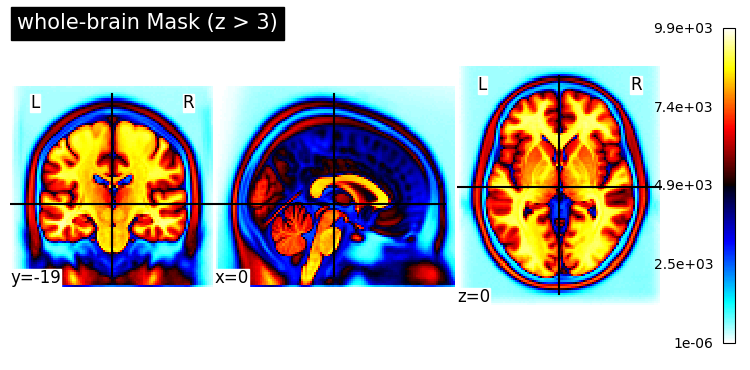

resampling for whole-brain
Neurosynth binary shape: (97, 115, 97)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled whole-brain binary for nBack
loading and binarizing working-memory...
visualizing working-memory


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


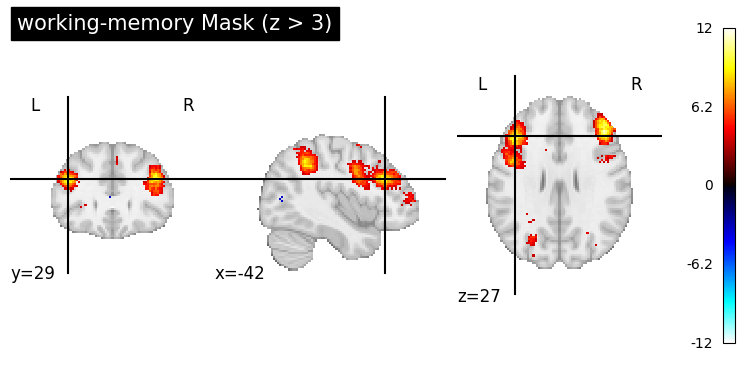

resampling for working-memory
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled working-memory binary for nBack
loading and binarizing attentional-control...
visualizing attentional-control


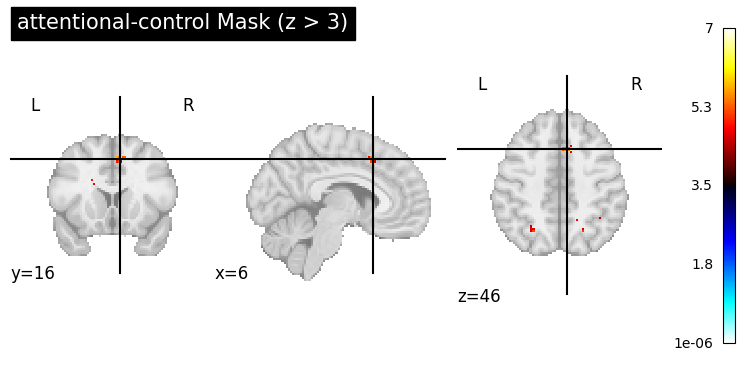

resampling for attentional-control
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled attentional-control binary for nBack
loading and binarizing dlpfc...
visualizing dlpfc


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


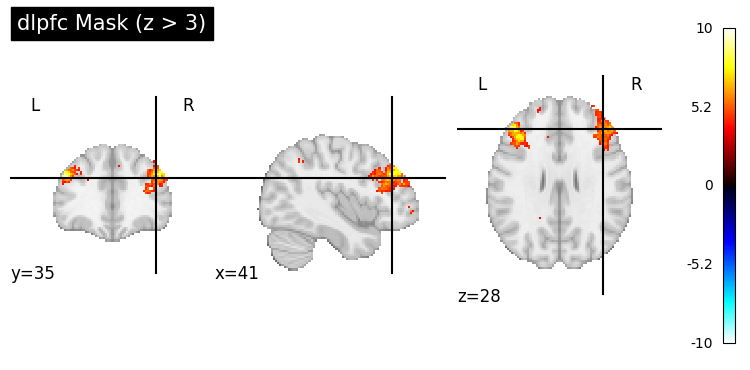

resampling for dlpfc
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled dlpfc binary for nBack
loading and binarizing ips...
visualizing ips


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


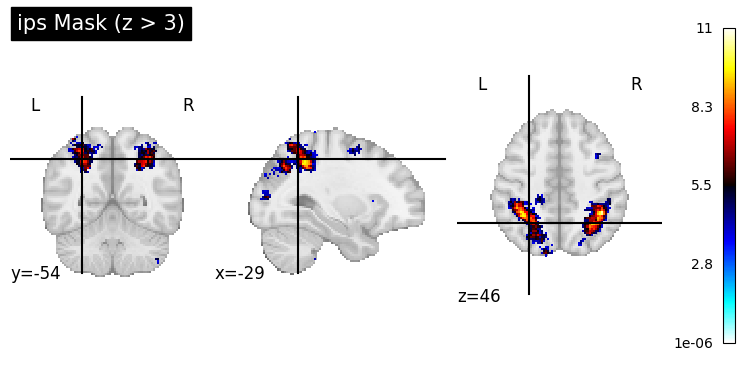

resampling for ips
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled ips binary for nBack


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for nBack | twoBack-oneBack | whole-brain
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for nBack | twoBack-oneBack | working-memory
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for nBack | twoBack-oneBack | attentional-control
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for nBack | twoBack-oneBack | dlpfc
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for nBack | twoBack-oneBack | ips
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for nBack | task-baseline | whole-brain
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for nBack | task-baseline | working-memory
Computing RSM for 5 maps using pearson correlation
Successfully co

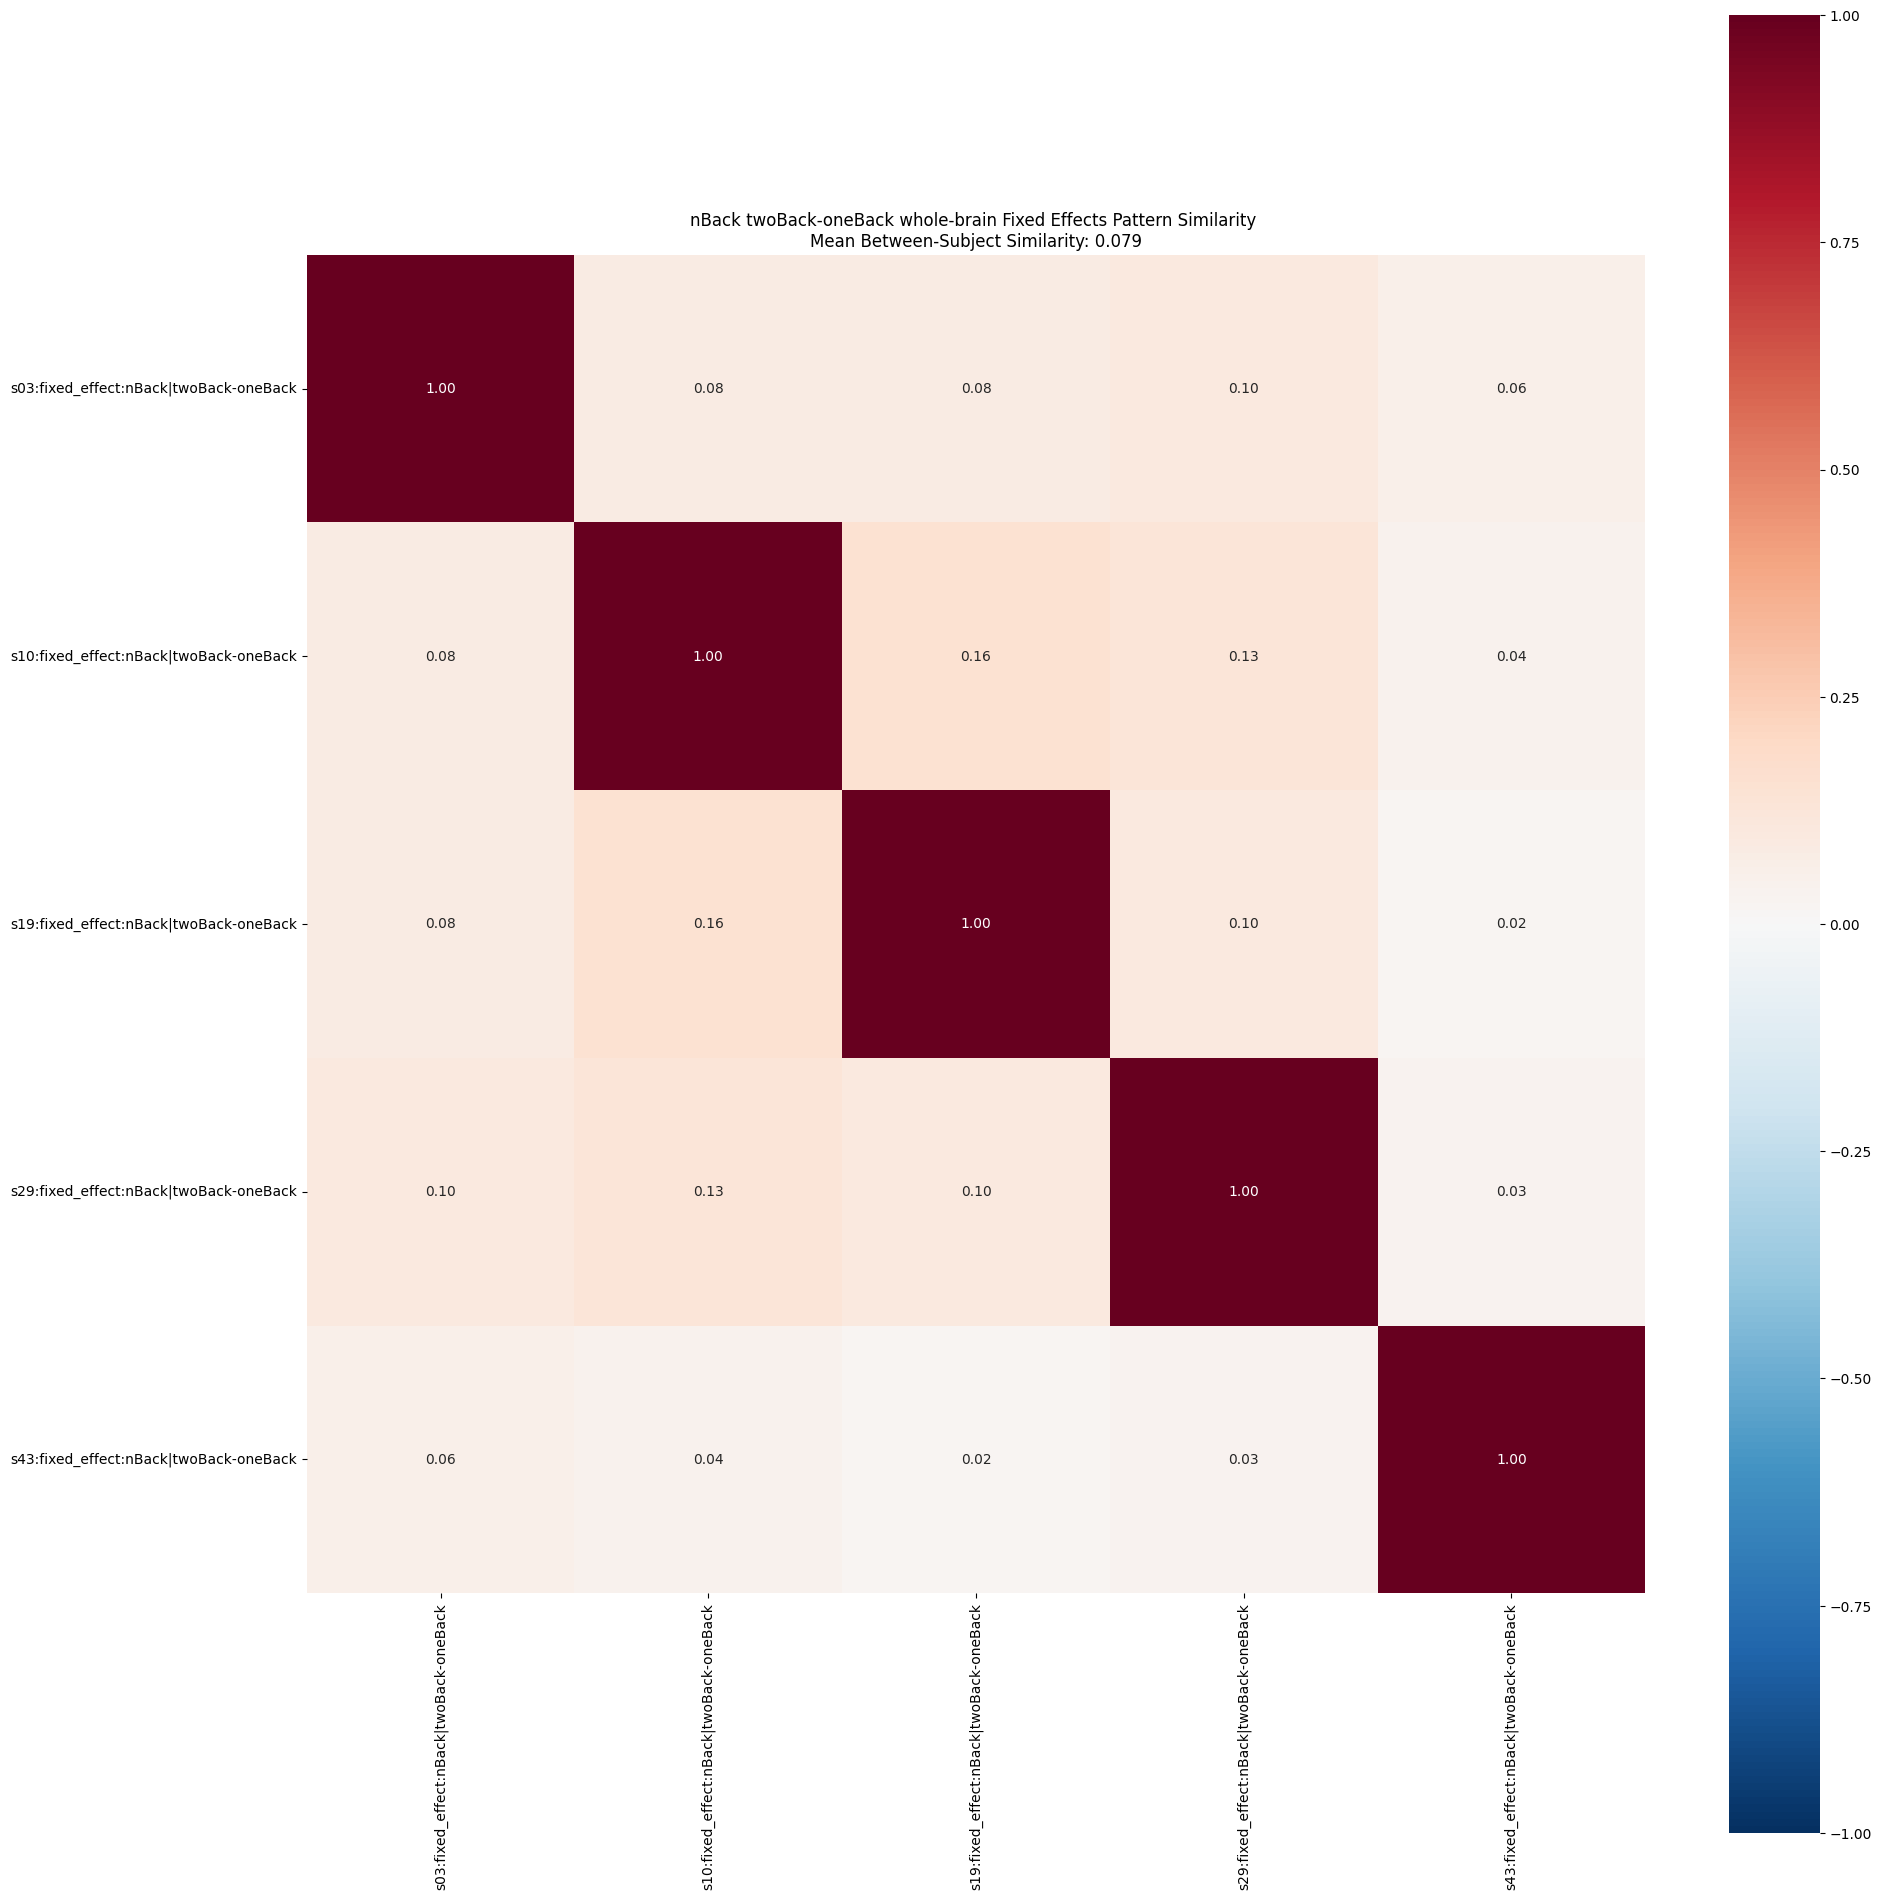

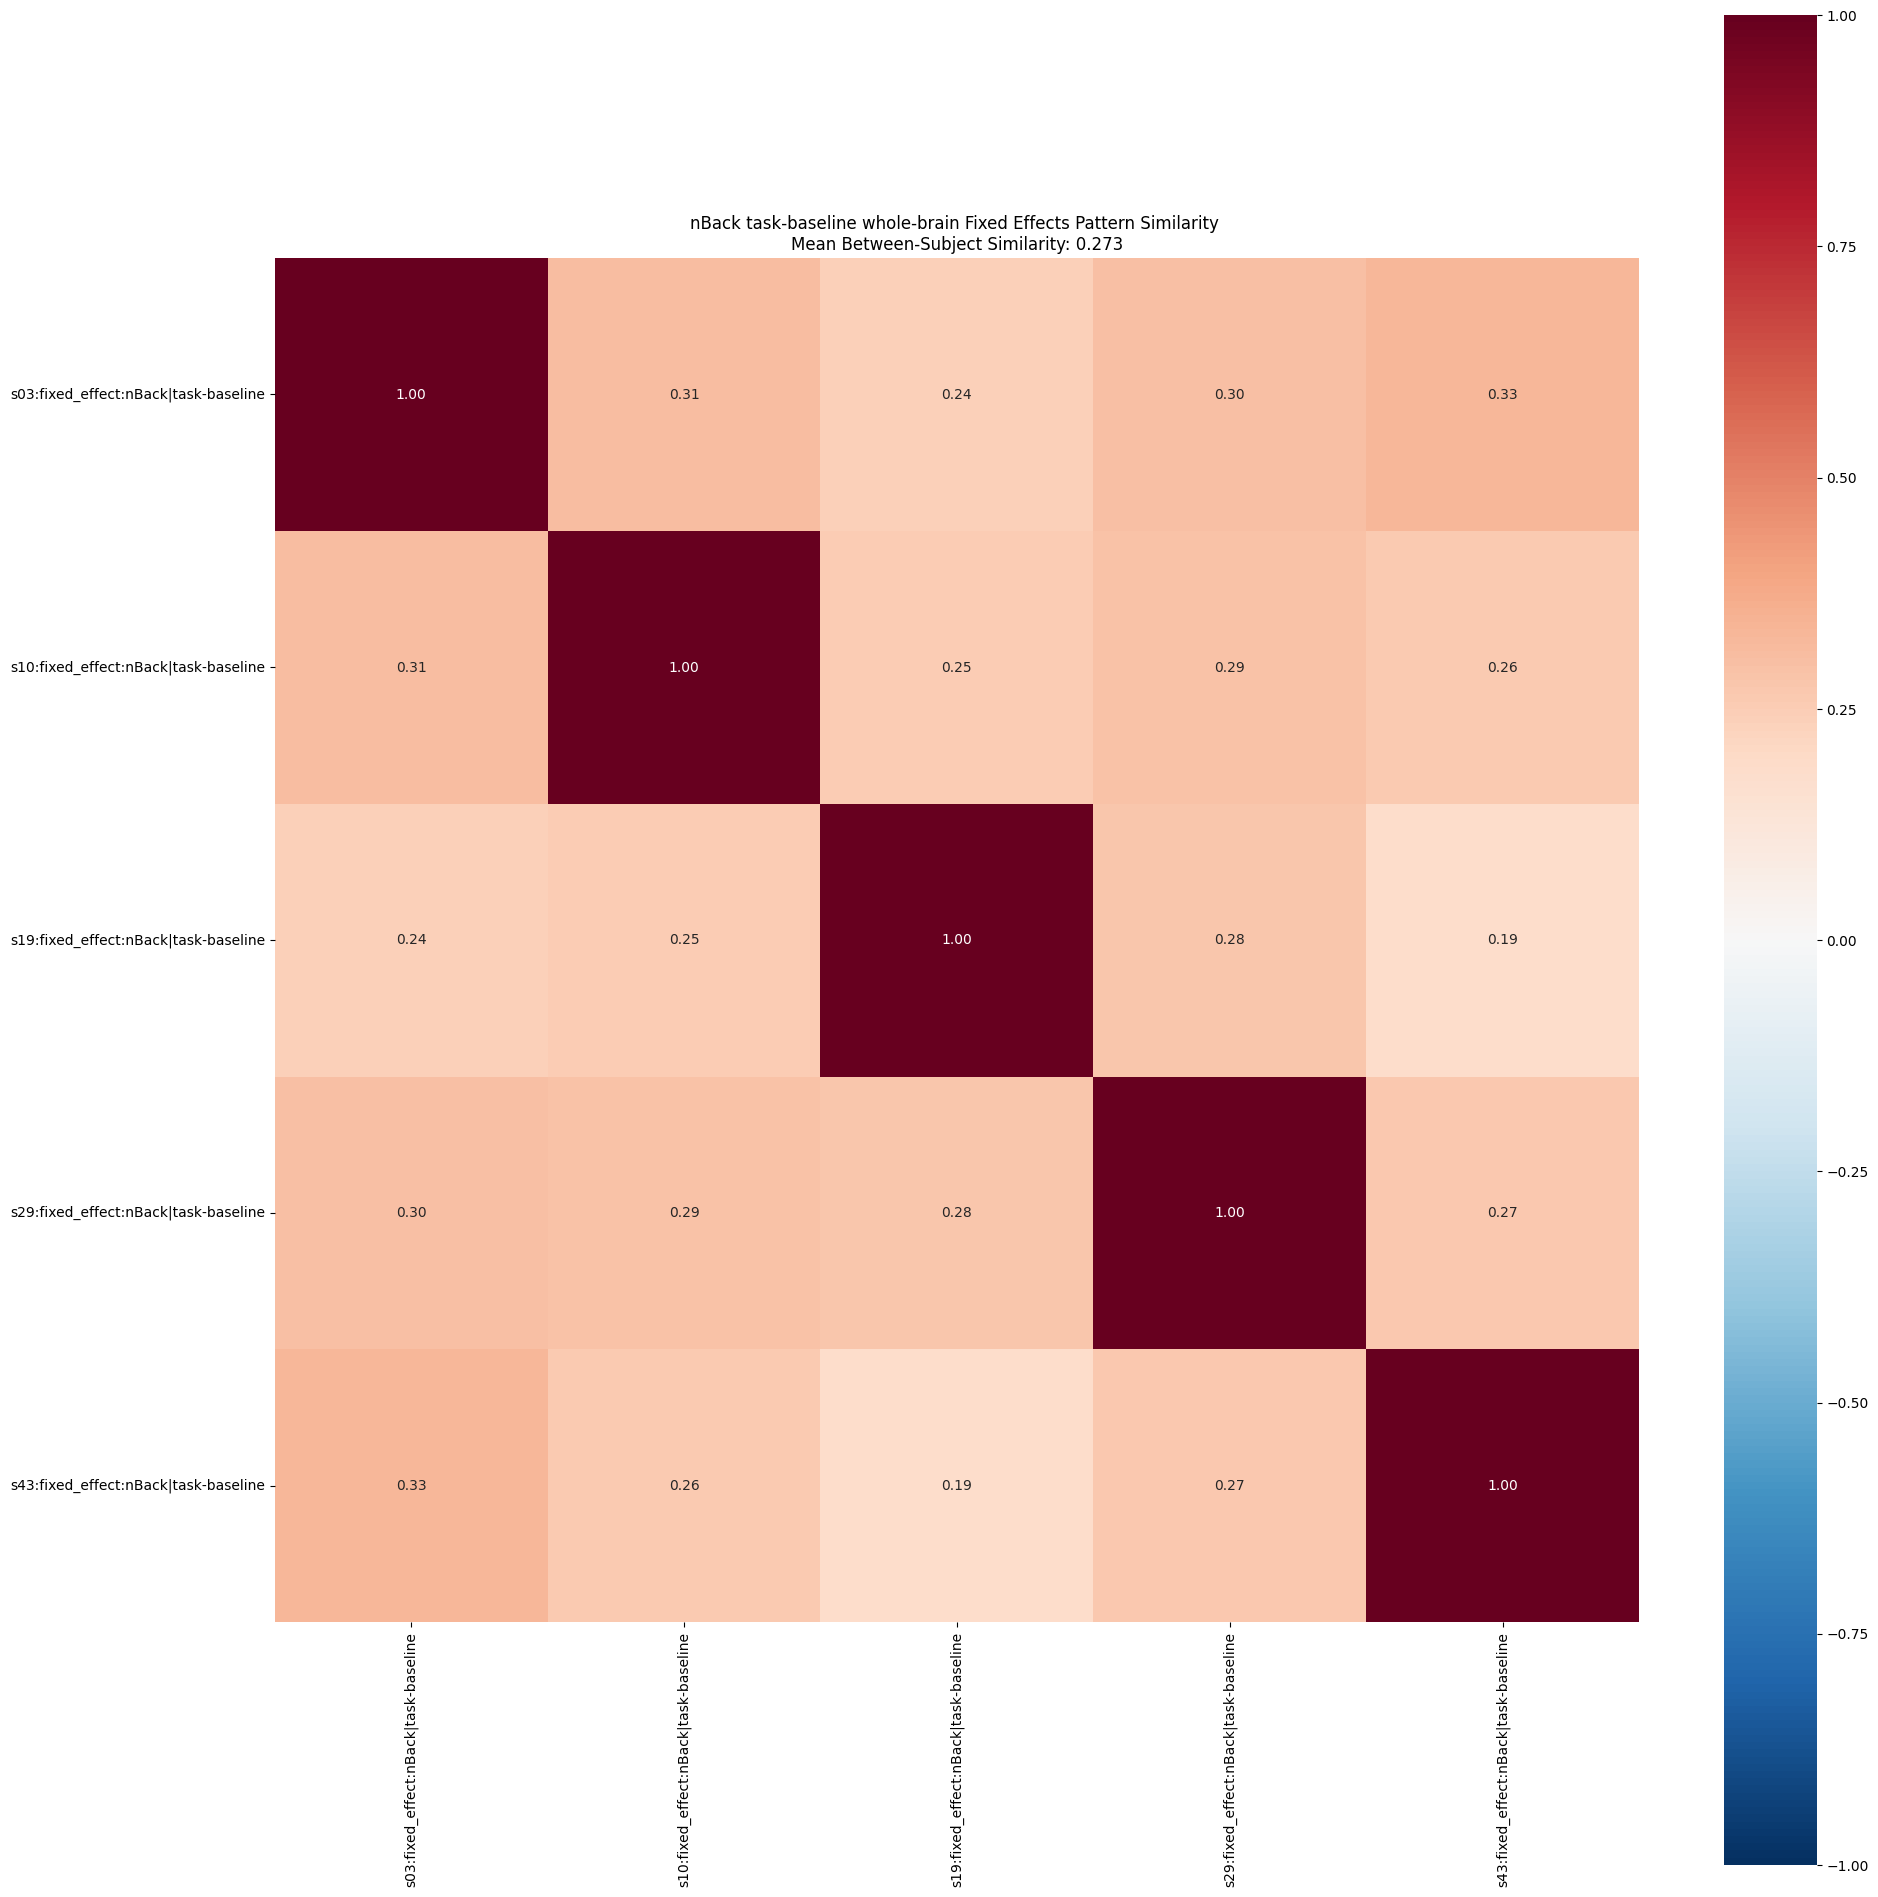

incongruent-congruent: 5 maps loaded
  Map shape: (97, 115, 97)
task-baseline: 5 maps loaded
  Map shape: (97, 115, 97)
loading and binarizing whole-brain...
visualizing whole-brain


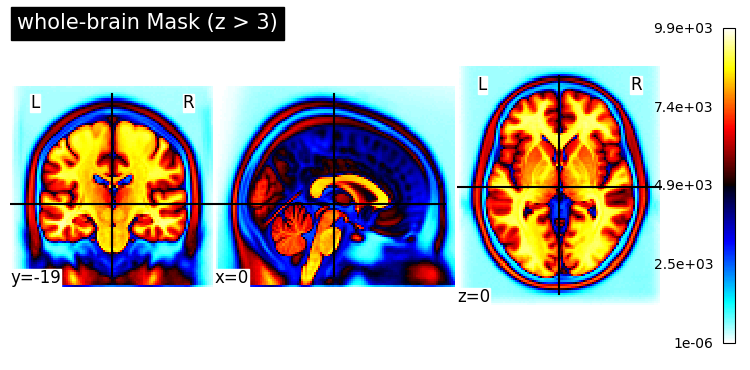

resampling for whole-brain
Neurosynth binary shape: (97, 115, 97)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled whole-brain binary for flanker
loading and binarizing inhibitory-control...
visualizing inhibitory-control


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


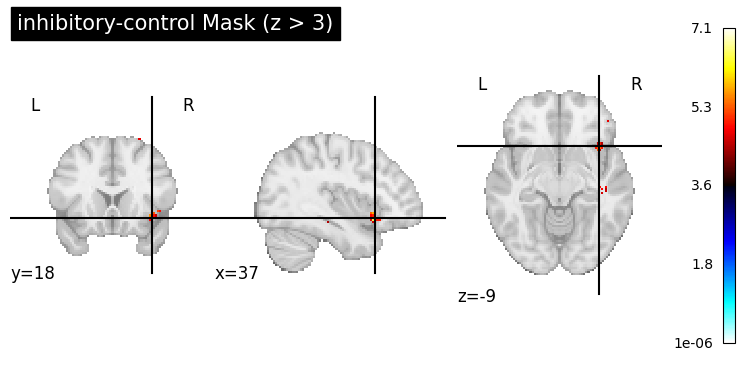

resampling for inhibitory-control
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled inhibitory-control binary for flanker
loading and binarizing dlpfc...
visualizing dlpfc


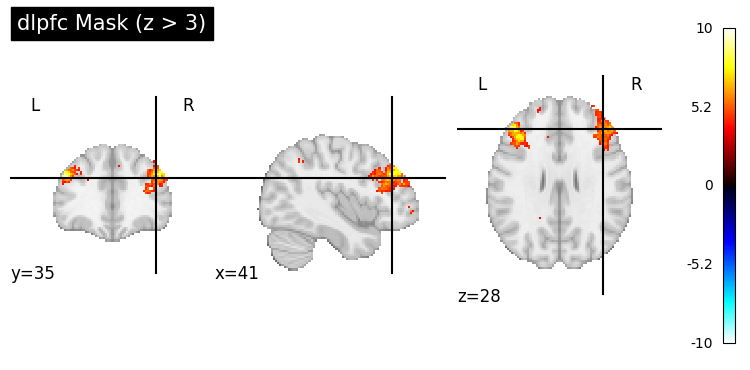

resampling for dlpfc
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled dlpfc binary for flanker
loading and binarizing acc...
visualizing acc


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


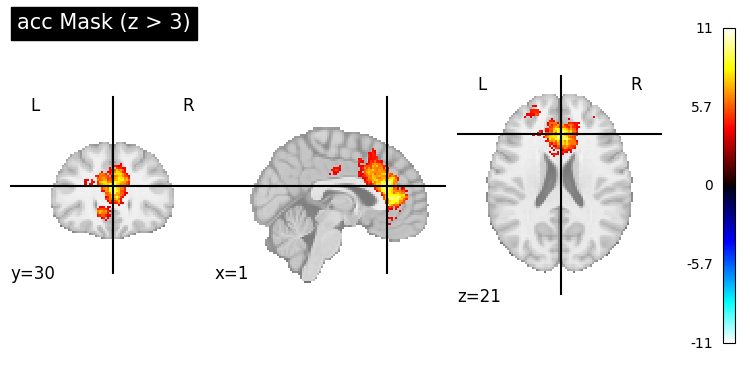

resampling for acc
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled acc binary for flanker
loading and binarizing ips...
visualizing ips


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


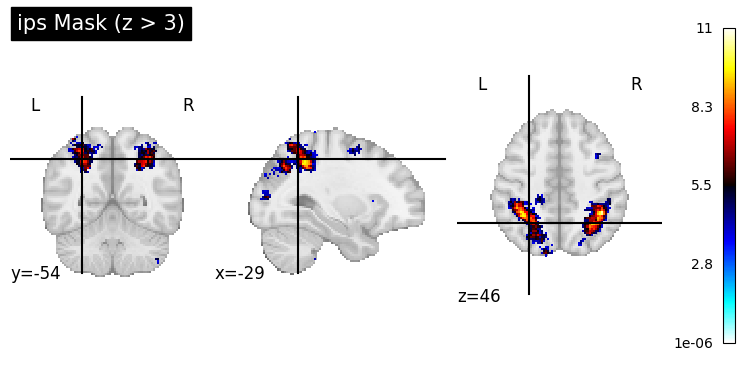

resampling for ips
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled ips binary for flanker


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for flanker | incongruent-congruent | whole-brain
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for flanker | incongruent-congruent | inhibitory-control
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for flanker | incongruent-congruent | dlpfc
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for flanker | incongruent-congruent | acc
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for flanker | incongruent-congruent | ips
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for flanker | task-baseline | whole-brain
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for flanker | task-baseline | inhibitory-control
Computing RSM for 5 maps using

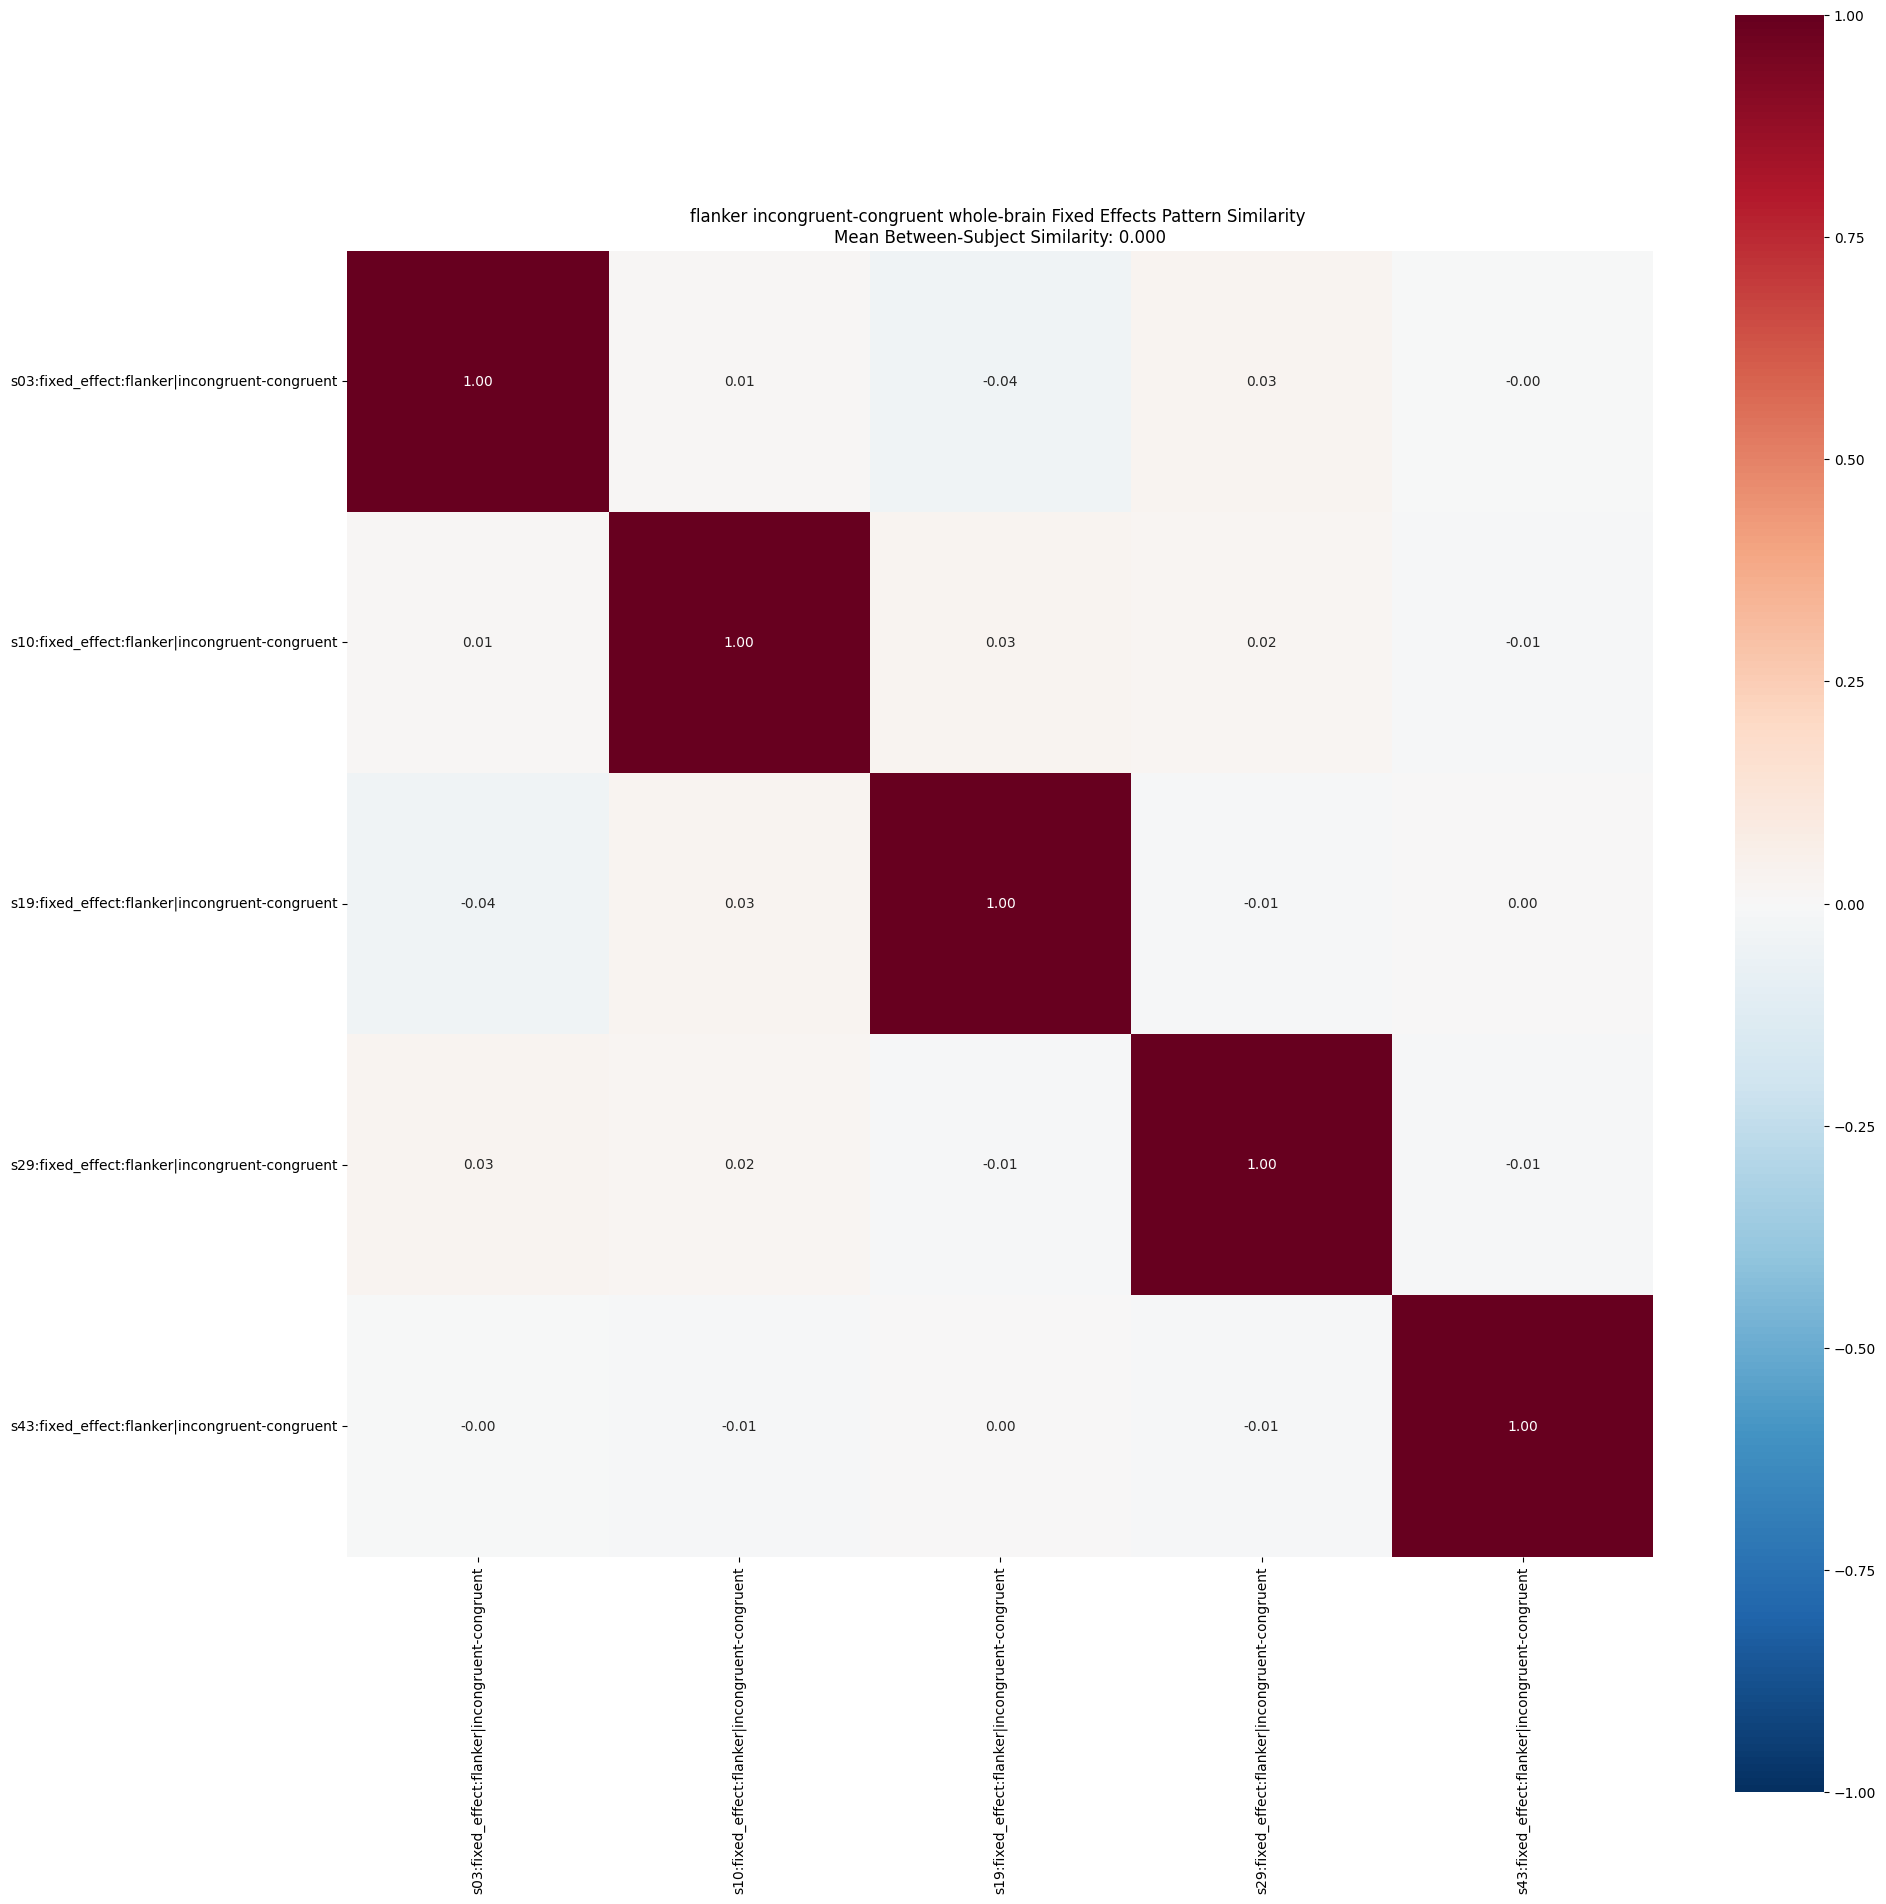

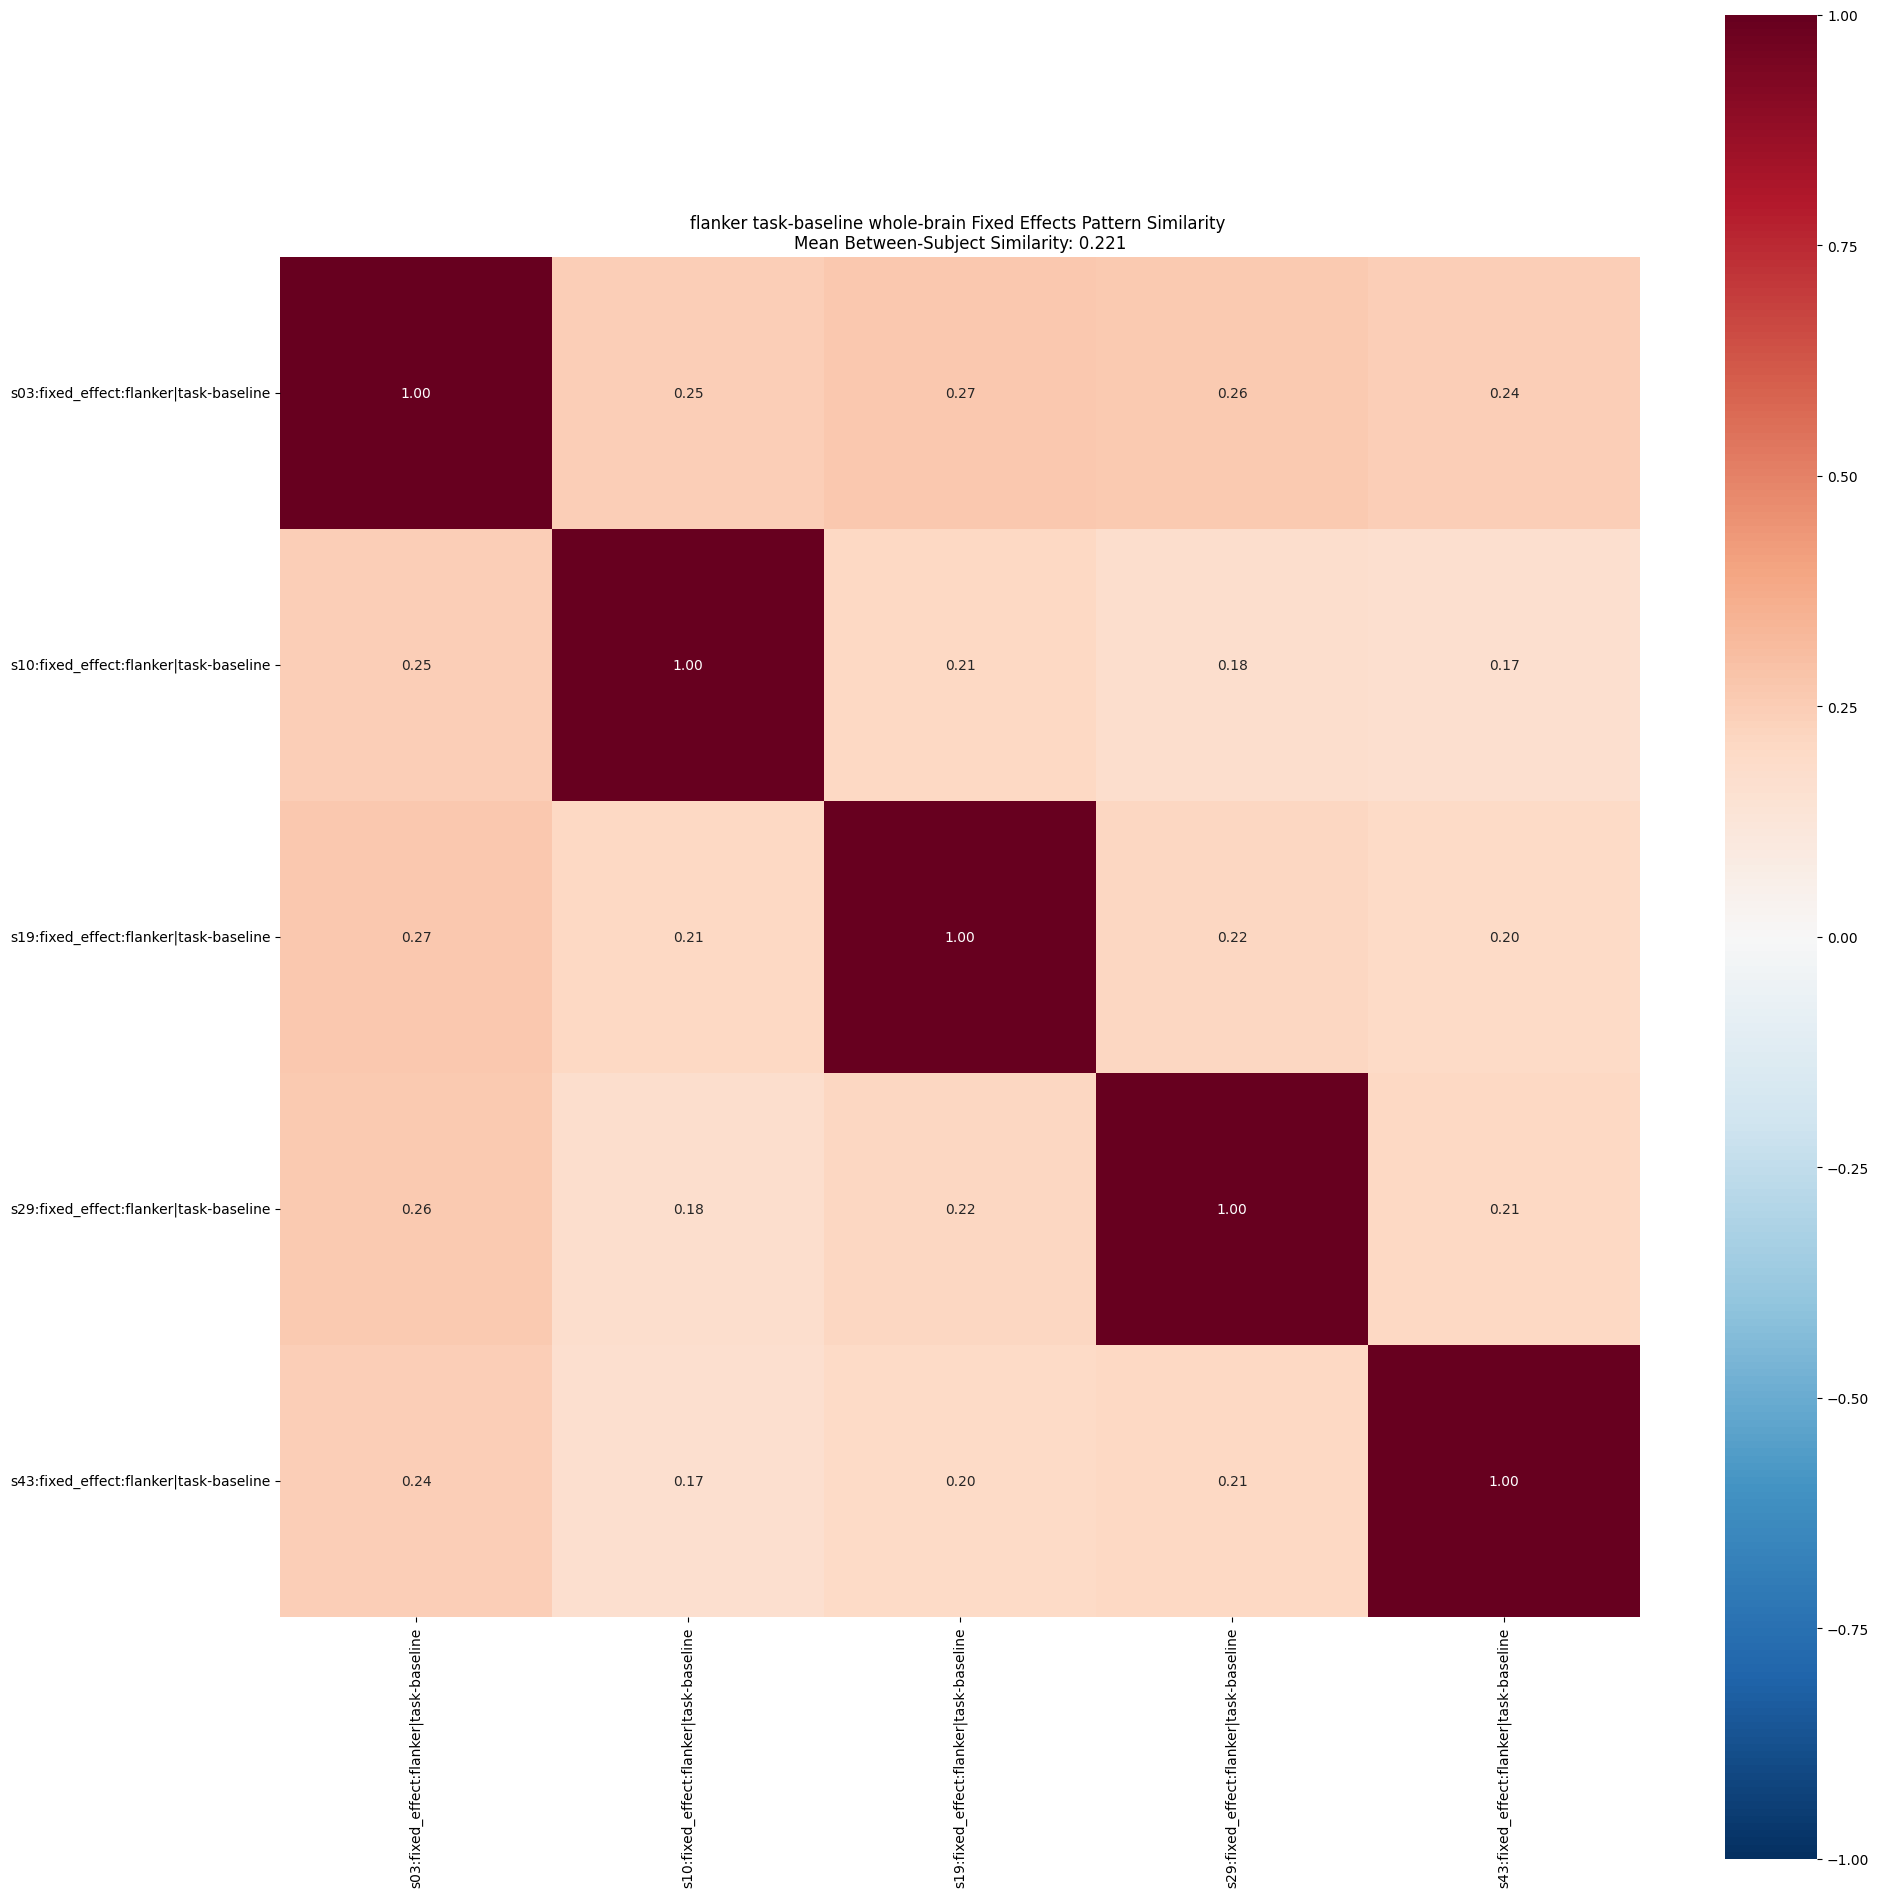

neg-con: 5 maps loaded
  Map shape: (97, 115, 97)
task-baseline: 5 maps loaded
  Map shape: (97, 115, 97)
loading and binarizing whole-brain...
visualizing whole-brain


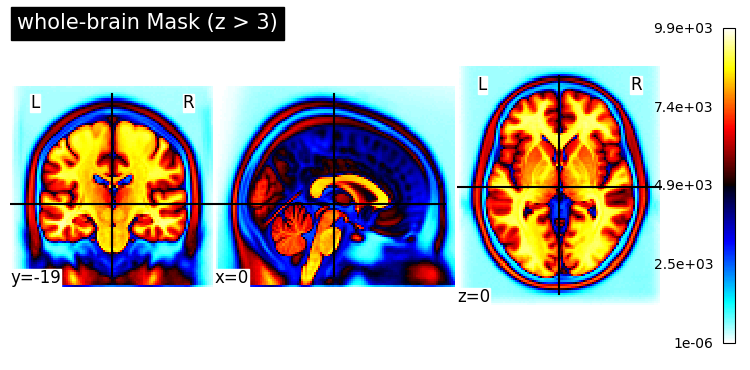

resampling for whole-brain
Neurosynth binary shape: (97, 115, 97)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled whole-brain binary for directedForgetting
loading and binarizing response-inhibition...
visualizing response-inhibition


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


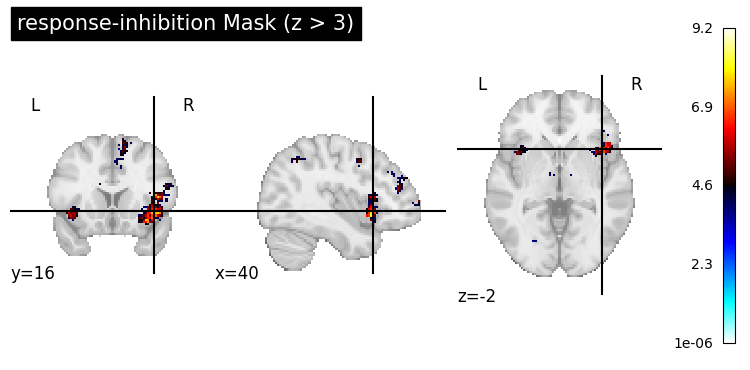

resampling for response-inhibition
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled response-inhibition binary for directedForgetting
loading and binarizing working-memory...
visualizing working-memory


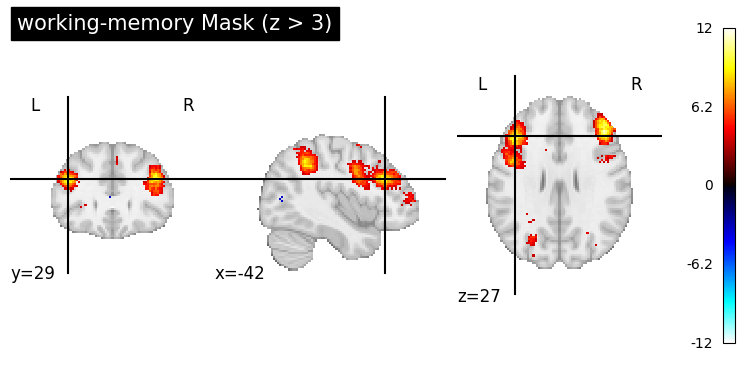

resampling for working-memory
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled working-memory binary for directedForgetting
loading and binarizing attentional-control...
visualizing attentional-control


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


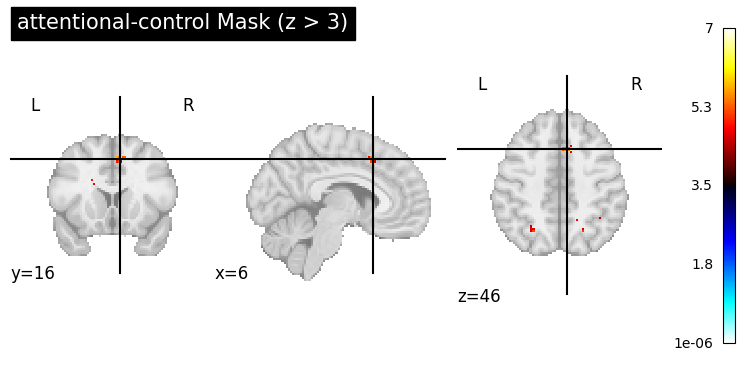

resampling for attentional-control
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled attentional-control binary for directedForgetting
loading and binarizing dlpfc...
visualizing dlpfc


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


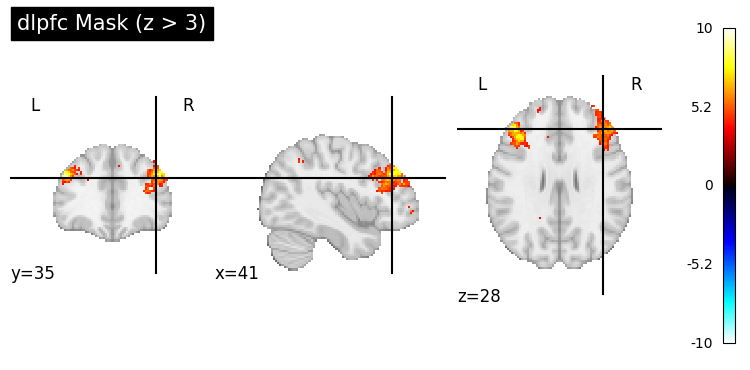

resampling for dlpfc
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled dlpfc binary for directedForgetting
loading and binarizing acc...
visualizing acc


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


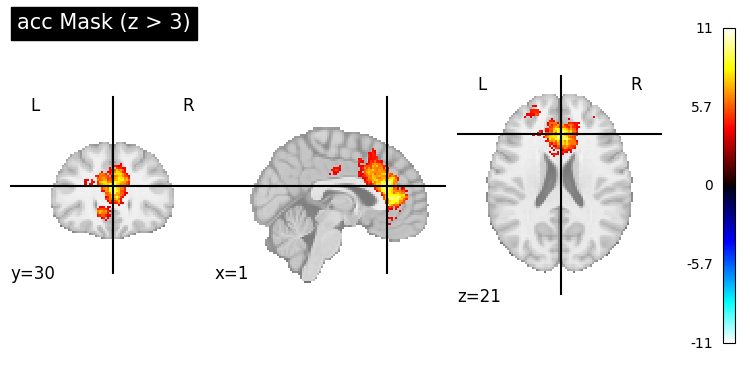

resampling for acc
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled acc binary for directedForgetting


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for directedForgetting | neg-con | whole-brain
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for directedForgetting | neg-con | response-inhibition
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for directedForgetting | neg-con | working-memory
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for directedForgetting | neg-con | attentional-control
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for directedForgetting | neg-con | dlpfc
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for directedForgetting | neg-con | acc
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for directedForgetting | task-baseline | whole-brain
Computing RSM fo

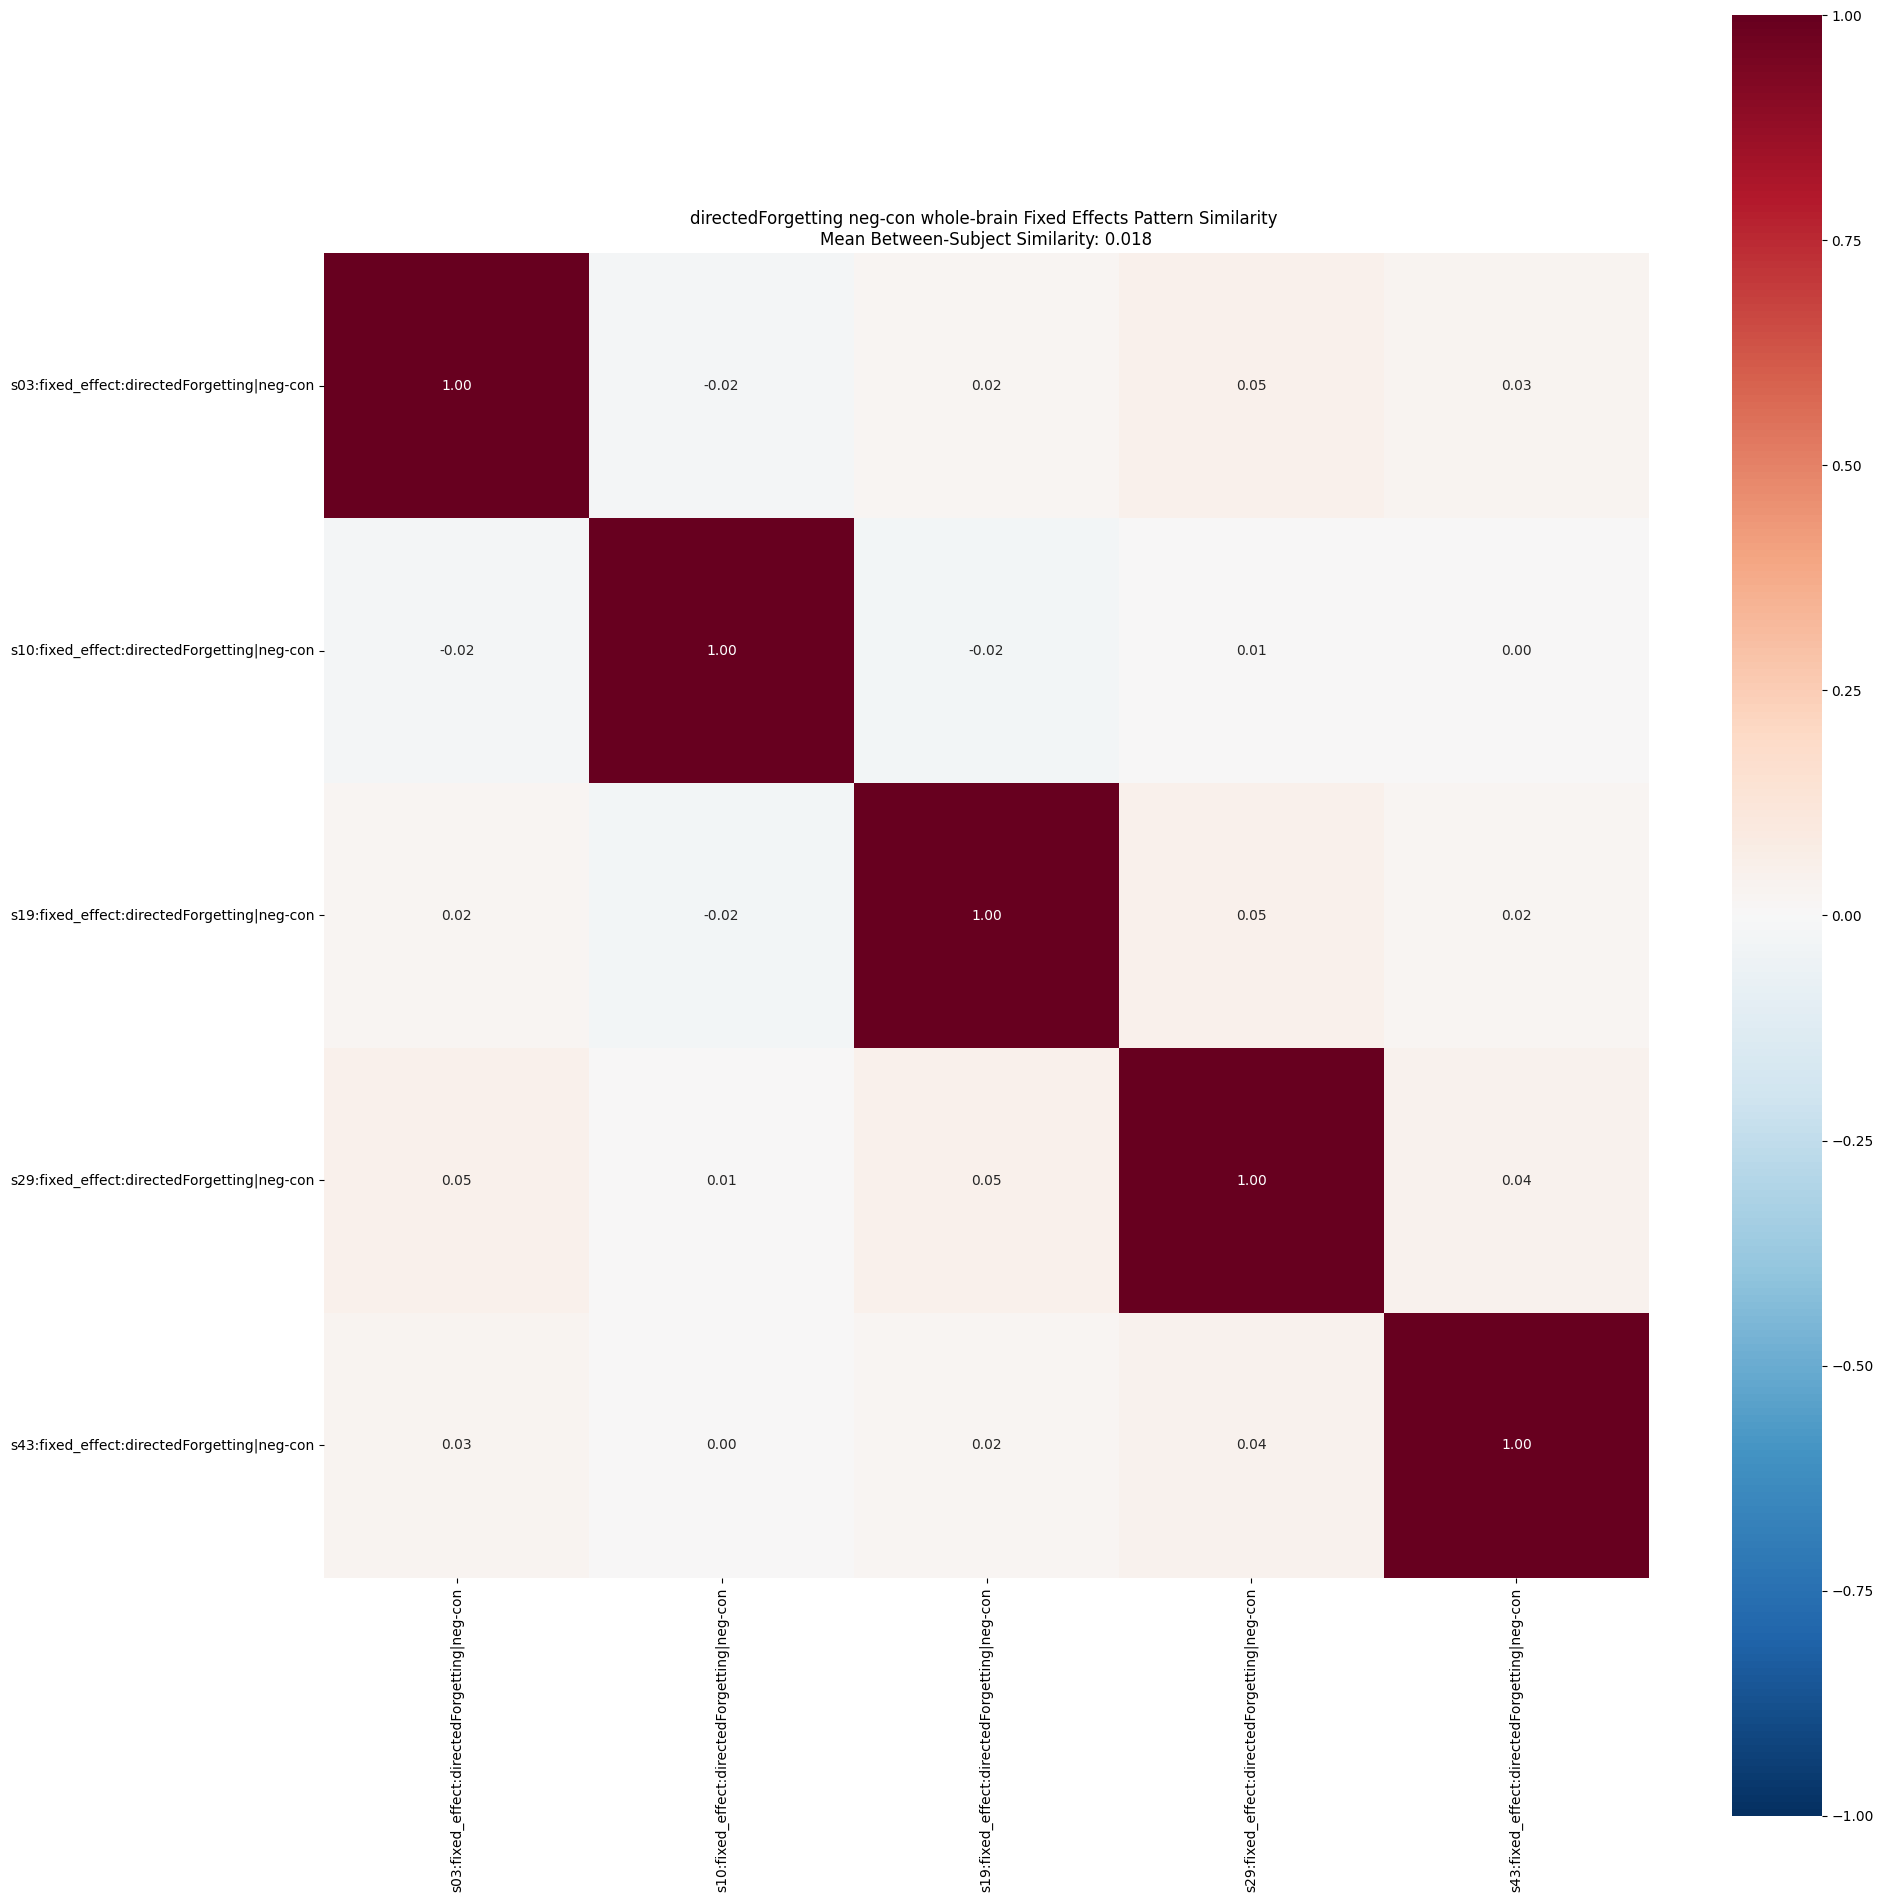

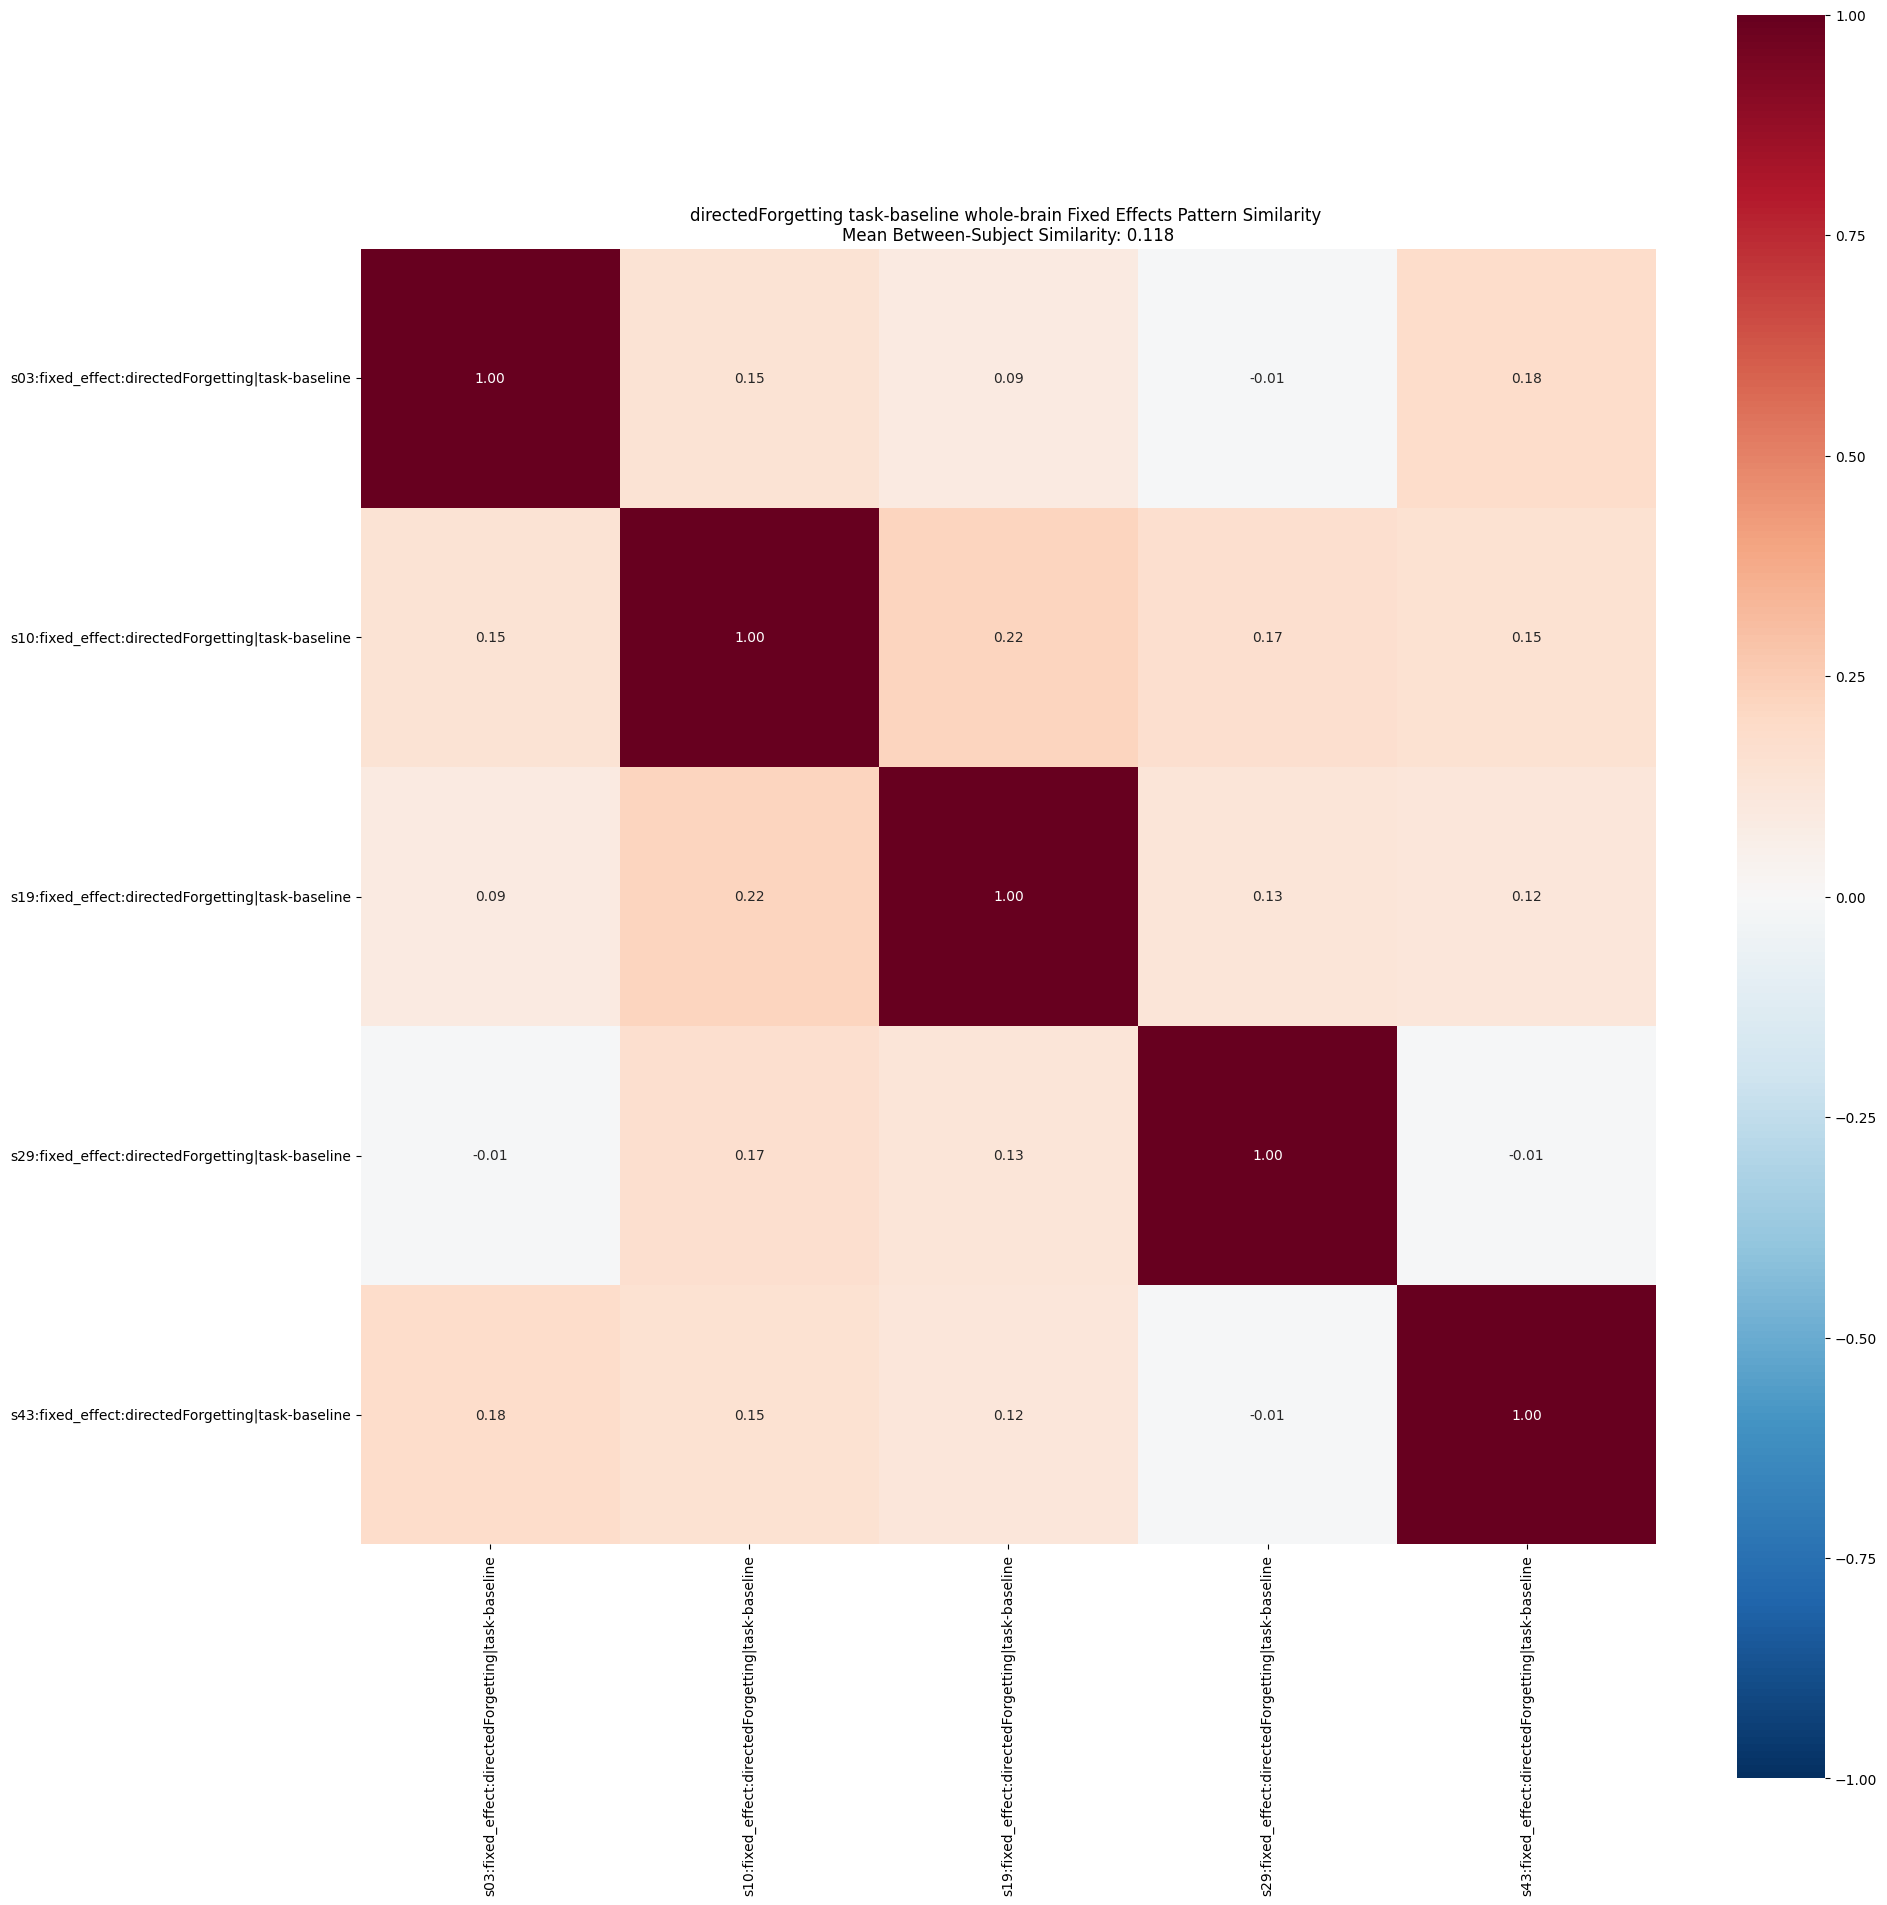

nogo_success-go: 5 maps loaded
  Map shape: (97, 115, 97)
task-baseline: 5 maps loaded
  Map shape: (97, 115, 97)
loading and binarizing whole-brain...
visualizing whole-brain


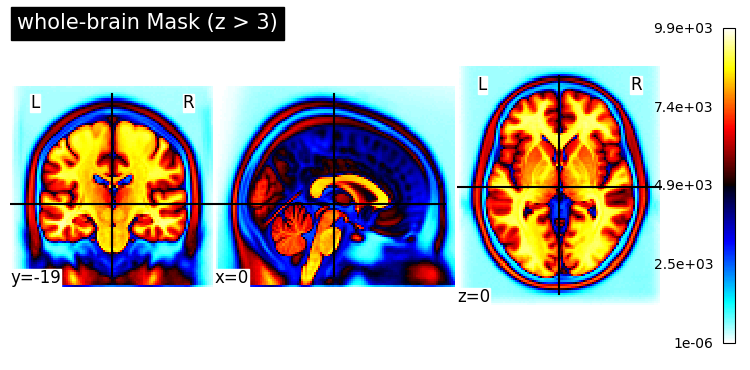

resampling for whole-brain
Neurosynth binary shape: (97, 115, 97)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled whole-brain binary for goNogo
loading and binarizing response-inhibition...
visualizing response-inhibition


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


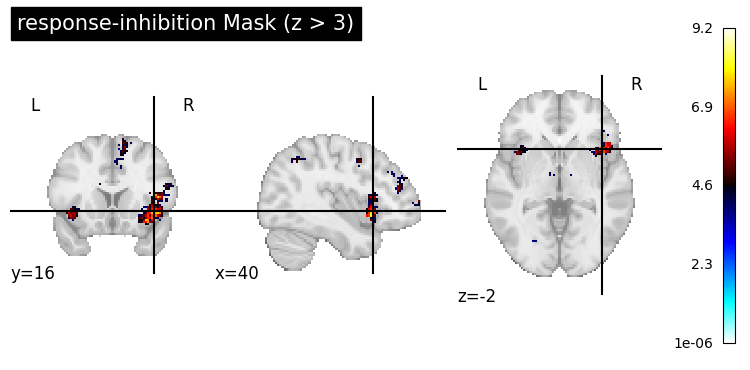

resampling for response-inhibition
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled response-inhibition binary for goNogo
ROIs not found are:
rifg
pre-sma
rIFG mask: 901 voxels
pre-SMA mask: 184 voxels
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for goNogo | nogo_success-go | whole-brain
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for goNogo | nogo_success-go | response-inhibition
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for goNogo | nogo_success-go | rifg
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for goNogo | nogo_success-go | pre-sma
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for goNogo | task-baseline | whole-brain
Computing RSM for 5 maps using pearson correla

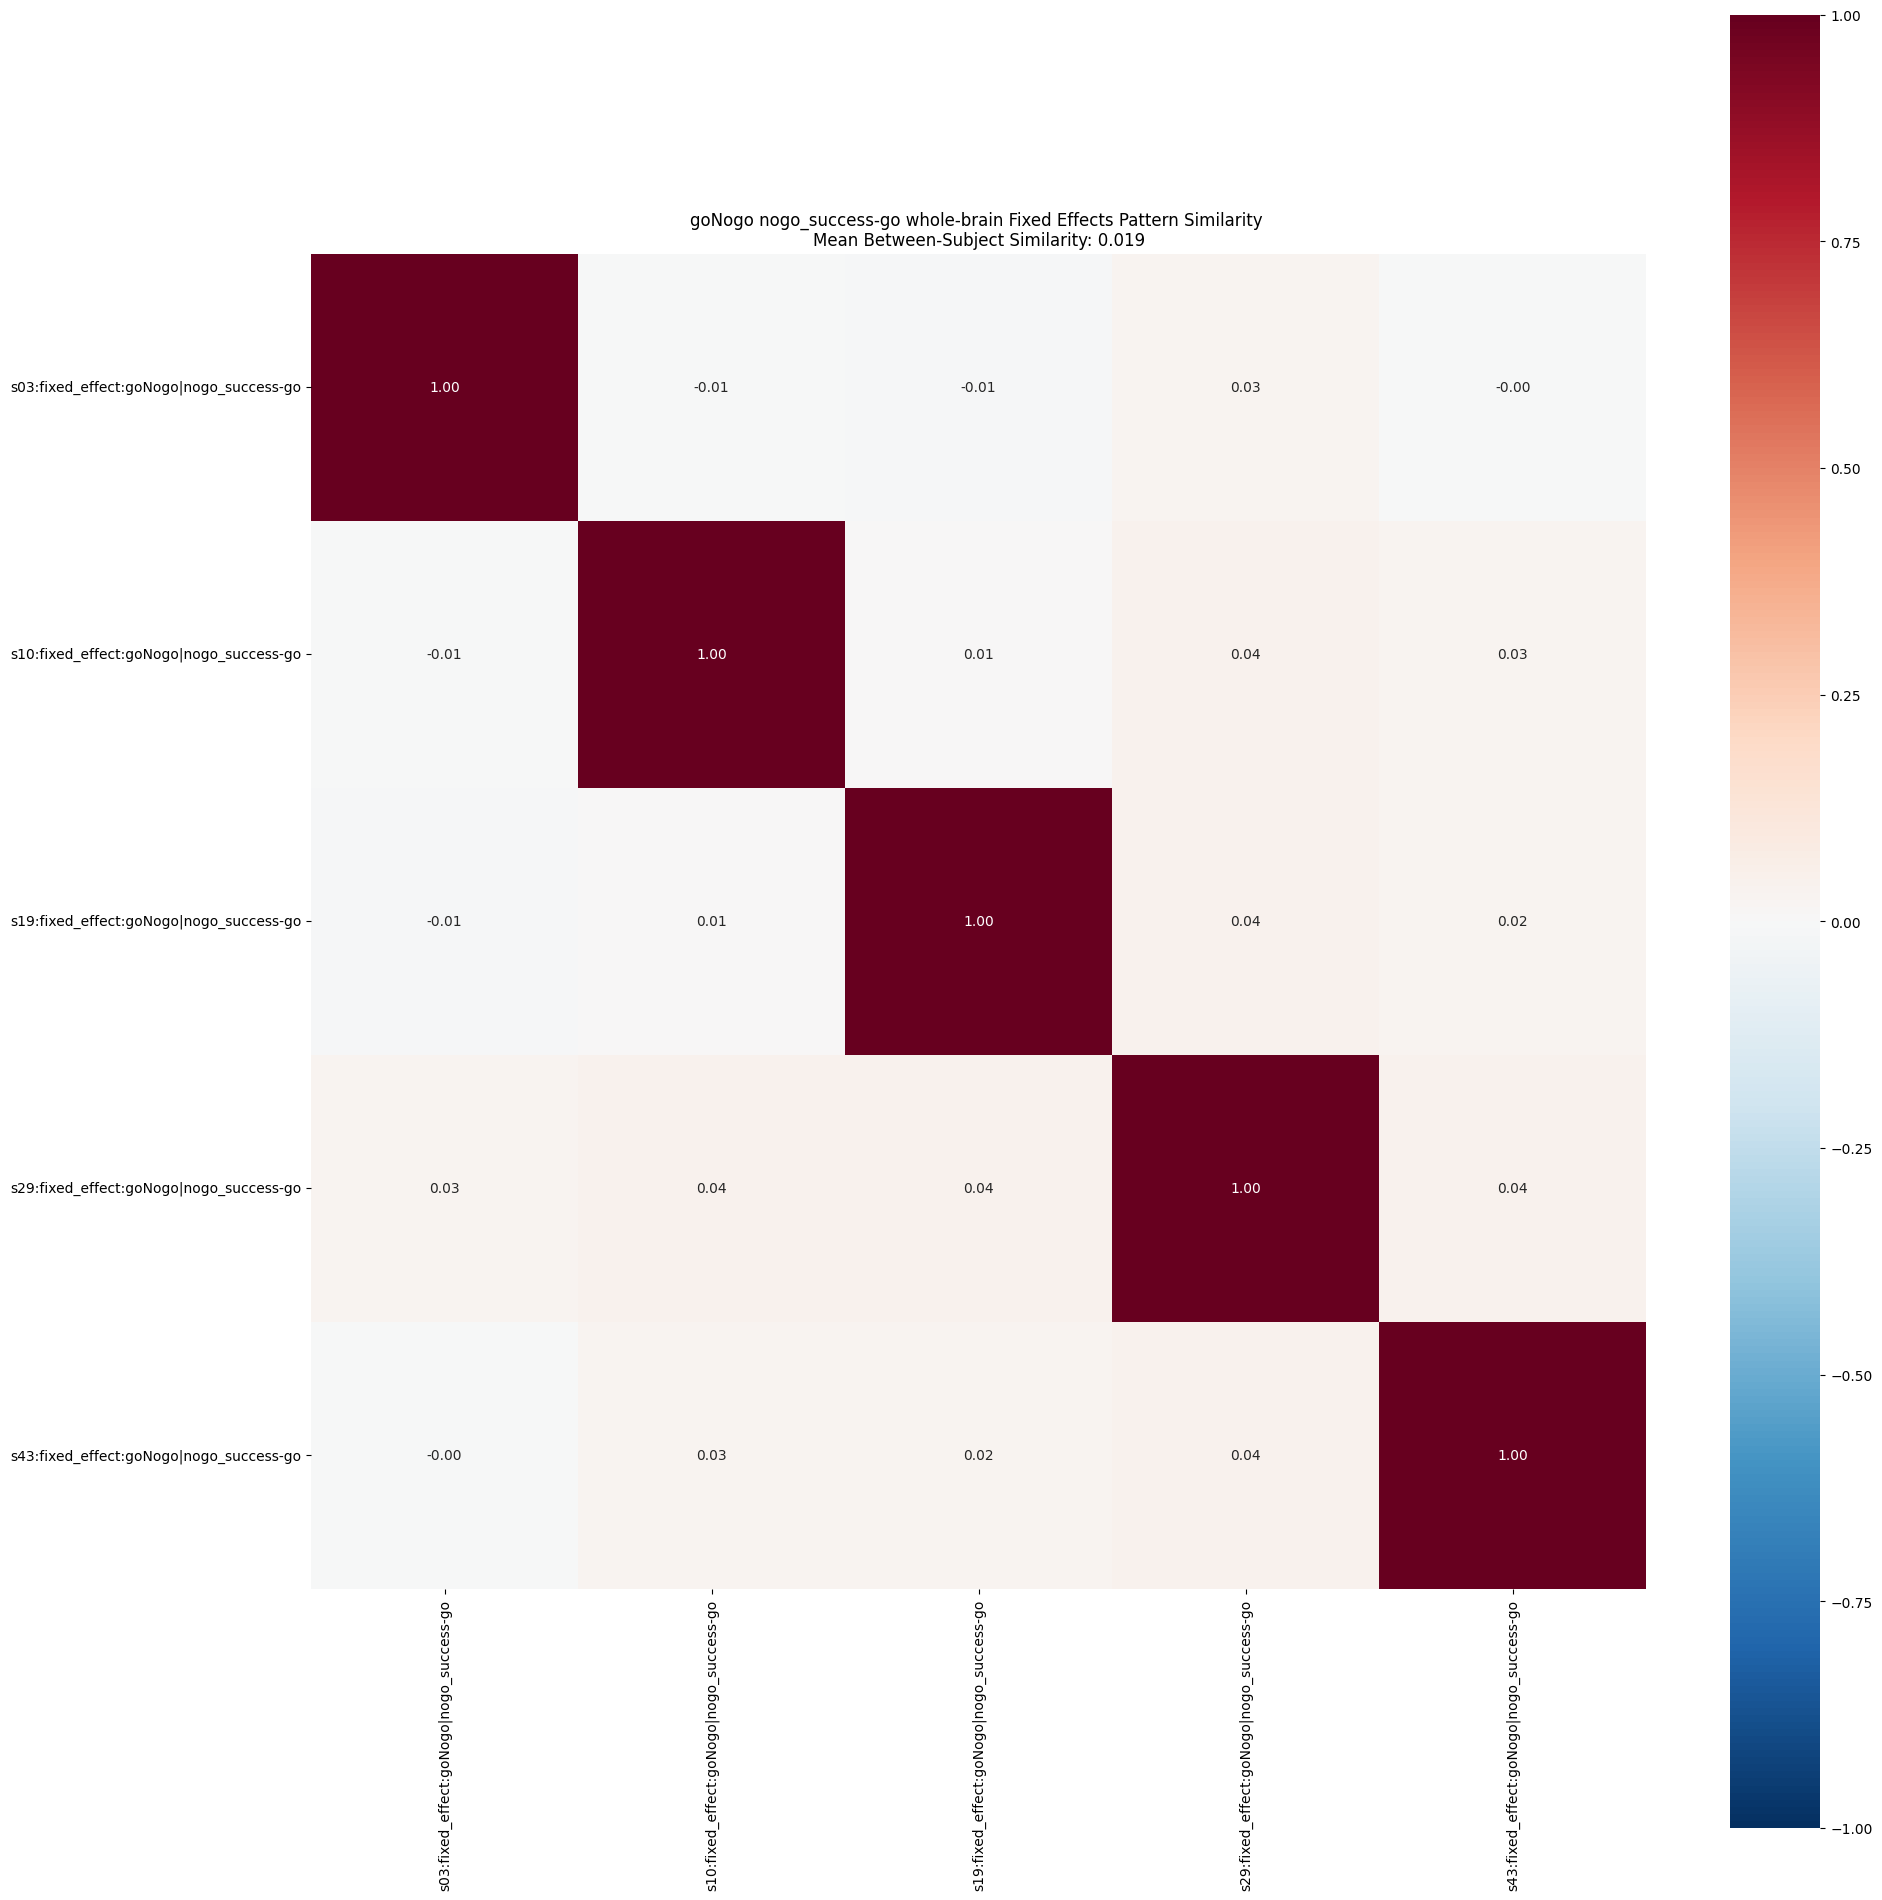

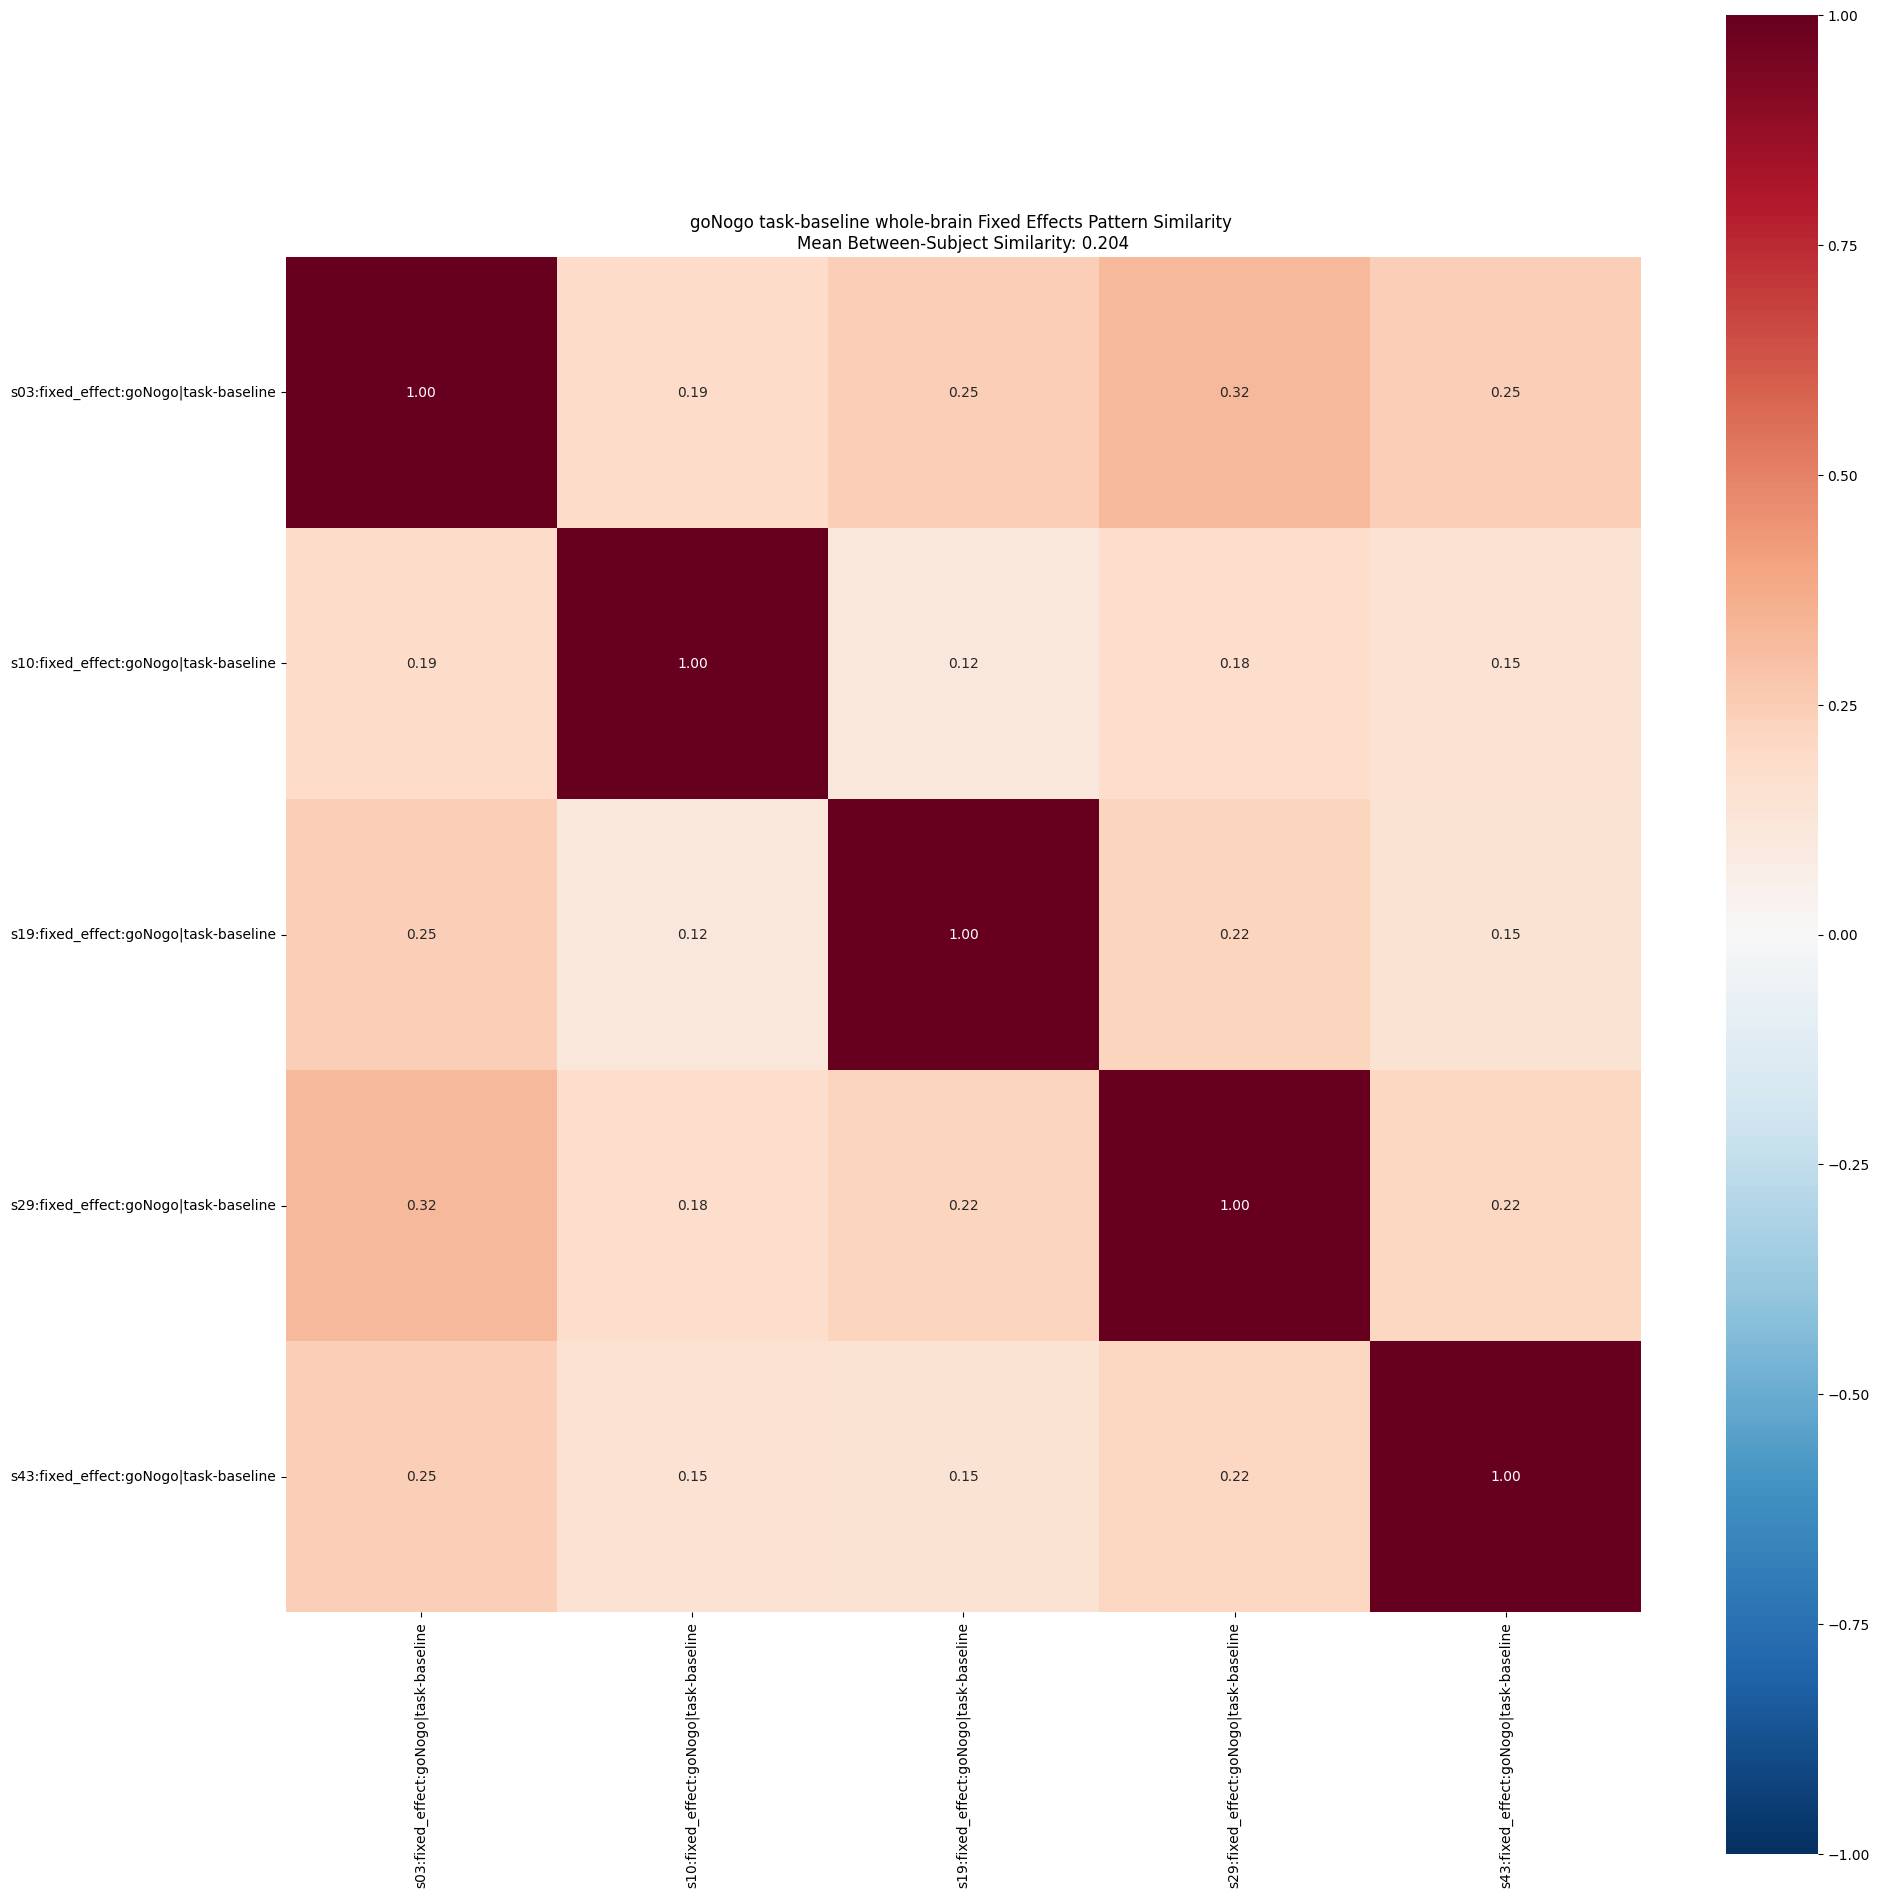

main_vars: 5 maps loaded
  Map shape: (97, 115, 97)
task-baseline: 5 maps loaded
  Map shape: (97, 115, 97)
loading and binarizing whole-brain...
visualizing whole-brain


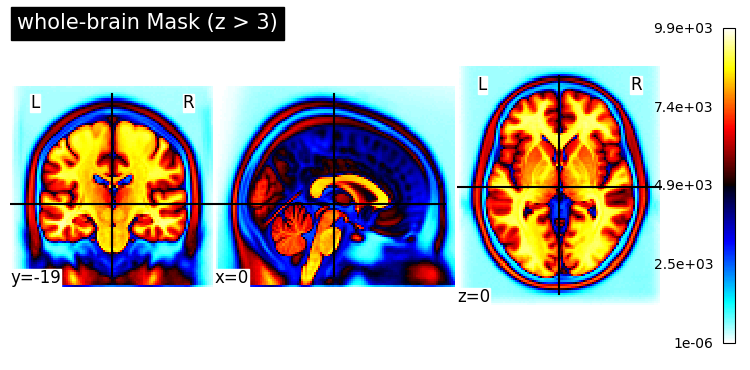

resampling for whole-brain
Neurosynth binary shape: (97, 115, 97)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled whole-brain binary for shapeMatching
loading and binarizing working-memory...
visualizing working-memory


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


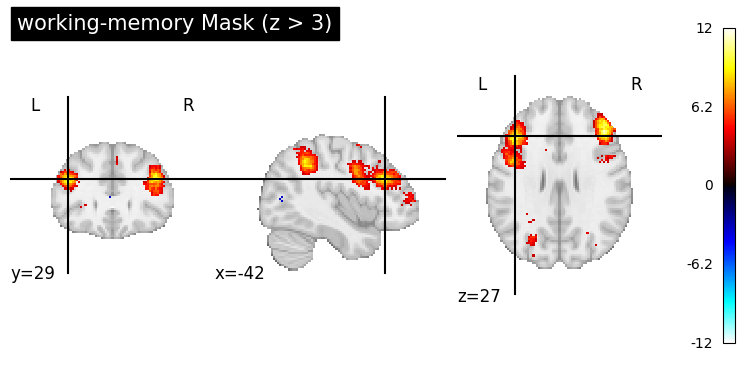

resampling for working-memory
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled working-memory binary for shapeMatching
loading and binarizing attentional-control...
visualizing attentional-control


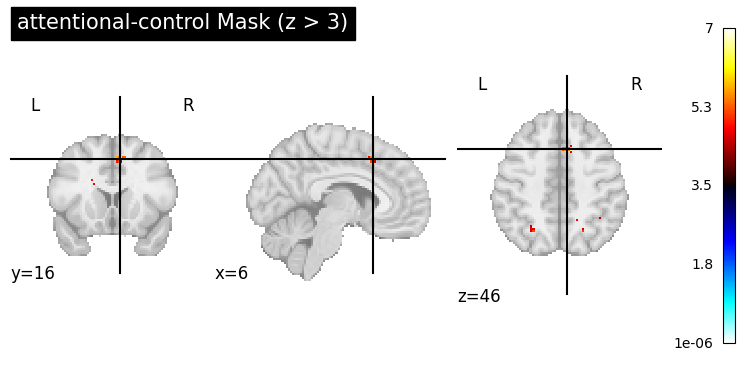

resampling for attentional-control
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled attentional-control binary for shapeMatching
loading and binarizing inhibitory-control...
visualizing inhibitory-control


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


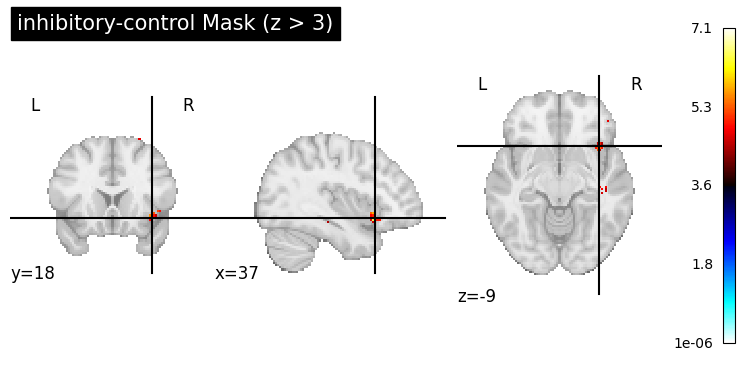

resampling for inhibitory-control
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled inhibitory-control binary for shapeMatching
loading and binarizing dlpfc...
visualizing dlpfc


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


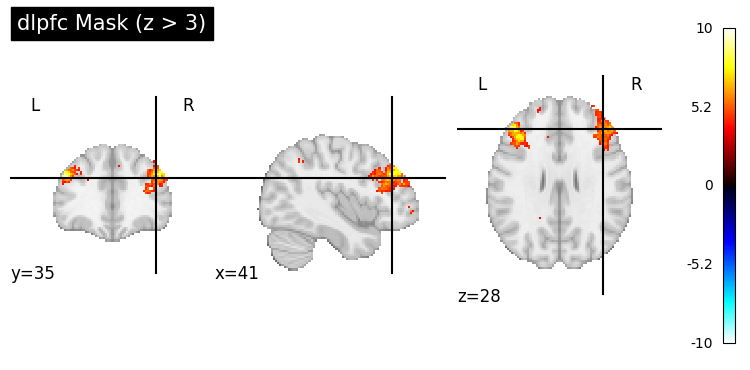

resampling for dlpfc
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled dlpfc binary for shapeMatching
loading and binarizing ips...
visualizing ips


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


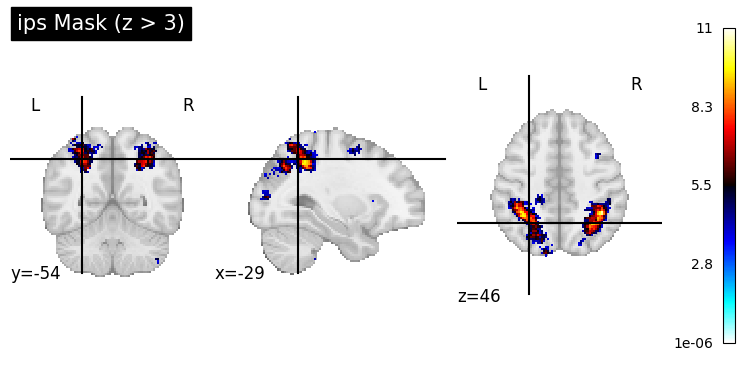

resampling for ips
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled ips binary for shapeMatching
loading and binarizing acc...
visualizing acc


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


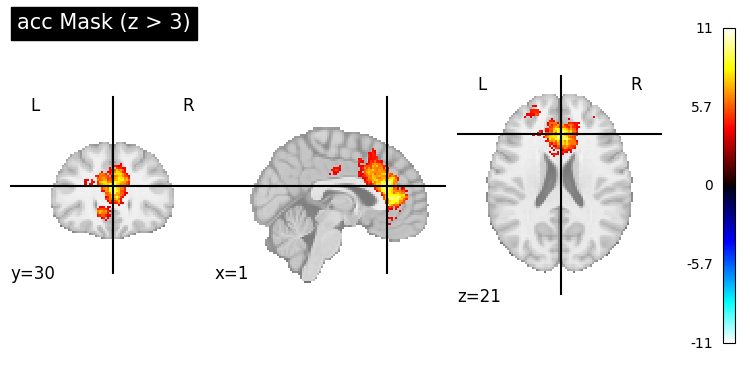

resampling for acc
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled acc binary for shapeMatching


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for shapeMatching | main_vars | whole-brain
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for shapeMatching | main_vars | working-memory
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for shapeMatching | main_vars | attentional-control
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for shapeMatching | main_vars | inhibitory-control
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for shapeMatching | main_vars | dlpfc
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for shapeMatching | main_vars | ips
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for shapeMatching | main_vars | acc
Computing RSM for 5 maps using pearson correlation
S

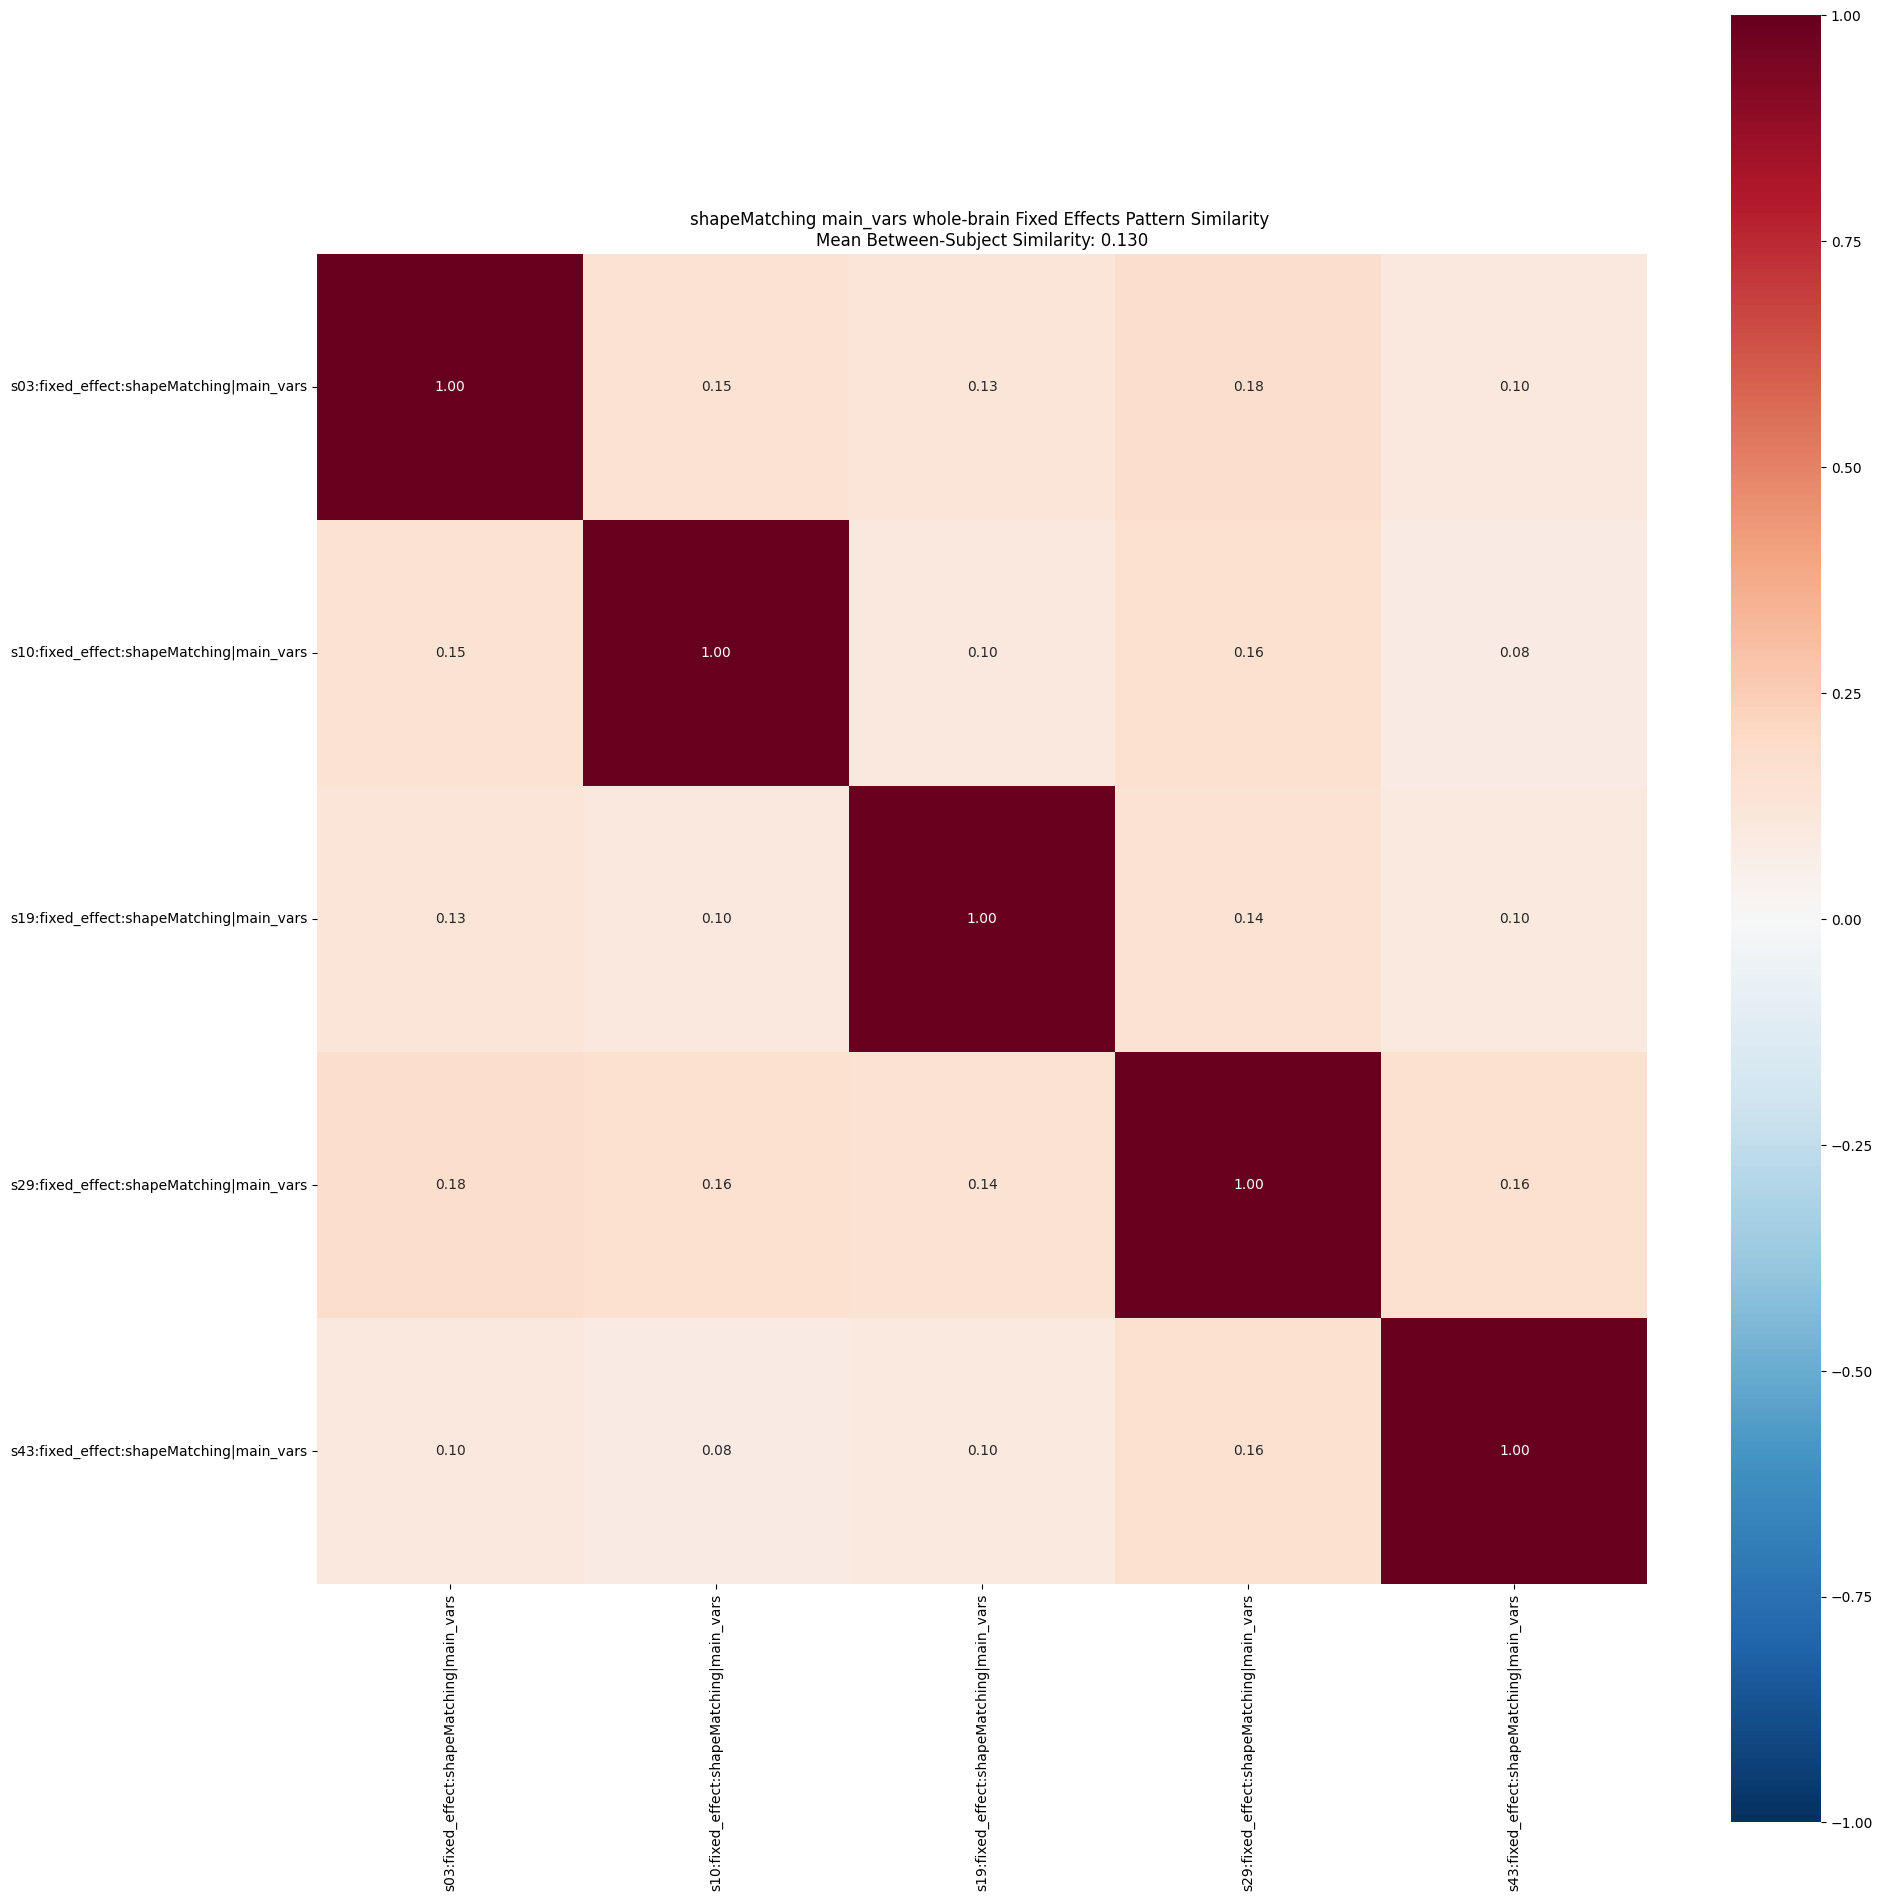

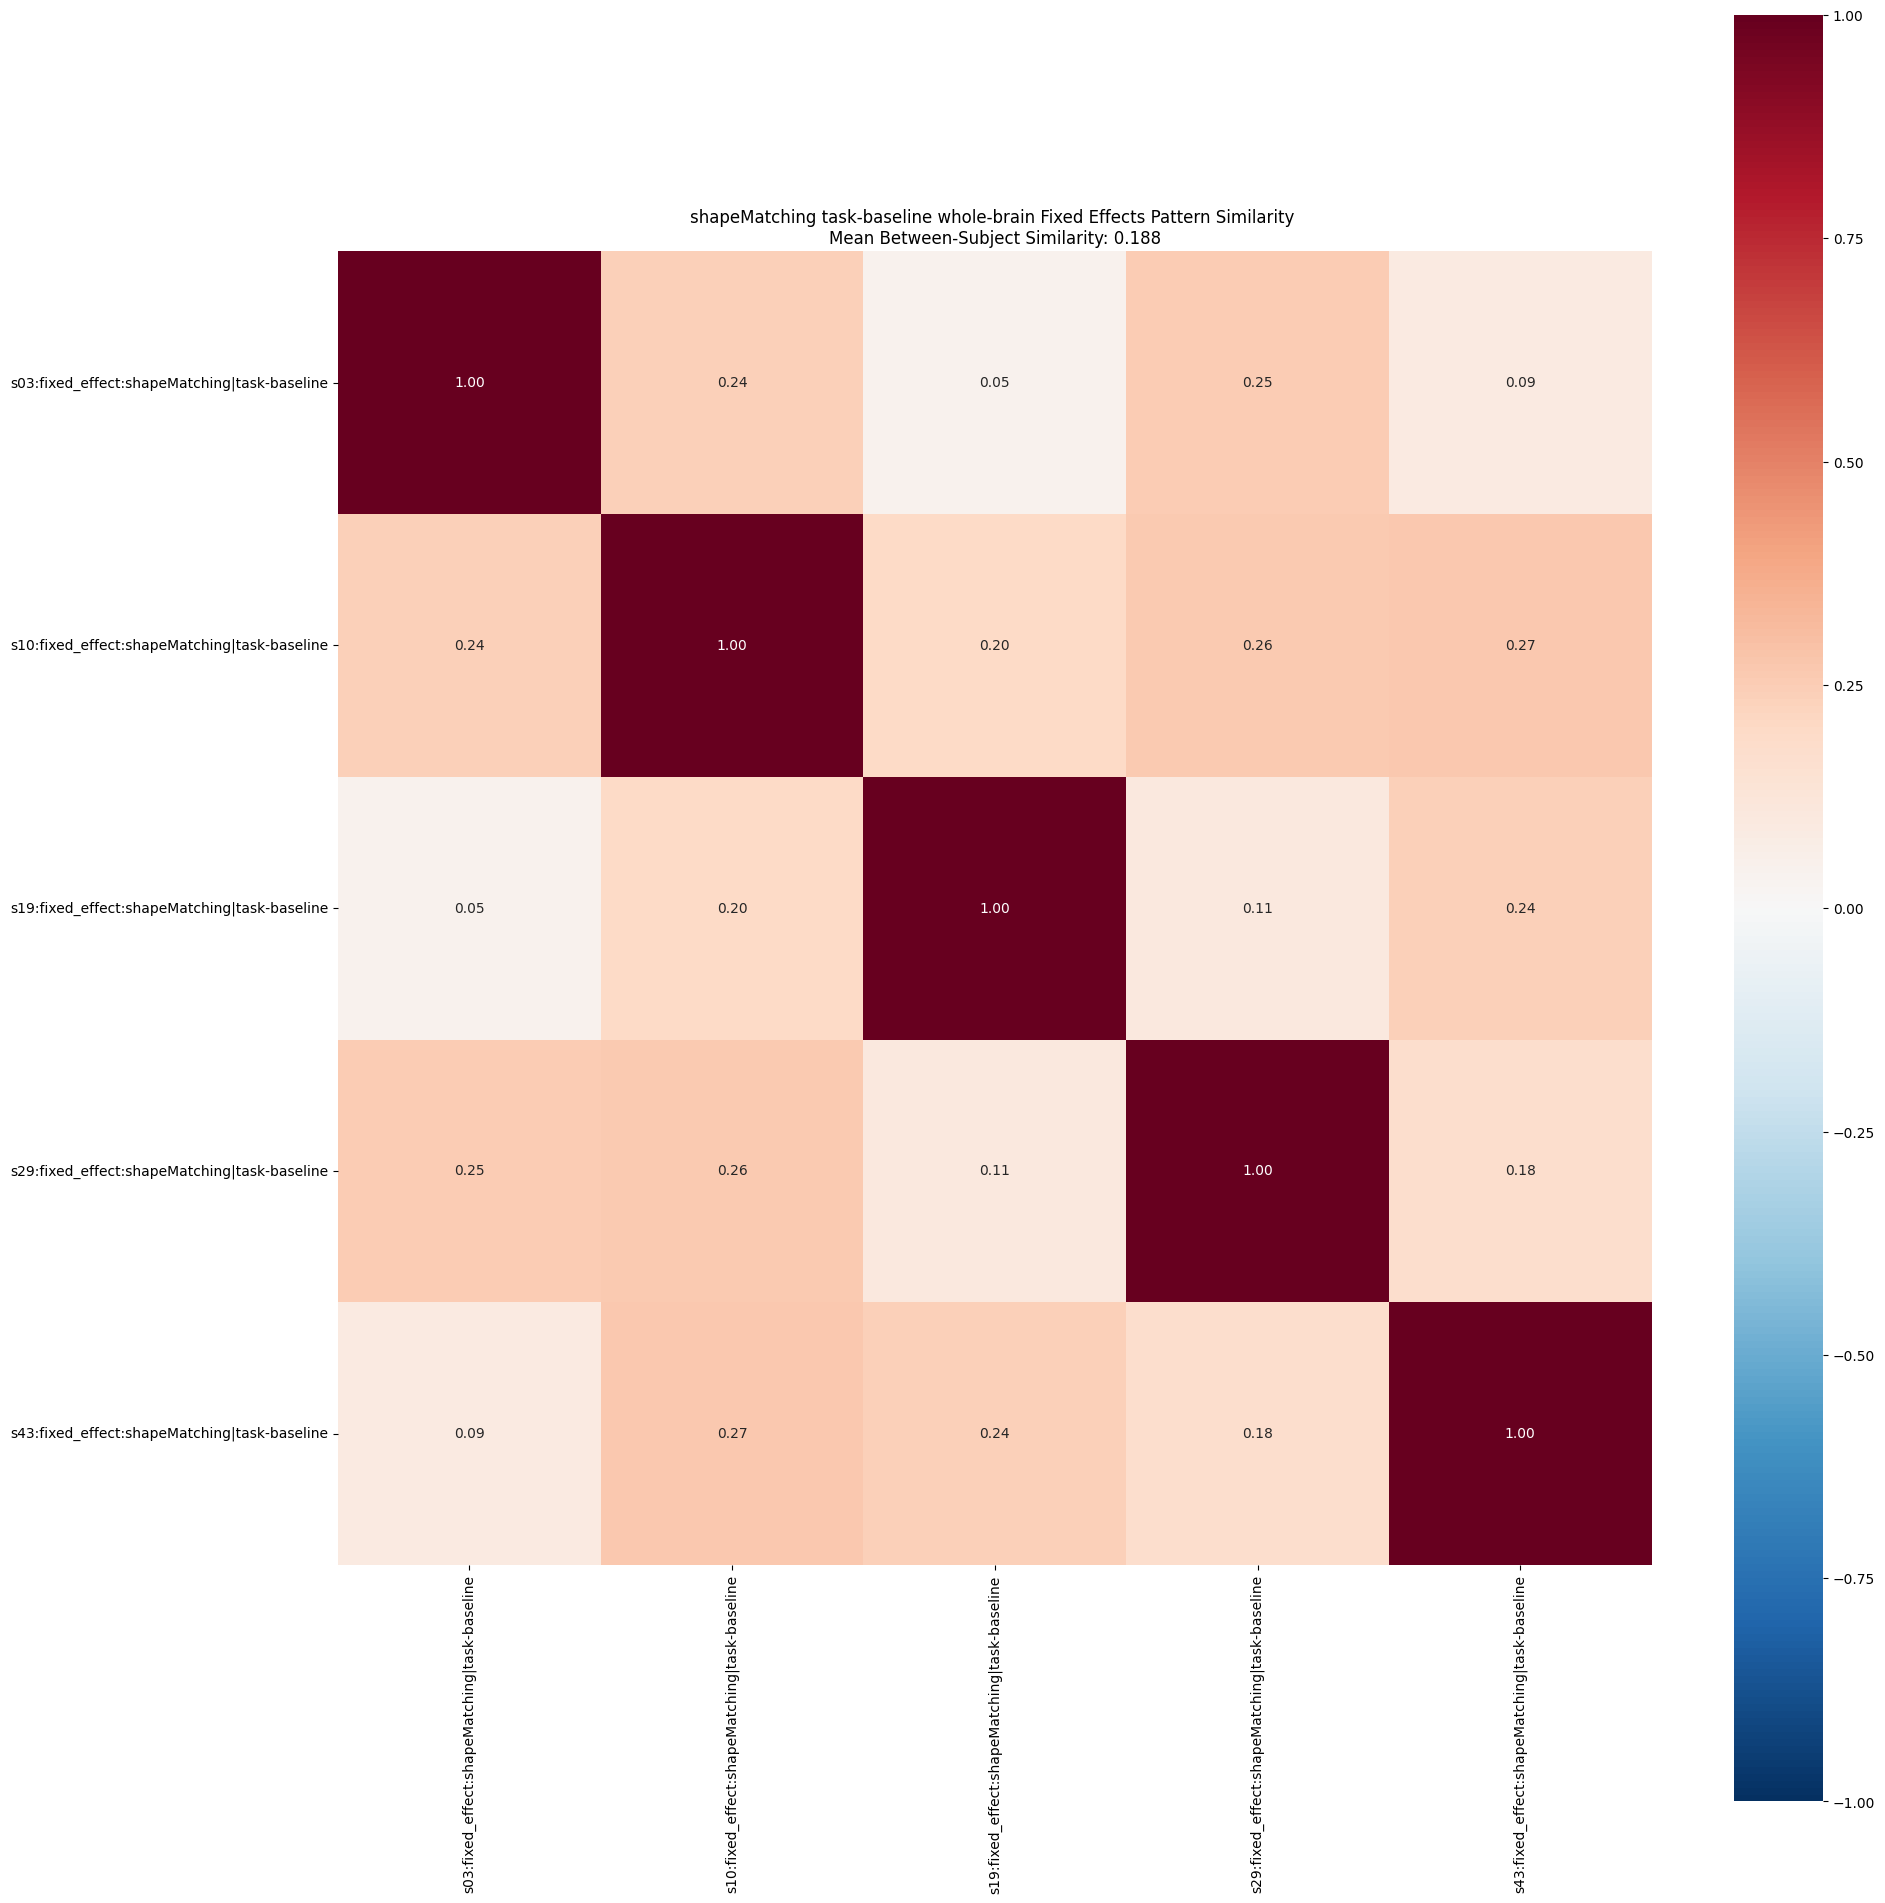

stop_failure-go: 5 maps loaded
  Map shape: (97, 115, 97)
task-baseline: 5 maps loaded
  Map shape: (97, 115, 97)
loading and binarizing whole-brain...
visualizing whole-brain


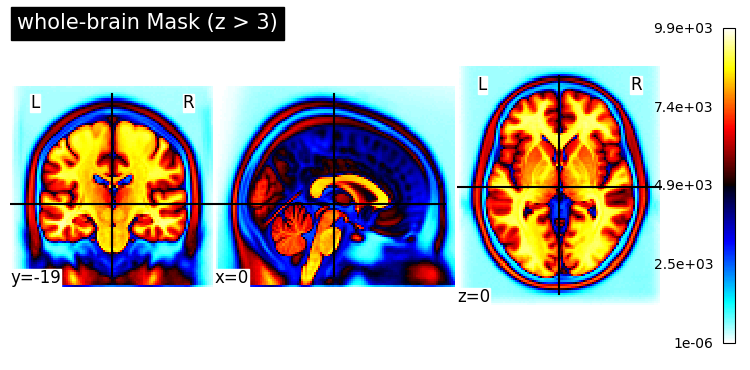

resampling for whole-brain
Neurosynth binary shape: (97, 115, 97)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled whole-brain binary for stopSignal
loading and binarizing response-inhibition...
visualizing response-inhibition


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


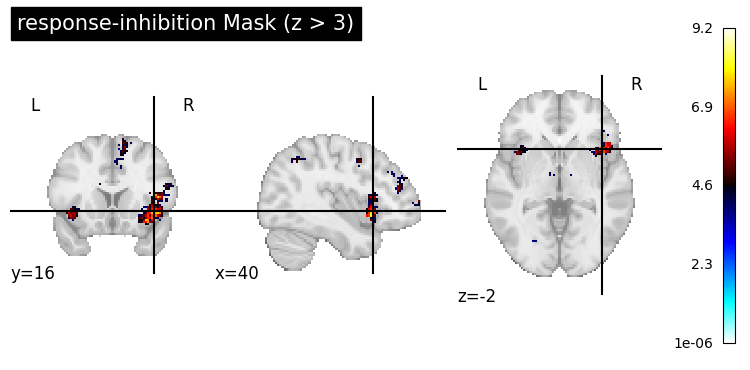

resampling for response-inhibition
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled response-inhibition binary for stopSignal
loading and binarizing attentional-control...
visualizing attentional-control


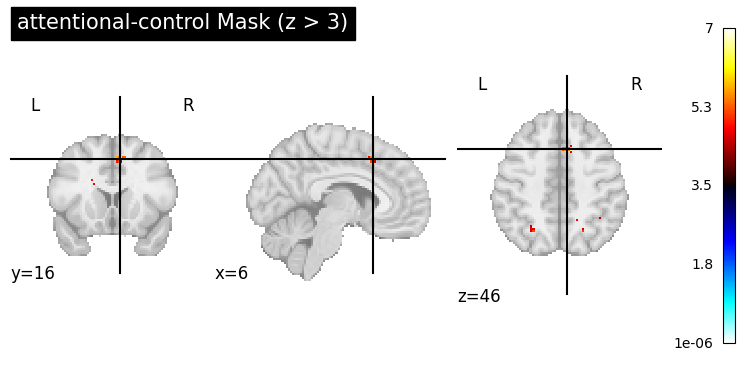

resampling for attentional-control
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled attentional-control binary for stopSignal
ROIs not found are:
rifg
pre-sma
rIFG mask: 901 voxels
pre-SMA mask: 184 voxels


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for stopSignal | stop_failure-go | whole-brain
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for stopSignal | stop_failure-go | response-inhibition
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for stopSignal | stop_failure-go | attentional-control
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for stopSignal | stop_failure-go | rifg
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for stopSignal | stop_failure-go | pre-sma
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for stopSignal | task-baseline | whole-brain
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for stopSignal | task-baseline | response-inhibition
Computing RSM for 

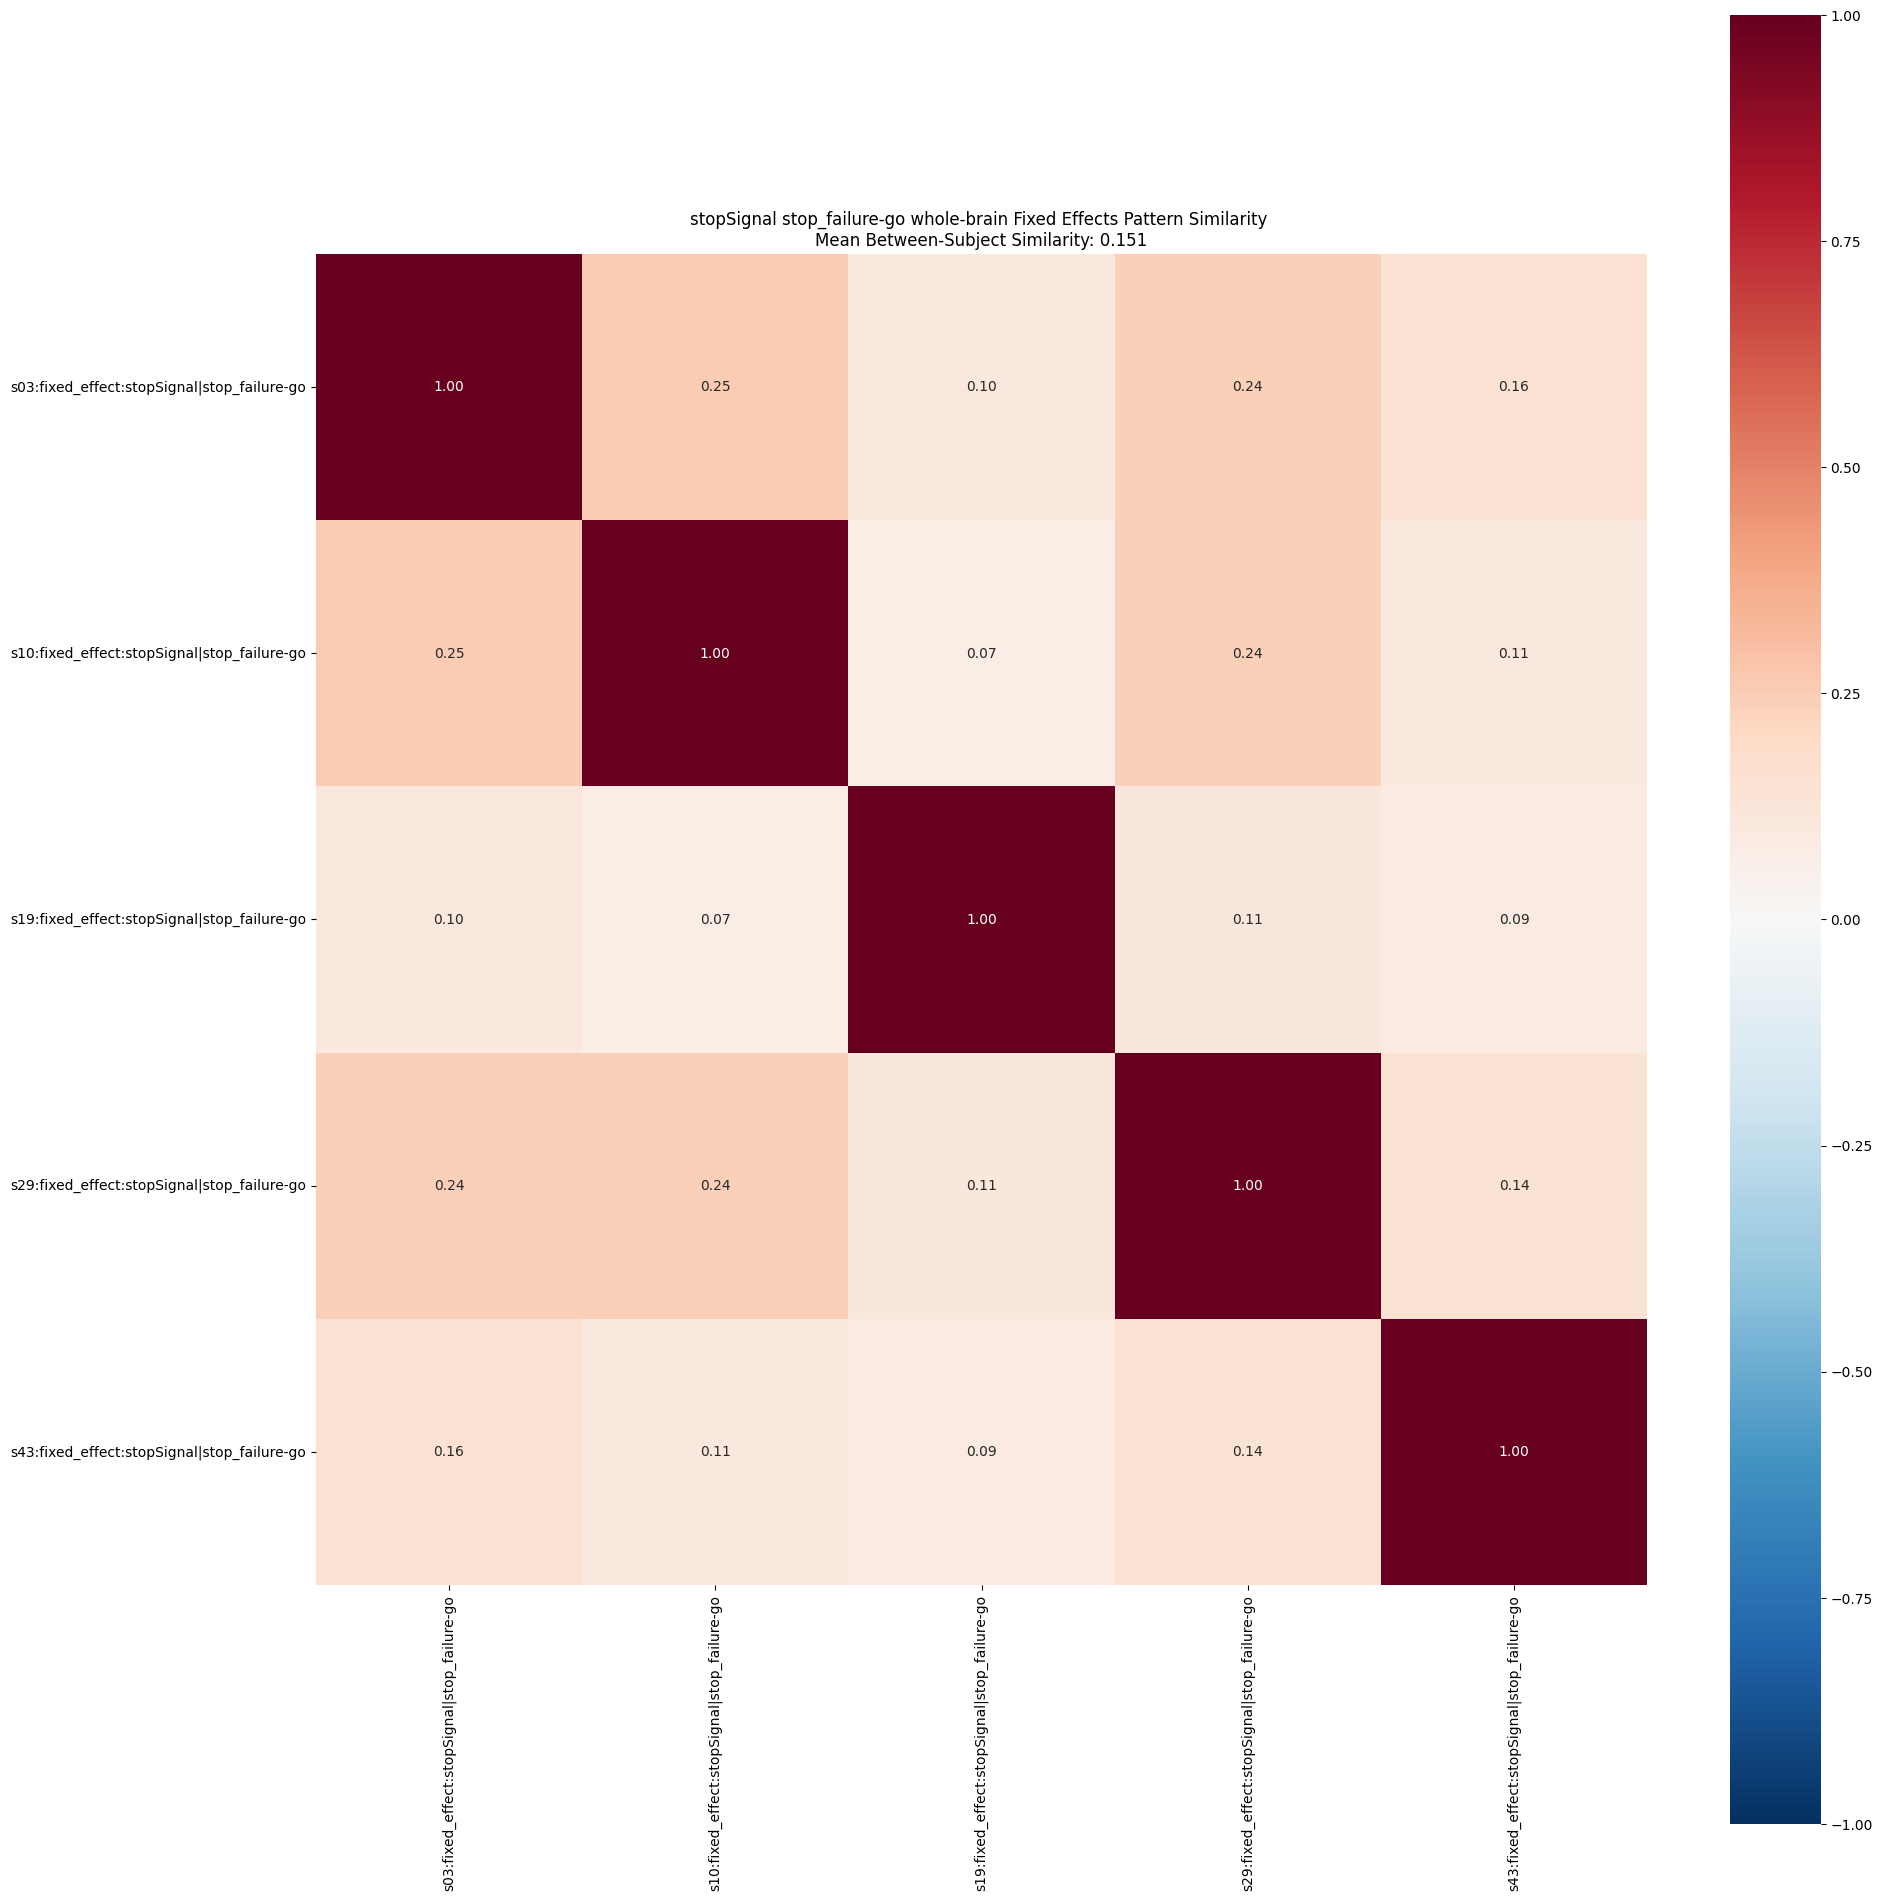

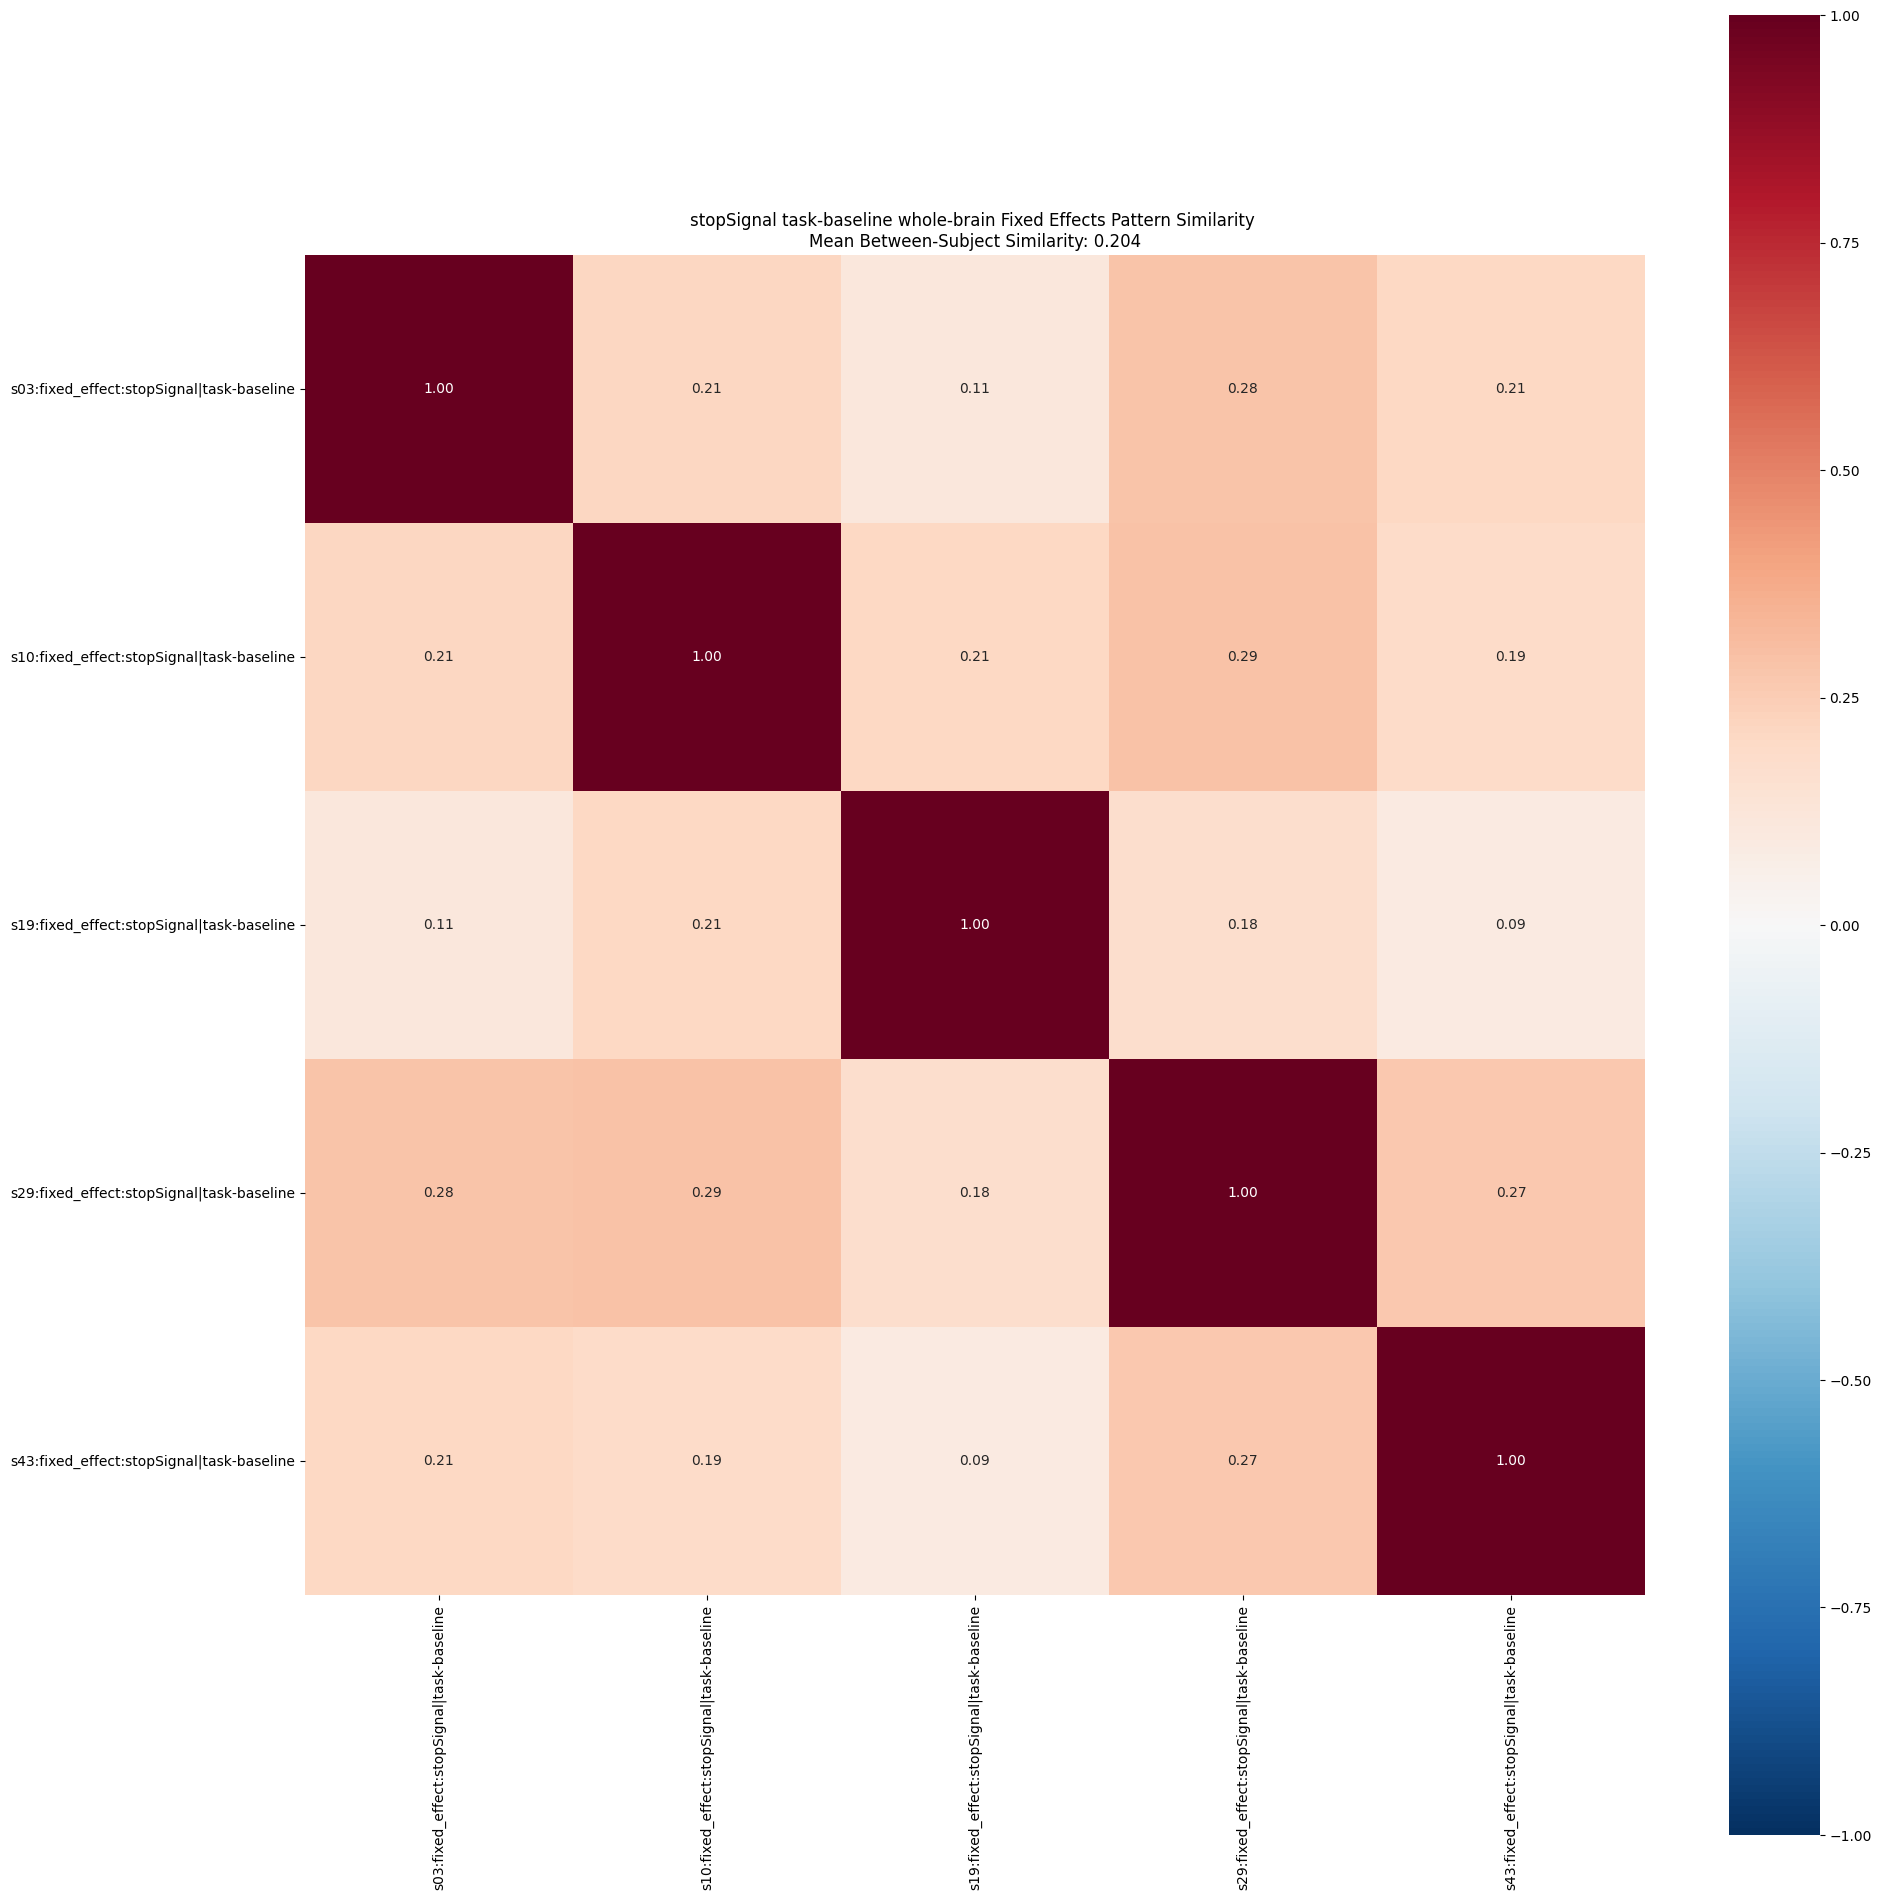

task_switch_cost: 5 maps loaded
  Map shape: (97, 115, 97)
task-baseline: 5 maps loaded
  Map shape: (97, 115, 97)
loading and binarizing whole-brain...
visualizing whole-brain


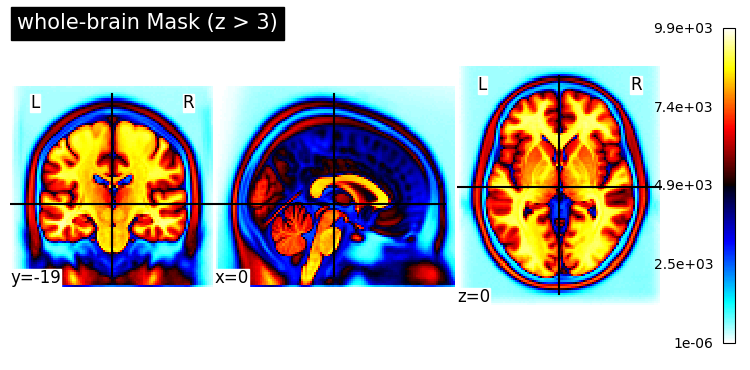

resampling for whole-brain
Neurosynth binary shape: (97, 115, 97)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled whole-brain binary for cuedTS
loading and binarizing inhibitory-control...
visualizing inhibitory-control


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


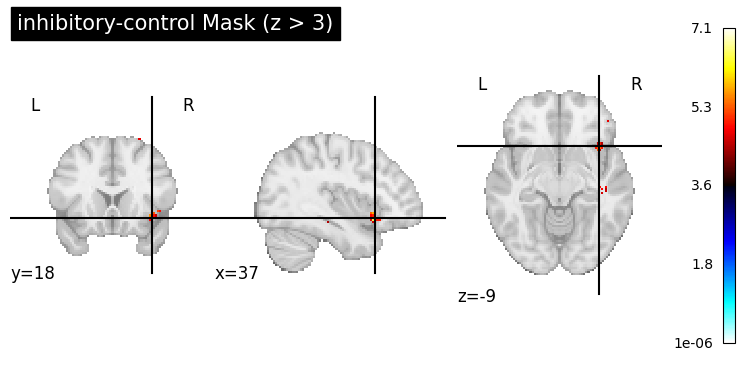

resampling for inhibitory-control
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled inhibitory-control binary for cuedTS
loading and binarizing working-memory...
visualizing working-memory


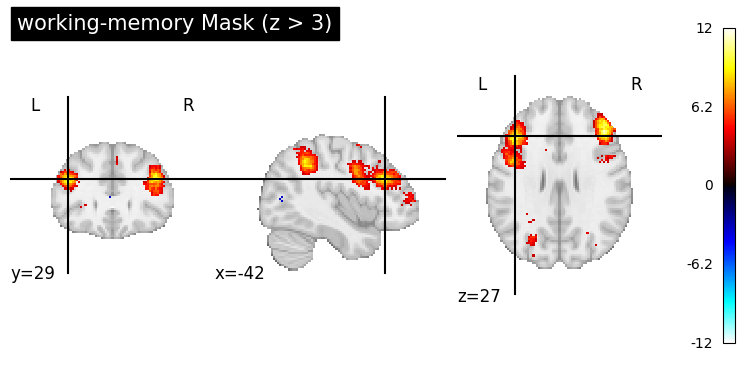

resampling for working-memory
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled working-memory binary for cuedTS
loading and binarizing attentional-control...
visualizing attentional-control


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


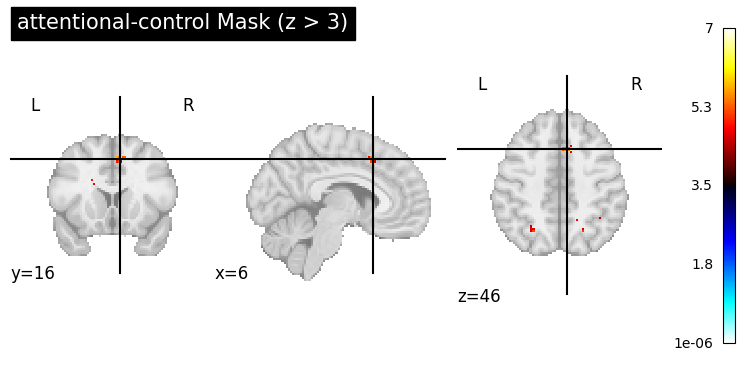

resampling for attentional-control
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled attentional-control binary for cuedTS
loading and binarizing dlpfc...
visualizing dlpfc


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


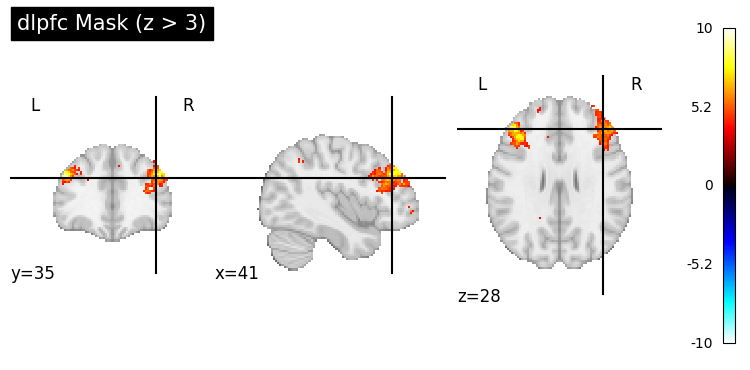

resampling for dlpfc
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled dlpfc binary for cuedTS
loading and binarizing ips...
visualizing ips


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


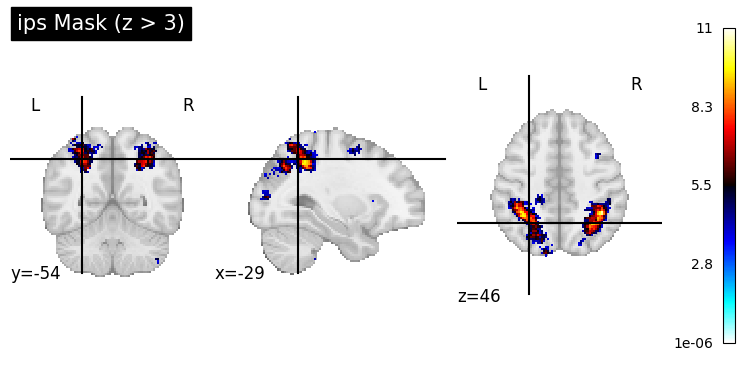

resampling for ips
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled ips binary for cuedTS


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for cuedTS | task_switch_cost | whole-brain
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for cuedTS | task_switch_cost | inhibitory-control
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for cuedTS | task_switch_cost | working-memory
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for cuedTS | task_switch_cost | attentional-control
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for cuedTS | task_switch_cost | dlpfc
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for cuedTS | task_switch_cost | ips
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for cuedTS | task-baseline | whole-brain
Computing RSM for 5 maps using pearson correlat

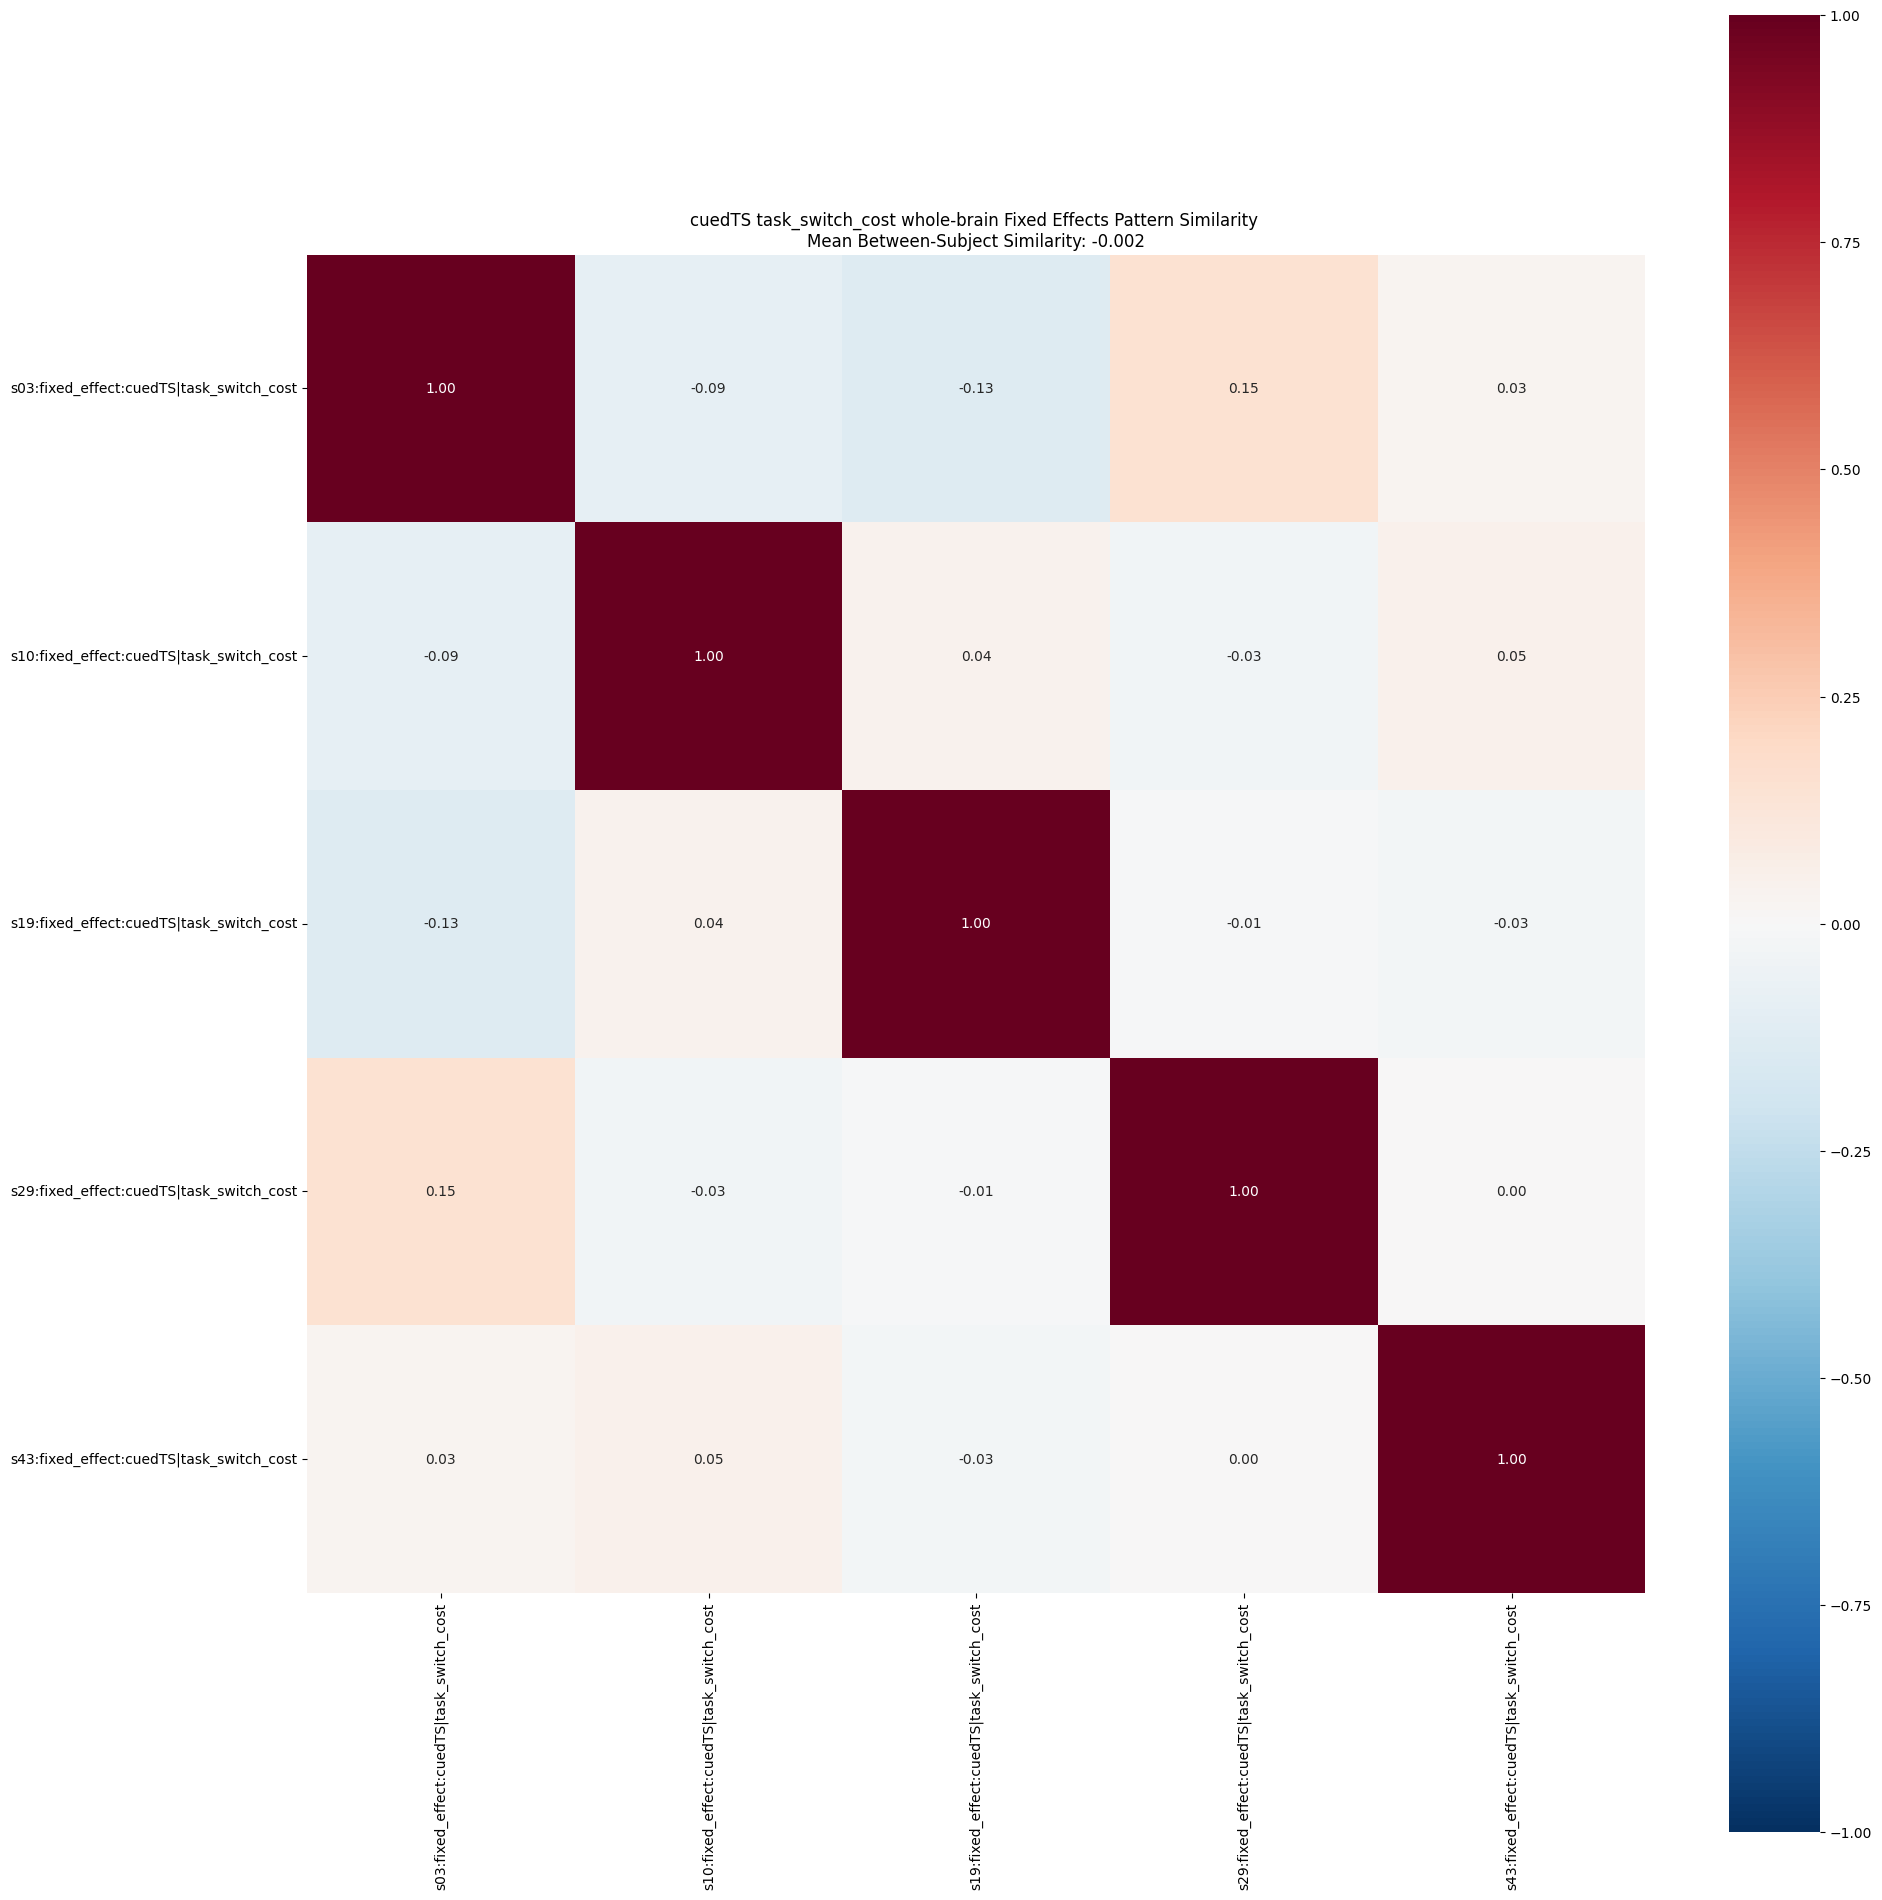

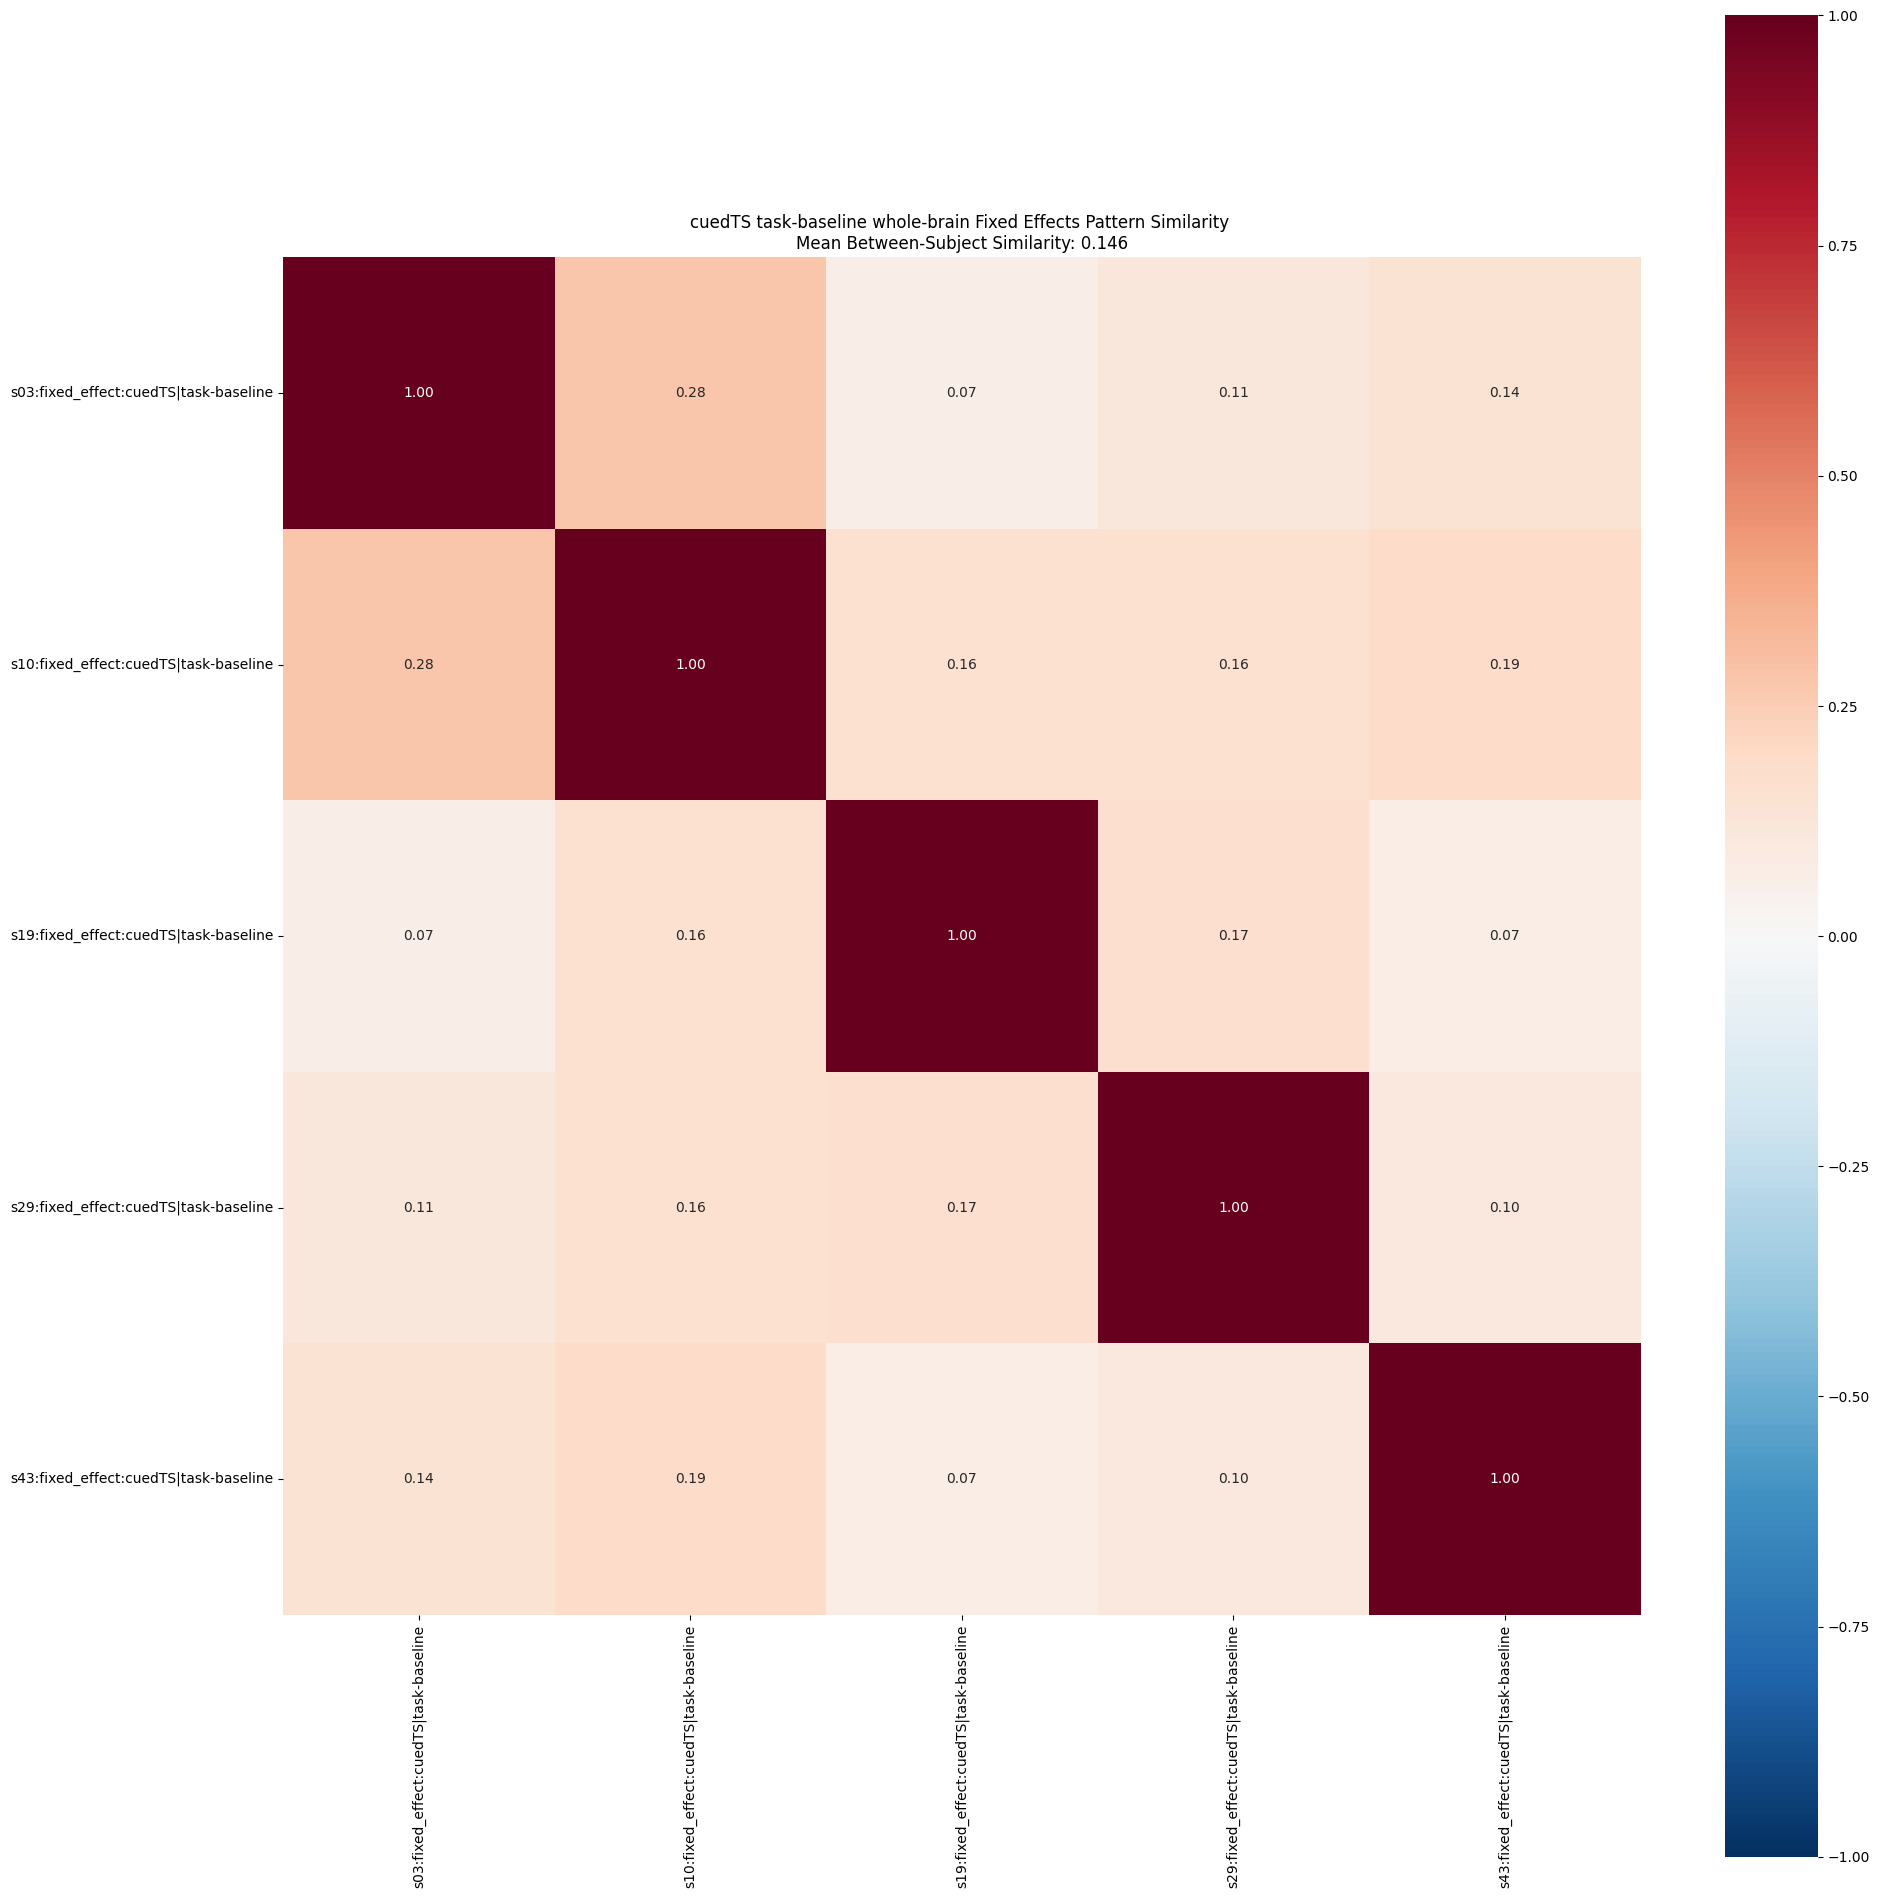

task_switch_cost: 5 maps loaded
  Map shape: (97, 115, 97)
task-baseline: 5 maps loaded
  Map shape: (97, 115, 97)
loading and binarizing whole-brain...
visualizing whole-brain


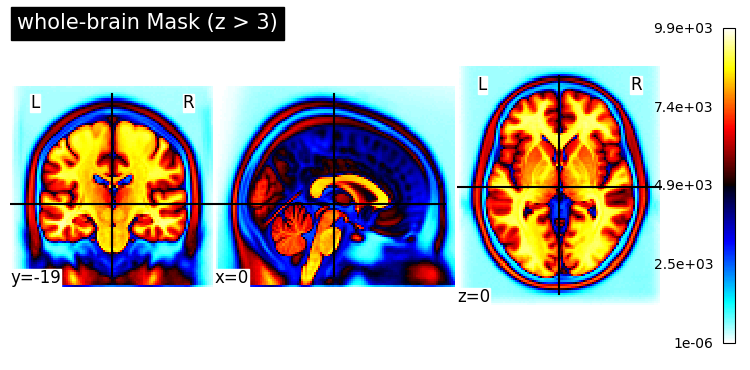

resampling for whole-brain
Neurosynth binary shape: (97, 115, 97)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled whole-brain binary for spatialTS
loading and binarizing attentional-control...
visualizing attentional-control


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


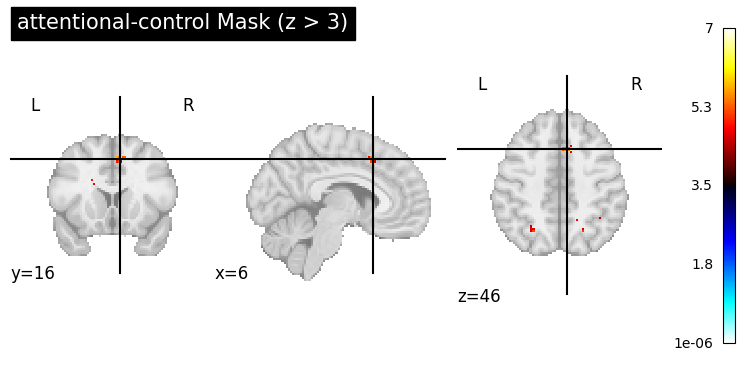

resampling for attentional-control
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled attentional-control binary for spatialTS
loading and binarizing working-memory...
visualizing working-memory


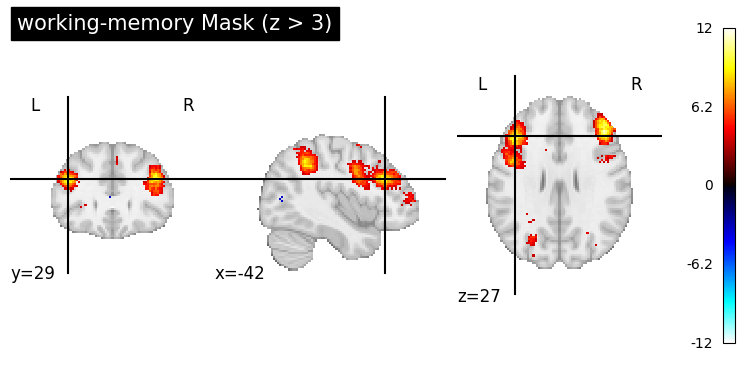

resampling for working-memory
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled working-memory binary for spatialTS
loading and binarizing inhibitory-control...
visualizing inhibitory-control


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


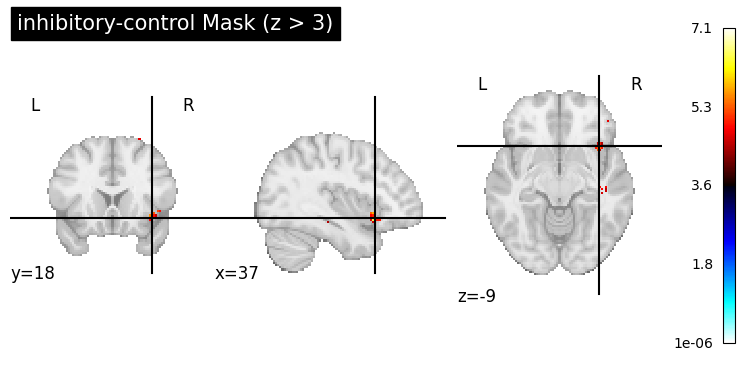

resampling for inhibitory-control
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled inhibitory-control binary for spatialTS
loading and binarizing dlpfc...
visualizing dlpfc


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


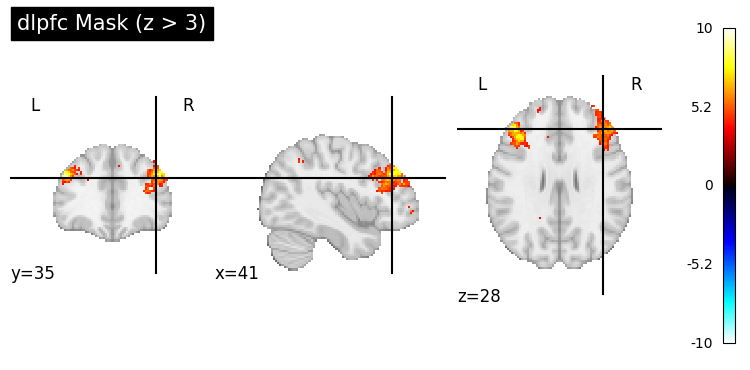

resampling for dlpfc
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled dlpfc binary for spatialTS
loading and binarizing ips...
visualizing ips


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


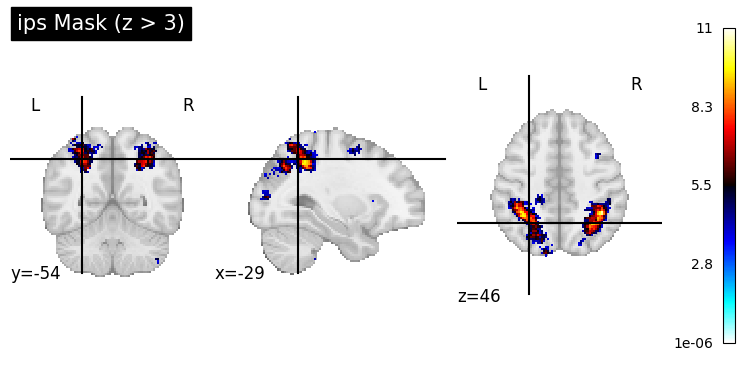

resampling for ips
Neurosynth binary shape: (91, 109, 91)
Data shape: (97, 115, 97)
Resampled neurosynth binary shape: (97, 115, 97)
saving resampled ips binary for spatialTS


/tmp/ipykernel_28787/2907756780.py:68: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  neurosynth_resampled = image.resample_to_img(neurosynth_binary, sample_map, interpolation='nearest')
/home/users/nklevak/miniconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for spatialTS | task_switch_cost | whole-brain
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for spatialTS | task_switch_cost | attentional-control
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for spatialTS | task_switch_cost | working-memory
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for spatialTS | task_switch_cost | inhibitory-control
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for spatialTS | task_switch_cost | dlpfc
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for spatialTS | task_switch_cost | ips
Computing RSM for 5 maps using pearson correlation
Successfully computed pattern-based RSMs for spatialTS | task-baseline | whole-brain
Computing RSM for 5 maps u

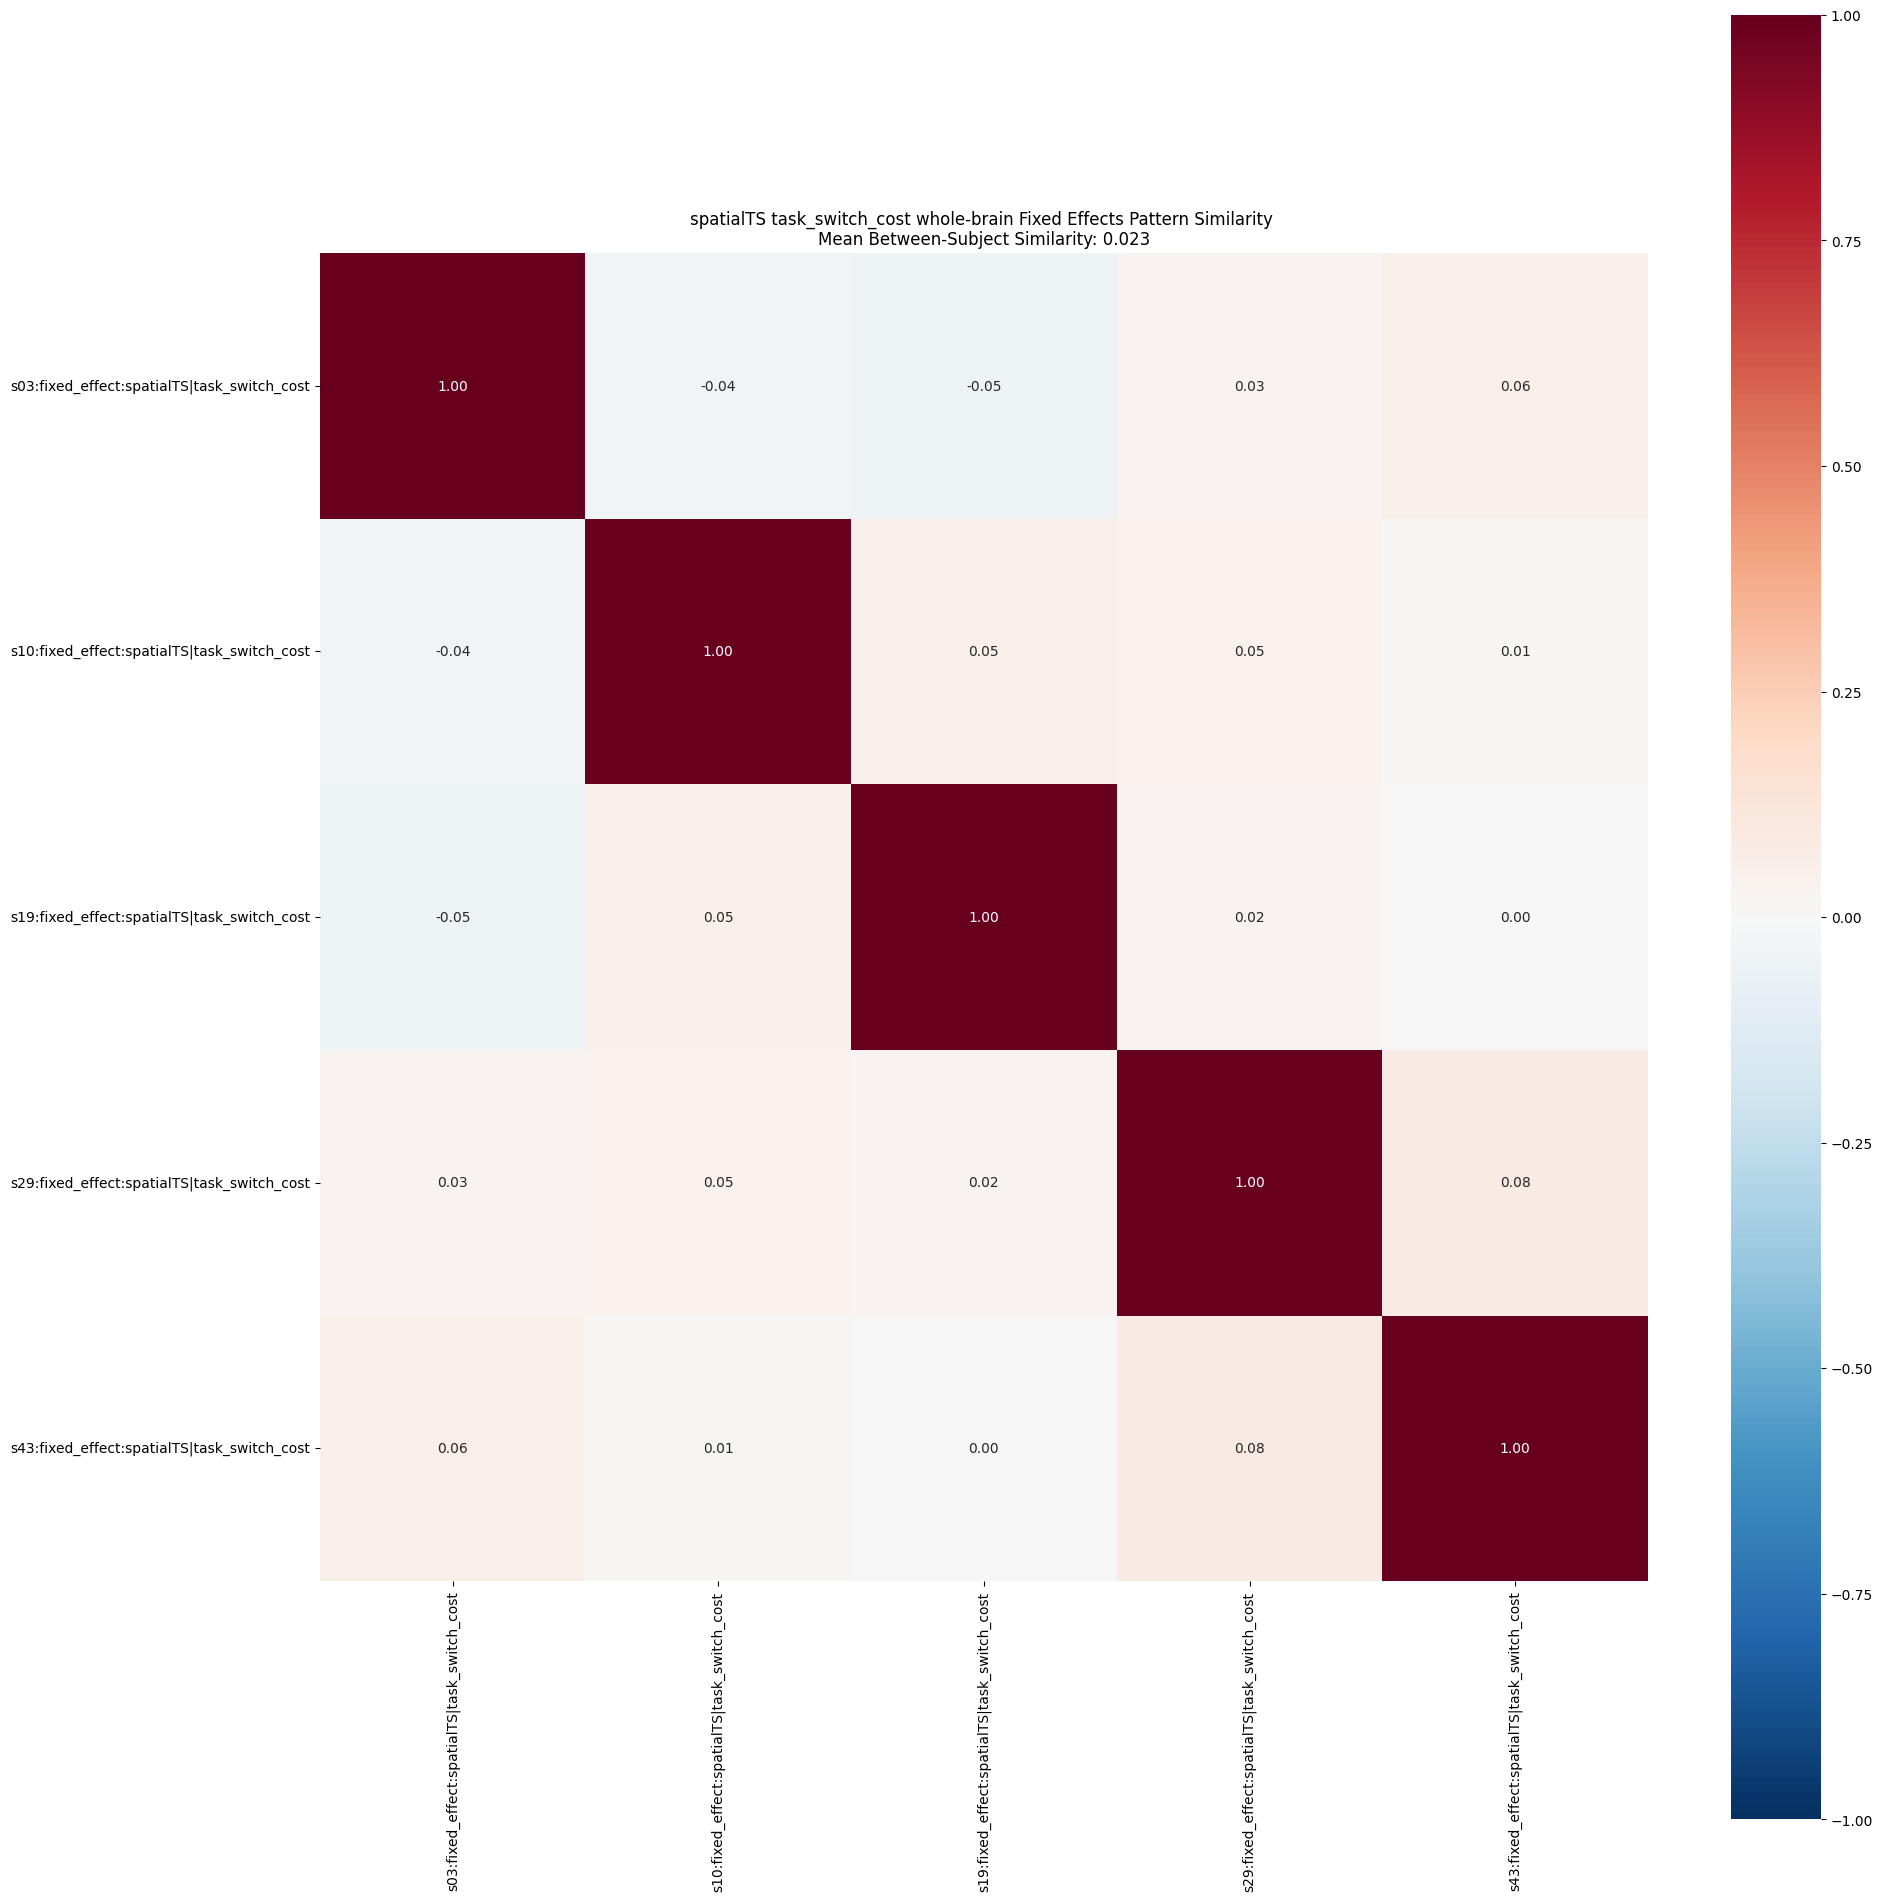

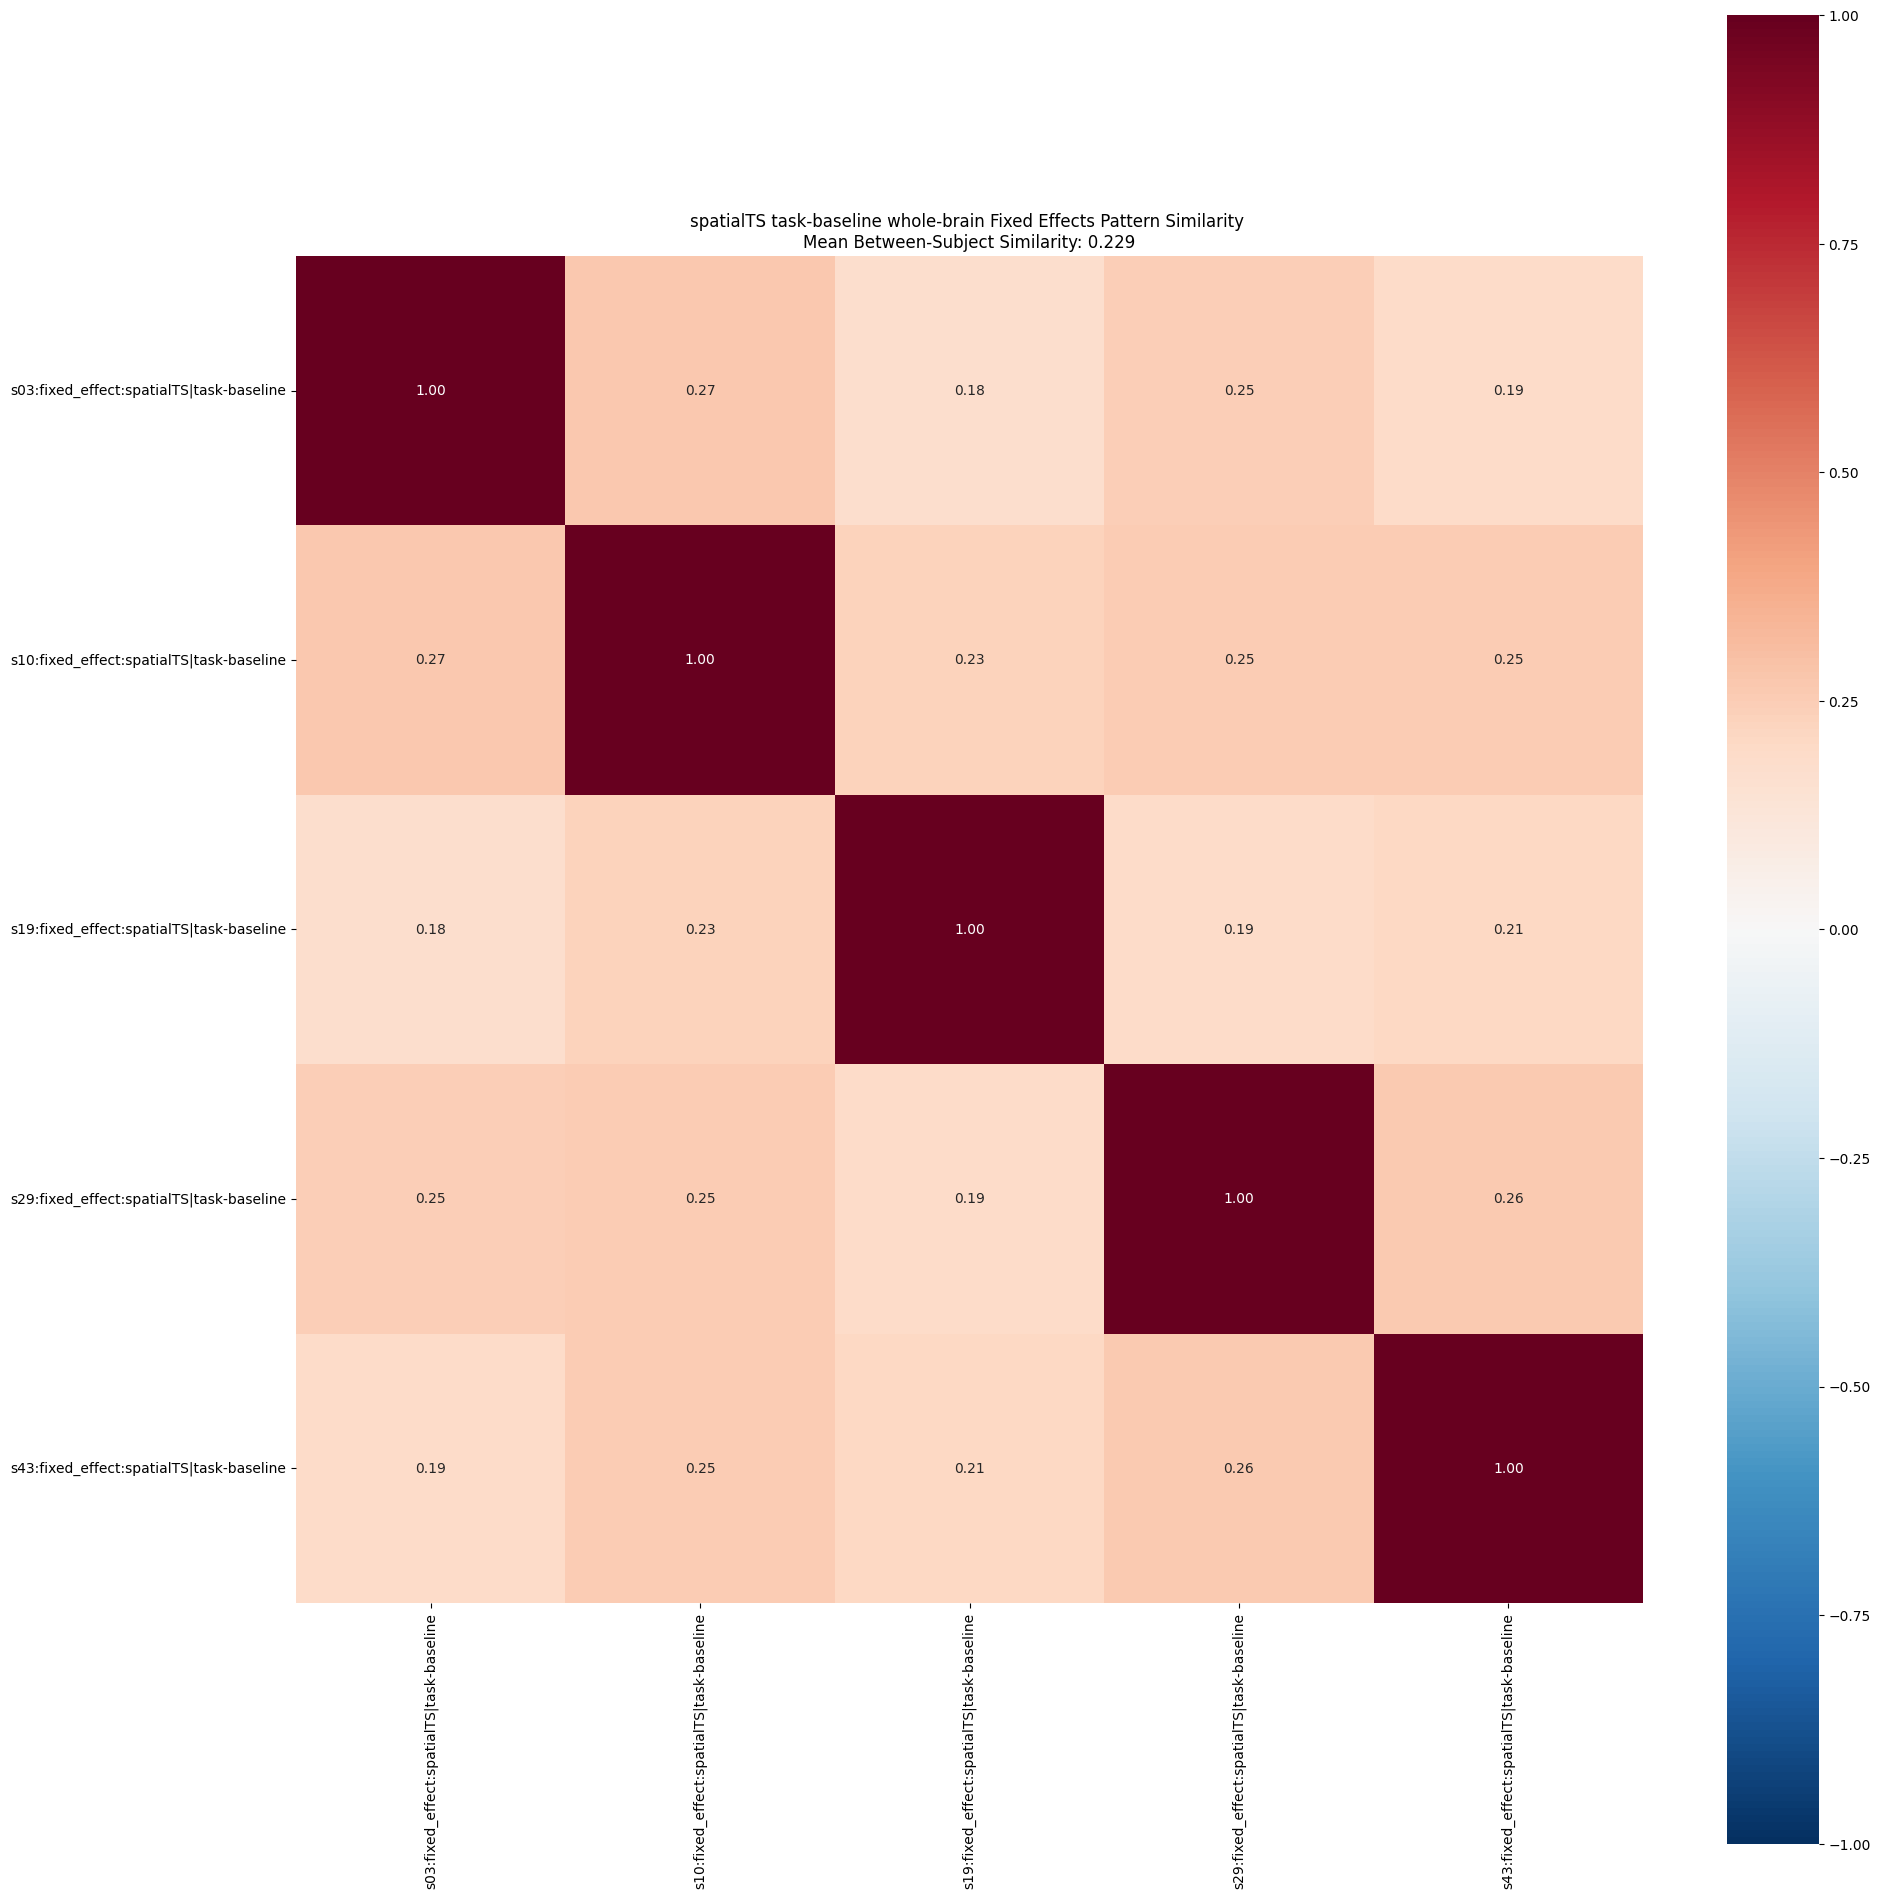

In [26]:
# get the task specific data paths and load them all

for task in fe_task_contrast_all_maps:
    
    curr_task = task
    
    # Check data dimensions for each contrast
    for contrast in fe_task_contrast_all_maps[curr_task]:
        maps = fe_task_contrast_all_maps[curr_task][contrast]["maps_list"]
        print(f"{contrast}: {len(maps)} maps loaded")
        if maps:
            print(f"  Map shape: {maps[0].shape}")
    
    # load the rois (that we don't have to create)
    resampled_rois,missing_rois = load_neurosynth_rois(curr_task, fe_task_contrast_all_maps)
    
    if (len(missing_rois) > 0):
        resampled_rois, missing_rois = add_custom_rois(curr_task,resampled_rois, missing_rois)
    
    # Mask the contrast maps with all of the masks
    masked_maps = {}
    masked_maps[curr_task] = {}
    
    for contrast in fe_task_contrast_all_maps[curr_task]:
        masked_maps[curr_task][contrast] = {}
        
        for roi_name in resampled_rois[curr_task]:
            #  # only focuses on whole brain here:
            # if (roi_name != "whole-brain"):
            #     continue
                
            masked_maps[curr_task][contrast][roi_name] = []
            
            resampled_roi_mask = resampled_rois[curr_task][roi_name].get_fdata().astype(bool)
            
            for map in fe_task_contrast_all_maps[curr_task][contrast]["maps_list"]:
                map_array = map.get_fdata()
                masked_maps[curr_task][contrast][roi_name].append(map_array[resampled_roi_mask])
                
        # print(f"Extracted {len(masked_maps[curr_task][contrast][roi_name])} values for each ROI for {contrast} in {curr_task}") 
    
    # Get the pattern based rsms for each contrast
    pearson_rsm_results = {}
    pearson_rsm_results[curr_task] = {}
    
    for contrast in masked_maps[curr_task]:
        pearson_rsm_results[curr_task][contrast] = {}
        for roi_name in masked_maps[curr_task][contrast]:
            maps = masked_maps[curr_task][contrast][roi_name]
    
            pearson_rsm_results[curr_task][contrast][roi_name] = compute_rsms(
                maps,
                fe_task_contrast_all_maps[curr_task][contrast]["descriptors_list"],
                f"{curr_task} | {contrast} | {roi_name}"
            )

            # Get RSM data
            rsm_result_tuple = pearson_rsm_results[task][contrast][roi_name]
            rsm_dict = rsm_result_tuple[0]
            # Get the title key
            full_title = list(rsm_dict.keys())[0]
            rsm_data = rsm_dict[full_title]['rsm']
    
            # get the correlation to add to the fe_corrs_dict
            overall_mean_sim = calculate_fe_between_subject_similarity(rsm_data, fe_task_contrast_all_maps[task][contrast]["descriptors_list"])
            fe_corrs_dict[task][contrast]['brain_roi'].append(roi_name)
            fe_corrs_dict[task][contrast]['corrs'].append(overall_mean_sim)
    
    # Plot all ROIs for a specific contrast/task
    roi_names = requested_task_rois[curr_task]
    
    # only foccuses on whole brain here:
    roi_names = ["whole-brain"]
    
    for contrast in masked_maps[curr_task]:
        plot_rsm_heatmaps(pearson_rsm_results, curr_task, contrast, roi_names, SUBJECTS, fe_task_contrast_all_maps, FIGSIZE = (20, 20),fixed_effects = True)

In [29]:
# save the fe correlations dict to a file:
print(fe_corrs_dict)

# Convert defaultdict to a regular dict to save it
fe_corrs_dict_regular = convert_to_regular_dict(fe_corrs_dict)
# Save converted dict
with open('correlation_analysis_results/fe_corrs_dict.pkl', 'wb') as f:
    pickle.dump(fe_corrs_dict_regular, f)

defaultdict(<function <lambda> at 0x7f10747c7af0>, {'nBack': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f10719c1c10>, {'twoBack-oneBack': {'brain_roi': ['whole-brain', 'whole-brain', 'working-memory', 'attentional-control', 'dlpfc', 'ips'], 'corrs': [0.07866084643433041, 0.07866084643433041, 0.3196300515475999, 0.4474866829251495, 0.2748079822761948, 0.34761332962602143]}, 'task-baseline': {'brain_roi': ['whole-brain', 'whole-brain', 'working-memory', 'attentional-control', 'dlpfc', 'ips'], 'corrs': [0.27271095596421585, 0.27271095596421585, 0.2557523364115544, 0.15418413882720322, 0.12306915636499252, 0.3767119059950737]}}), 'flanker': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f1071a66dc0>, {'incongruent-congruent': {'brain_roi': ['whole-brain', 'whole-brain', 'inhibitory-control', 'dlpfc', 'acc', 'ips'], 'corrs': [7.637880582349581e-05, 7.637880582349581e-05, 0.02867637604013677, 0.08751865645498175, 0.12445083680716862, 0.0205211877860148]}, 'task-baseline':

# analyzing per task/contrast/relevant ROI

In [ ]:
# load all of the maps in an organized dict and see which maps are missing per task
task_contrast_all_maps = gather_tc_maps_full_task(req_tasks_contrasts = requested_task_contrasts,create_subset=False)

## go no go

In [ ]:
# get the go  no go specific data paths and load them all
curr_task = "goNogo"

# Check data dimensions for each contrast
for contrast in task_contrast_all_maps[curr_task]:
    maps = task_contrast_all_maps[curr_task][contrast]["maps_list"]
    print(f"{contrast}: {len(maps)} maps loaded")
    if maps:
        print(f"  Map shape: {maps[0].shape}")

# load the rois (that we don't have to create)
resampled_rois,missing_rois = load_neurosynth_rois(curr_task, task_contrast_all_maps)

if (len(missing_rois) > 0):
    resampled_rois, missing_rois = add_custom_rois(curr_task,resampled_rois, missing_rois)

# Mask the contrast maps with all of the masks
masked_maps = {}
masked_maps[curr_task] = {}

for contrast in task_contrast_all_maps[curr_task]:
    masked_maps[curr_task][contrast] = {}
    
    for roi_name in resampled_rois[curr_task]:
        masked_maps[curr_task][contrast][roi_name] = []
        
        resampled_roi_mask = resampled_rois[curr_task][roi_name].get_fdata().astype(bool)
        
        for map in task_contrast_all_maps[curr_task][contrast]["maps_list"]:
            map_array = map.get_fdata()
            masked_maps[curr_task][contrast][roi_name].append(map_array[resampled_roi_mask])
            
    print(f"Extracted {len(masked_maps[curr_task][contrast][roi_name])} values for each ROI for {contrast} in {curr_task}") 

# Get the pattern based rsms for each contrast
pearson_rsm_results = {}
pearson_rsm_results[curr_task] = {}

for contrast in masked_maps[curr_task]:
    pearson_rsm_results[curr_task][contrast] = {}
    for roi_name in masked_maps[curr_task][contrast]:
        maps = masked_maps[curr_task][contrast][roi_name]

        pearson_rsm_results[curr_task][contrast][roi_name] = compute_rsms(
            maps,
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"],
            f"{curr_task} | {contrast} | {roi_name}"
        )

# Plot all ROIs for a specific contrast/task
roi_names = requested_task_rois[curr_task]
for contrast in masked_maps[curr_task]:
    plot_rsm_heatmaps(pearson_rsm_results, curr_task, contrast, roi_names, SUBJECTS, task_contrast_all_maps)

### TODO (copy from 5_identify...ipynb) visualizing changes in spatial similarity across encounters

## flanker

In [ ]:
# get the flanker specific data paths and load them all
curr_task = "flanker"
curr_task_maps = task_contrast_all_maps[curr_task]

# Check data dimensions for each contrast
for contrast in task_contrast_all_maps[curr_task]:
    maps = task_contrast_all_maps[curr_task][contrast]["maps_list"]
    print(f"{contrast}: {len(maps)} maps loaded")
    if maps:
        print(f"  Map shape: {maps[0].shape}")

# load the rois (that we don't have to create)
resampled_rois,missing_rois = load_neurosynth_rois(curr_task, task_contrast_all_maps)

if (len(missing_rois) > 0):
    resampled_rois, missing_rois = add_custom_rois(curr_task,resampled_rois, missing_rois)

# Mask the contrast maps with all of the masks
masked_maps = {}
masked_maps[curr_task] = {}

for contrast in task_contrast_all_maps[curr_task]:
    masked_maps[curr_task][contrast] = {}
    
    for roi_name in resampled_rois[curr_task]:
        masked_maps[curr_task][contrast][roi_name] = []
        
        resampled_roi_mask = resampled_rois[curr_task][roi_name].get_fdata().astype(bool)
        
        for map in task_contrast_all_maps[curr_task][contrast]["maps_list"]:
            map_array = map.get_fdata()
            masked_maps[curr_task][contrast][roi_name].append(map_array[resampled_roi_mask])
            
    print(f"Extracted {len(masked_maps[curr_task][contrast][roi_name])} values for each ROI for {contrast} in {curr_task}") 

# Get the pattern based rsms for each contrast
pearson_rsm_results = {}
pearson_rsm_results[curr_task] = {}

for contrast in masked_maps[curr_task]:
    pearson_rsm_results[curr_task][contrast] = {}
    for roi_name in masked_maps[curr_task][contrast]:
        maps = masked_maps[curr_task][contrast][roi_name]

        pearson_rsm_results[curr_task][contrast][roi_name] = compute_rsms(
            maps,
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"],
            f"{curr_task} | {contrast} | {roi_name}"
        )

# Plot all ROIs for a specific contrast/task
roi_names = requested_task_rois[curr_task]
for contrast in masked_maps[curr_task]:
    plot_rsm_heatmaps(pearson_rsm_results, curr_task, contrast, roi_names, SUBJECTS, task_contrast_all_maps, FIGSIZE=(60,60))

## directed forgetting

In [ ]:
# get the directedForgetting specific data paths and load them all
curr_task = "directedForgetting"
curr_task_maps = task_contrast_all_maps[curr_task]

# Check data dimensions for each contrast
for contrast in task_contrast_all_maps[curr_task]:
    maps = task_contrast_all_maps[curr_task][contrast]["maps_list"]
    print(f"{contrast}: {len(maps)} maps loaded")
    if maps:
        print(f"  Map shape: {maps[0].shape}")

# load the rois (that we don't have to create)
resampled_rois,missing_rois = load_neurosynth_rois(curr_task, task_contrast_all_maps)

if (len(missing_rois) > 0):
    resampled_rois, missing_rois = add_custom_rois(curr_task,resampled_rois, missing_rois)

# Mask the contrast maps with all of the masks
masked_maps = {}
masked_maps[curr_task] = {}

for contrast in task_contrast_all_maps[curr_task]:
    masked_maps[curr_task][contrast] = {}
    
    for roi_name in resampled_rois[curr_task]:
        masked_maps[curr_task][contrast][roi_name] = []
        
        resampled_roi_mask = resampled_rois[curr_task][roi_name].get_fdata().astype(bool)
        
        for map in task_contrast_all_maps[curr_task][contrast]["maps_list"]:
            map_array = map.get_fdata()
            masked_maps[curr_task][contrast][roi_name].append(map_array[resampled_roi_mask])
            
    print(f"Extracted {len(masked_maps[curr_task][contrast][roi_name])} values for each ROI for {contrast} in {curr_task}") 

# Get the pattern based rsms for each contrast
pearson_rsm_results = {}
pearson_rsm_results[curr_task] = {}

for contrast in masked_maps[curr_task]:
    pearson_rsm_results[curr_task][contrast] = {}
    for roi_name in masked_maps[curr_task][contrast]:
        maps = masked_maps[curr_task][contrast][roi_name]

        pearson_rsm_results[curr_task][contrast][roi_name] = compute_rsms(
            maps,
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"],
            f"{curr_task} | {contrast} | {roi_name}"
        )

# Plot all ROIs for a specific contrast/task
roi_names = requested_task_rois[curr_task]
for contrast in masked_maps[curr_task]:
    plot_rsm_heatmaps(pearson_rsm_results, curr_task, contrast, roi_names, SUBJECTS,task_contrast_all_maps, FIGSIZE=(60,60))

## nBack

In [ ]:
# get the nBack specific data paths and load them all
curr_task = "nBack"
curr_task_maps = task_contrast_all_maps[curr_task]

# Check data dimensions for each contrast
for contrast in task_contrast_all_maps[curr_task]:
    maps = task_contrast_all_maps[curr_task][contrast]["maps_list"]
    print(f"{contrast}: {len(maps)} maps loaded")
    if maps:
        print(f"  Map shape: {maps[0].shape}")

# load the rois (that we don't have to create)
resampled_rois,missing_rois = load_neurosynth_rois(curr_task, task_contrast_all_maps)

if (len(missing_rois) > 0):
    resampled_rois, missing_rois = add_custom_rois(curr_task,resampled_rois, missing_rois)

# Mask the contrast maps with all of the masks
masked_maps = {}
masked_maps[curr_task] = {}

for contrast in task_contrast_all_maps[curr_task]:
    masked_maps[curr_task][contrast] = {}
    
    for roi_name in resampled_rois[curr_task]:
        masked_maps[curr_task][contrast][roi_name] = []
        
        resampled_roi_mask = resampled_rois[curr_task][roi_name].get_fdata().astype(bool)
        
        for map in task_contrast_all_maps[curr_task][contrast]["maps_list"]:
            map_array = map.get_fdata()
            masked_maps[curr_task][contrast][roi_name].append(map_array[resampled_roi_mask])
            
    print(f"Extracted {len(masked_maps[curr_task][contrast][roi_name])} values for each ROI for {contrast} in {curr_task}") 

# Get the pattern based rsms for each contrast
pearson_rsm_results = {}
pearson_rsm_results[curr_task] = {}

for contrast in masked_maps[curr_task]:
    pearson_rsm_results[curr_task][contrast] = {}
    for roi_name in masked_maps[curr_task][contrast]:
        maps = masked_maps[curr_task][contrast][roi_name]

        pearson_rsm_results[curr_task][contrast][roi_name] = compute_rsms(
            maps,
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"],
            f"{curr_task} | {contrast} | {roi_name}"
        )

# Plot all ROIs for a specific contrast/task
roi_names = requested_task_rois[curr_task]
for contrast in masked_maps[curr_task]:
    plot_rsm_heatmaps(pearson_rsm_results, curr_task, contrast, roi_names, SUBJECTS, task_contrast_all_maps, FIGSIZE=(60,60))

## shape matching

In [ ]:
# get the shapeMatching specific data paths and load them all
curr_task = "shapeMatching"
curr_task_maps = task_contrast_all_maps[curr_task]

# Check data dimensions for each contrast
for contrast in task_contrast_all_maps[curr_task]:
    maps = task_contrast_all_maps[curr_task][contrast]["maps_list"]
    print(f"{contrast}: {len(maps)} maps loaded")
    if maps:
        print(f"  Map shape: {maps[0].shape}")

# load the rois (that we don't have to create)
resampled_rois,missing_rois = load_neurosynth_rois(curr_task, task_contrast_all_maps)

if (len(missing_rois) > 0):
    resampled_rois, missing_rois = add_custom_rois(curr_task,resampled_rois, missing_rois)

# Mask the contrast maps with all of the masks
masked_maps = {}
masked_maps[curr_task] = {}

for contrast in task_contrast_all_maps[curr_task]:
    masked_maps[curr_task][contrast] = {}
    
    for roi_name in resampled_rois[curr_task]:
        masked_maps[curr_task][contrast][roi_name] = []
        
        resampled_roi_mask = resampled_rois[curr_task][roi_name].get_fdata().astype(bool)
        
        for map in task_contrast_all_maps[curr_task][contrast]["maps_list"]:
            map_array = map.get_fdata()
            masked_maps[curr_task][contrast][roi_name].append(map_array[resampled_roi_mask])
            
    print(f"Extracted {len(masked_maps[curr_task][contrast][roi_name])} values for each ROI for {contrast} in {curr_task}") 

# Get the pattern based rsms for each contrast
pearson_rsm_results = {}
pearson_rsm_results[curr_task] = {}

for contrast in masked_maps[curr_task]:
    pearson_rsm_results[curr_task][contrast] = {}
    for roi_name in masked_maps[curr_task][contrast]:
        maps = masked_maps[curr_task][contrast][roi_name]

        pearson_rsm_results[curr_task][contrast][roi_name] = compute_rsms(
            maps,
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"],
            f"{curr_task} | {contrast} | {roi_name}"
        )

# Plot all ROIs for a specific contrast/task
roi_names = requested_task_rois[curr_task]
for contrast in masked_maps[curr_task]:
    plot_rsm_heatmaps(pearson_rsm_results, curr_task, contrast, roi_names, SUBJECTS, task_contrast_all_maps, FIGSIZE=(60,60))

## stop signal

In [ ]:
# get the stop signal specific data paths and load them all
curr_task = "stopSignal"
curr_task_maps = task_contrast_all_maps[curr_task]

# Check data dimensions for each contrast
for contrast in task_contrast_all_maps[curr_task]:
    maps = task_contrast_all_maps[curr_task][contrast]["maps_list"]
    print(f"{contrast}: {len(maps)} maps loaded")
    if maps:
        print(f"  Map shape: {maps[0].shape}")

# load the rois (that we don't have to create)
resampled_rois,missing_rois = load_neurosynth_rois(curr_task, task_contrast_all_maps)

if (len(missing_rois) > 0):
    resampled_rois, missing_rois = add_custom_rois(curr_task,resampled_rois, missing_rois)

# Mask the contrast maps with all of the masks
masked_maps = {}
masked_maps[curr_task] = {}

for contrast in task_contrast_all_maps[curr_task]:
    masked_maps[curr_task][contrast] = {}
    
    for roi_name in resampled_rois[curr_task]:
        masked_maps[curr_task][contrast][roi_name] = []
        
        resampled_roi_mask = resampled_rois[curr_task][roi_name].get_fdata().astype(bool)
        
        for map in task_contrast_all_maps[curr_task][contrast]["maps_list"]:
            map_array = map.get_fdata()
            masked_maps[curr_task][contrast][roi_name].append(map_array[resampled_roi_mask])
            
    print(f"Extracted {len(masked_maps[curr_task][contrast][roi_name])} values for each ROI for {contrast} in {curr_task}") 

# Get the pattern based rsms for each contrast
pearson_rsm_results = {}
pearson_rsm_results[curr_task] = {}

for contrast in masked_maps[curr_task]:
    pearson_rsm_results[curr_task][contrast] = {}
    for roi_name in masked_maps[curr_task][contrast]:
        maps = masked_maps[curr_task][contrast][roi_name]

        pearson_rsm_results[curr_task][contrast][roi_name] = compute_rsms(
            maps,
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"],
            f"{curr_task} | {contrast} | {roi_name}"
        )

# Plot all ROIs for a specific contrast/task
roi_names = requested_task_rois[curr_task]
for contrast in masked_maps[curr_task]:
    plot_rsm_heatmaps(pearson_rsm_results, curr_task, contrast, roi_names, SUBJECTS, task_contrast_all_maps, FIGSIZE=(60,60))

## cued task switching

In [ ]:
# get the cuedTS specific data paths and load them all
curr_task = "cuedTS"
curr_task_maps = task_contrast_all_maps[curr_task]

# Check data dimensions for each contrast
for contrast in task_contrast_all_maps[curr_task]:
    maps = task_contrast_all_maps[curr_task][contrast]["maps_list"]
    print(f"{contrast}: {len(maps)} maps loaded")
    if maps:
        print(f"  Map shape: {maps[0].shape}")

# load the rois (that we don't have to create)
resampled_rois,missing_rois = load_neurosynth_rois(curr_task, task_contrast_all_maps)

if (len(missing_rois) > 0):
    resampled_rois, missing_rois = add_custom_rois(curr_task,resampled_rois, missing_rois)

# Mask the contrast maps with all of the masks
masked_maps = {}
masked_maps[curr_task] = {}

for contrast in task_contrast_all_maps[curr_task]:
    masked_maps[curr_task][contrast] = {}
    
    for roi_name in resampled_rois[curr_task]:
        masked_maps[curr_task][contrast][roi_name] = []
        
        resampled_roi_mask = resampled_rois[curr_task][roi_name].get_fdata().astype(bool)
        
        for map in task_contrast_all_maps[curr_task][contrast]["maps_list"]:
            map_array = map.get_fdata()
            masked_maps[curr_task][contrast][roi_name].append(map_array[resampled_roi_mask])
            
    print(f"Extracted {len(masked_maps[curr_task][contrast][roi_name])} values for each ROI for {contrast} in {curr_task}") 

# Get the pattern based rsms for each contrast
pearson_rsm_results = {}
pearson_rsm_results[curr_task] = {}

for contrast in masked_maps[curr_task]:
    pearson_rsm_results[curr_task][contrast] = {}
    for roi_name in masked_maps[curr_task][contrast]:
        maps = masked_maps[curr_task][contrast][roi_name]

        pearson_rsm_results[curr_task][contrast][roi_name] = compute_rsms(
            maps,
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"],
            f"{curr_task} | {contrast} | {roi_name}"
        )

# Plot all ROIs for a specific contrast/task
roi_names = requested_task_rois[curr_task]
for contrast in masked_maps[curr_task]:
    plot_rsm_heatmaps(pearson_rsm_results, curr_task, contrast, roi_names, SUBJECTS,task_contrast_all_maps, FIGSIZE=(60,60))

## spatial task switching

In [ ]:
# get the spatialTS specific data paths and load them all
curr_task = "spatialTS"
curr_task_maps = task_contrast_all_maps[curr_task]

# Check data dimensions for each contrast
for contrast in task_contrast_all_maps[curr_task]:
    maps = task_contrast_all_maps[curr_task][contrast]["maps_list"]
    print(f"{contrast}: {len(maps)} maps loaded")
    if maps:
        print(f"  Map shape: {maps[0].shape}")

# load the rois (that we don't have to create)
resampled_rois,missing_rois = load_neurosynth_rois(curr_task, task_contrast_all_maps)

if (len(missing_rois) > 0):
    resampled_rois, missing_rois = add_custom_rois(curr_task,resampled_rois, missing_rois)

# Mask the contrast maps with all of the masks
masked_maps = {}
masked_maps[curr_task] = {}

for contrast in task_contrast_all_maps[curr_task]:
    masked_maps[curr_task][contrast] = {}
    
    for roi_name in resampled_rois[curr_task]:
        masked_maps[curr_task][contrast][roi_name] = []
        
        resampled_roi_mask = resampled_rois[curr_task][roi_name].get_fdata().astype(bool)
        
        for map in task_contrast_all_maps[curr_task][contrast]["maps_list"]:
            map_array = map.get_fdata()
            masked_maps[curr_task][contrast][roi_name].append(map_array[resampled_roi_mask])
            
    print(f"Extracted {len(masked_maps[curr_task][contrast][roi_name])} values for each ROI for {contrast} in {curr_task}") 

# Get the pattern based rsms for each contrast
pearson_rsm_results = {}
pearson_rsm_results[curr_task] = {}

for contrast in masked_maps[curr_task]:
    pearson_rsm_results[curr_task][contrast] = {}
    for roi_name in masked_maps[curr_task][contrast]:
        maps = masked_maps[curr_task][contrast][roi_name]

        pearson_rsm_results[curr_task][contrast][roi_name] = compute_rsms(
            maps,
            task_contrast_all_maps[curr_task][contrast]["descriptors_list"],
            f"{curr_task} | {contrast} | {roi_name}"
        )

# Plot all ROIs for a specific contrast/task
roi_names = requested_task_rois[curr_task]
for contrast in masked_maps[curr_task]:
    plot_rsm_heatmaps(pearson_rsm_results, curr_task, contrast, roi_names, SUBJECTS, task_contrast_all_maps, FIGSIZE=(60,60))